<a href="https://colab.research.google.com/github/Arijitdutta19910601/Atmol4Cast-CNR/blob/main/Causalty_based_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Start**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
! pip install pgmpy hmmlearn cartopy xarray openpyxl DateTime pandas numpy matplotlib tensorflow keras scipy statsmodels arch pomegranate>=1.0.0

# **Granger Causality (For Multi-Variable Dependencies)**

In [3]:
import pandas as pd
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

# Load CSV with Yeo-Johnson transformed columns
df = pd.read_csv('/content/drive/MyDrive/Wind Data/Wind Lidar 2013 - 2018/ZephIR_Data_2015_2018_Yeo-Johnson_transformed.csv',
                 parse_dates=['Timestamp'], index_col='Timestamp')

wind_cols = [
    col for col in df.columns
    if col.endswith('_yj')
    or ('direction' in col and not col.endswith('_std'))
]

features = ['air_temperature', 'air_pressure',
            'humidity'] + wind_cols

df_selected = df[features].dropna()

In [ ]:
def check_adf(series):
    stat, p, _, _, crit, _ = adfuller(series)
    print(f'{series.name}: p={p:.3f}, stat={stat:.3f}, crit={crit}')

for col in df_selected.columns:
    check_adf(df_selected[col])

air_temperature: p=0.000, stat=-4.598, crit={'1%': np.float64(-3.430592040020441), '5%': np.float64(-2.861646974713308), '10%': np.float64(-2.5668269394507783)}
air_pressure: p=0.000, stat=-12.546, crit={'1%': np.float64(-3.430592031062112), '5%': np.float64(-2.8616469707541463), '10%': np.float64(-2.5668269373434063)}
humidity: p=0.000, stat=-16.887, crit={'1%': np.float64(-3.4305920221044452), '5%': np.float64(-2.8616469667952775), '10%': np.float64(-2.5668269352361905)}
h_1_wind_direction: p=0.000, stat=-16.498, crit={'1%': np.float64(-3.4305919862804095), '5%': np.float64(-2.861646950962731), '10%': np.float64(-2.566826926808886)}
h_2_wind_direction: p=0.000, stat=-17.153, crit={'1%': np.float64(-3.4305919594193415), '5%': np.float64(-2.8616469390913974), '10%': np.float64(-2.5668269204900445)}
h_3_wind_direction: p=0.000, stat=-16.500, crit={'1%': np.float64(-3.4305919862804095), '5%': np.float64(-2.861646950962731), '10%': np.float64(-2.566826926808886)}
h_4_wind_direction: p=0.0

In [4]:
df_selected = df_selected.diff().dropna()

In [5]:
model = VAR(df_selected)
lag_order = model.select_order(maxlags=72)
print(lag_order.summary())
best_lag = lag_order.aic  # or bic/hqic
var_res = model.fit(best_lag)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        30.38       30.39   1.563e+13       30.38
1        26.54       26.73   3.350e+11       26.60
2        24.84       25.22   6.118e+10       24.96
3        23.91       24.49   2.433e+10       24.10
4        23.32       24.09   1.347e+10       23.57
5        22.89       23.85   8.724e+09       23.20
6        22.58       23.73   6.393e+09       22.95
7        22.34       23.67   5.012e+09       22.77
8        22.14      23.67*   4.136e+09       22.64
9        21.97       23.69   3.494e+09       22.53
10       21.83       23.74   3.036e+09       22.45
11       21.71       23.81   2.684e+09       22.39
12       21.61       23.90   2.426e+09       22.35
13       21.53       24.00   2.233e+09       22.33
14       21.45       24.12   2.074e+09       22.31
15       21.38       24.23   1.926e+09       22.30
16       21.31       24.36   1.

In [6]:
def granger_matrix(df, maxlag):
    variables = df.columns
    # Only use columns NOT ending with '_yj' as causing variables
    causing_vars = [col for col in variables if not col.endswith('_yj')]
    variables = variables.drop(causing_vars)
    mat = pd.DataFrame(index=variables, columns=causing_vars)

    for caused in variables:
        for causing in causing_vars:
            if caused == causing:
                mat.loc[caused, causing] = None
                continue
            test = var_res.test_causality(caused=caused, causing=causing, kind='f')
            mat.loc[caused, causing] = test.pvalue
    return mat

# Run with filtered influence set
gc_results = granger_matrix(df_selected, 8)
print(gc_results)

                                      air_temperature air_pressure  humidity  \
Horizontal_speed_300 m_transformed_yj             0.0          0.0  0.054639   
Horizontal_speed_250 m_transformed_yj             0.0          0.0  0.055681   
Horizontal_speed_200 m_transformed_yj             0.0          0.0  0.055012   
Horizontal_speed_150 m_transformed_yj             0.0          0.0  0.017932   
Horizontal_speed_120 m_transformed_yj             0.0          0.0  0.007715   
Horizontal_speed_100 m_transformed_yj             0.0          0.0  0.004993   
Horizontal_speed_80 m_transformed_yj              0.0          0.0  0.002485   
Horizontal_speed_60 m_transformed_yj              0.0          0.0  0.000884   
Horizontal_speed_20 m_transformed_yj              0.0          0.0  0.002455   
Horizontal_speed_10 m_transformed_yj              0.0          0.0  0.004836   
Horizontal_speed_38 m_transformed_yj              0.0          0.0  0.000811   

                                      h

In [8]:
# Filter target variables ending with '_yj' or are the original speed columns
# Assuming you want to rank influences on the original wind speeds and their YJ transformations
# Let's refine this to just look at the transformed speed columns as targets
yj_targets = [col for col in gc_results.index if '_yj' in col or 'Horizontal_speed' in col]

# Dictionary to store ranked influences for each target
rankings = {}

# Iterate through the index (caused variables) of gc_results
for target in yj_targets:
    # Check if the target is actually in the index of gc_results
    if target in gc_results.index:
        # Access the row corresponding to the target using .loc
        influences = gc_results.loc[target].dropna()
        ranked = influences.sort_values()
        rankings[target] = ranked
    else:
        print(f"Warning: Target '{target}' not found in the index of gc_results.")


# Display top influencers per target (using a more reasonable p-value threshold)
p_value_threshold = 0.00 # Common significance level

for target, ranked in rankings.items():
    print(f"\nTop influences on {target}:")
    # Show influencers with p < p_value_threshold
    significant_influences = ranked[ranked > p_value_threshold]
    if not significant_influences.empty:
        print(significant_influences)
    else:
        print("No significant influences found at the specified threshold.")


Top influences on Horizontal_speed_300 m_transformed_yj:
air_pressure                0.0
air_temperature             0.0
humidity               0.054639
h_3_wind_direction     0.056831
h_4_wind_direction     0.139921
h_9_wind_direction     0.393797
h_1_wind_direction     0.624046
h_6_wind_direction     0.650419
h_10_wind_direction    0.664144
h_5_wind_direction     0.682876
h_8_wind_direction     0.700908
h_2_wind_direction     0.721897
h_11_wind_direction    0.765565
h_7_wind_direction     0.908217
Name: Horizontal_speed_300 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_250 m_transformed_yj:
air_temperature             0.0
air_pressure                0.0
h_3_wind_direction     0.041656
humidity               0.055681
h_1_wind_direction     0.280914
h_4_wind_direction     0.292522
h_9_wind_direction     0.480079
h_6_wind_direction     0.498758
h_2_wind_direction      0.62998
h_8_wind_direction     0.690607
h_5_wind_direction     0.725729
h_10_wind_direction    0.

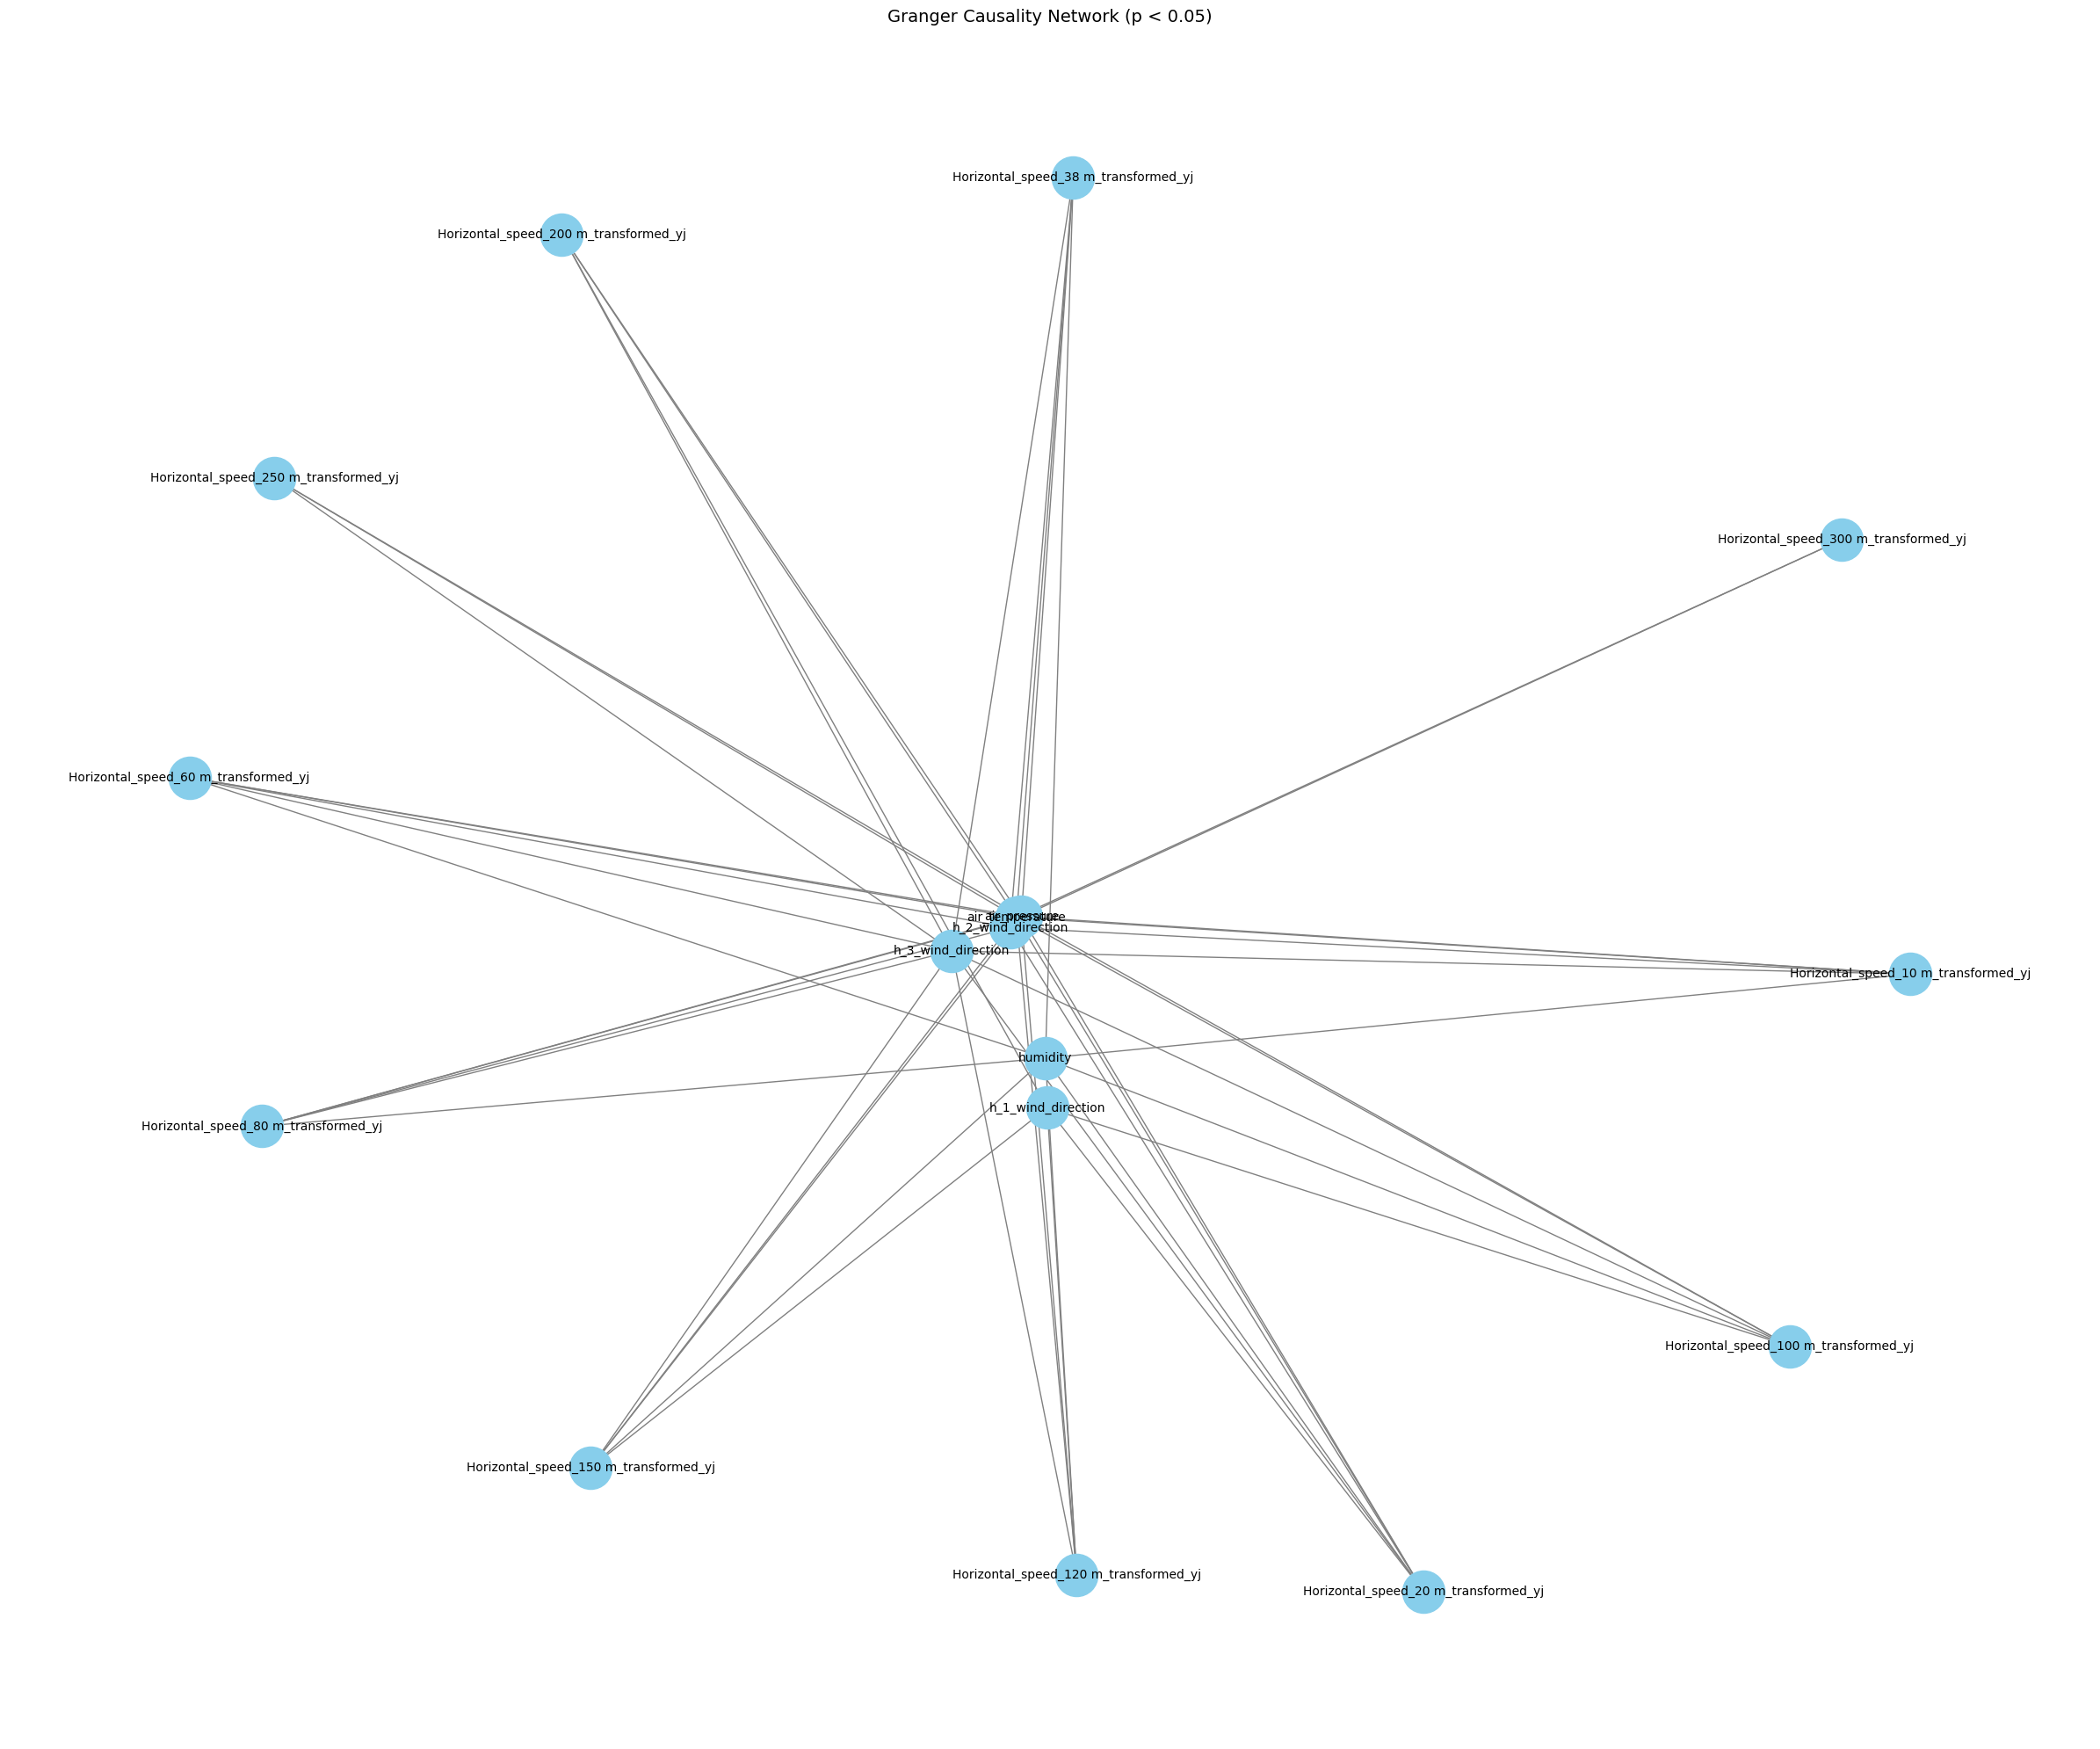

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize directed graph
G = nx.DiGraph()

# Add edges for significant Granger causality (p < 0.05)
for target, ranked in rankings.items():
    for cause, p_val in ranked.items():
        if p_val < 0.05:
            G.add_edge(cause, target, weight=1 - p_val)  # higher weight for lower p-value

# Draw the network
plt.figure(figsize=(24, 20))
pos = nx.spring_layout(G, k=0.2, seed=42)  # Layout for aesthetics

# Draw nodes and labels
nx.draw_networkx_nodes(G, pos, node_size=1200, node_color="skyblue")
nx.draw_networkx_labels(G, pos, font_size=10)

# Draw edges with arrows
nx.draw_networkx_edges(G, pos, arrowstyle="->", arrowsize=15, edge_color="gray")

plt.title("Granger Causality Network (p < 0.05)", fontsize=14)
plt.axis('off')
plt.tight_layout()
plt.show()

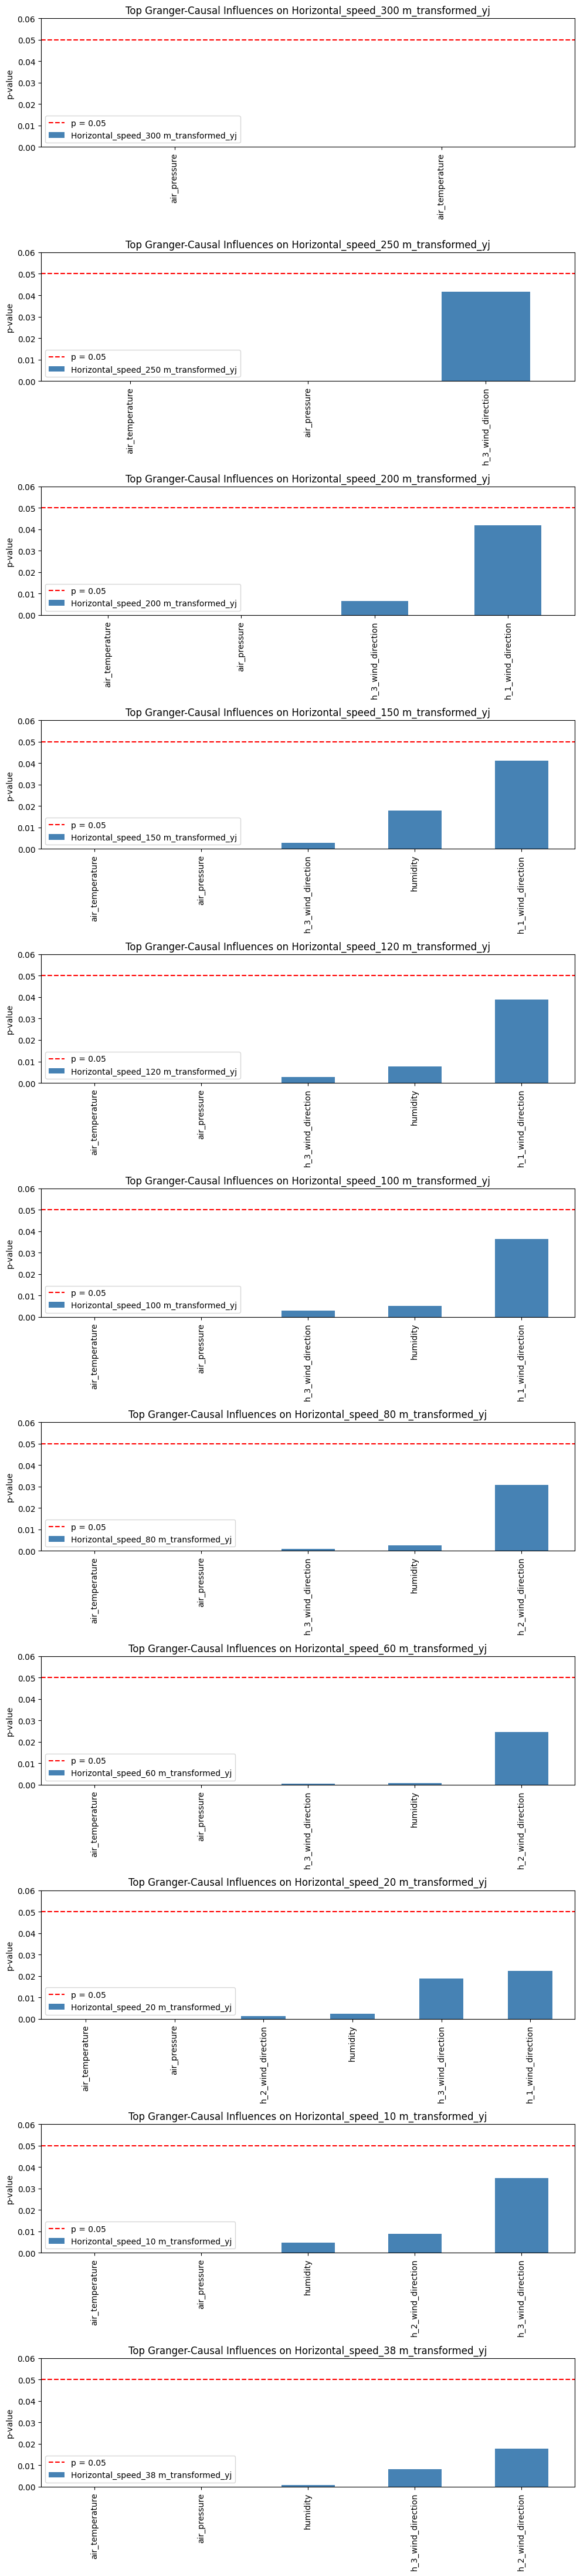

In [ ]:
import matplotlib.pyplot as plt

# Set figure size dynamically based on number of targets
n_targets = len(rankings)
fig, axes = plt.subplots(n_targets, 1, figsize=(10, 4 * n_targets))

if n_targets == 1:
    axes = [axes]  # make iterable if only one plot

# Plot for each target
for ax, (target, ranked) in zip(axes, rankings.items()):
    significant = ranked[ranked < 0.05]
    if significant.empty:
        ax.set_title(f"{target} (no significant influencers)")
        ax.axis('off')
        continue

    significant.plot(kind='bar', ax=ax, color='steelblue')
    ax.set_title(f"Top Granger-Causal Influences on {target}")
    ax.set_ylabel("p-value")
    ax.axhline(0.05, color='red', linestyle='--', label='p = 0.05')
    ax.legend()
    ax.set_ylim(0, 0.06)

plt.tight_layout()
plt.show()

# **HMM+Granger for Regime switch**

In [9]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.vector_ar.var_model import VAR

# Step 1: Train HMM on the selected features
n_states = 3  # adjust as needed
hmm_data = df_selected.dropna().values

hmm = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=100)
hmm.fit(hmm_data)

# Step 2: Predict latent states (regimes)
df_selected['regime'] = hmm.predict(hmm_data)

# Step 3: Granger causality per regime
def granger_matrix_hmm(df, regime_col='regime', maxlag=8):
    regimes = df[regime_col].unique()
    results = {}

    for reg in regimes:
        sub_df = df[df[regime_col] == reg].drop(columns=[regime_col])
        model = VAR(sub_df)
        var_res = model.fit(maxlags=maxlag, ic='bic')

        variables = sub_df.columns
        causing_vars = [col for col in variables if not col.endswith('_yj')]
        targets = [col for col in variables if col.endswith('_yj')]

        mat = pd.DataFrame(index=targets, columns=causing_vars)

        for caused in targets:
            for causing in causing_vars:
                if caused == causing:
                    mat.loc[caused, causing] = None
                    continue
                try:
                    test = var_res.test_causality(caused=caused, causing=causing, kind='f')
                    mat.loc[caused, causing] = test.pvalue
                except Exception as e:
                    mat.loc[caused, causing] = np.nan  # Handle potential test failure
        results[f'regime_{reg}'] = mat
    return results

# Run regime-specific Granger causality
gc_regime_results = granger_matrix_hmm(df_selected)

# Step 4: Display top influencers for each regime
p_value_threshold = 0.05
for regime, mat in gc_regime_results.items():
    print(f"\n=== {regime.upper()} ===")
    for target in mat.index:
        influences = mat.loc[target].dropna().sort_values()
        sig_influences = influences[influences < p_value_threshold]
        if not sig_influences.empty:
            print(f"\nTop influences on {target}:")
            print(sig_influences)
        else:
            print(f"\nNo significant influences found for {target}")


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)



=== REGIME_0 ===

Top influences on Horizontal_speed_300 m_transformed_yj:
h_3_wind_direction    0.034874
h_2_wind_direction    0.038146
air_temperature       0.046592
Name: Horizontal_speed_300 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_250 m_transformed_yj:
air_temperature    0.029926
Name: Horizontal_speed_250 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_200 m_transformed_yj:
air_temperature        0.03527
h_2_wind_direction    0.040926
Name: Horizontal_speed_200 m_transformed_yj, dtype: object

No significant influences found for Horizontal_speed_150 m_transformed_yj

No significant influences found for Horizontal_speed_120 m_transformed_yj

No significant influences found for Horizontal_speed_100 m_transformed_yj

Top influences on Horizontal_speed_80 m_transformed_yj:
humidity    0.041739
Name: Horizontal_speed_80 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_60 m_transformed_yj:
h_9_wind_direction    0.023173

In [ ]:
import pandas as pd
import numpy as np
from hmmlearn.hmm import GaussianHMM
from statsmodels.tsa.vector_ar.var_model import VAR

# Step 1: Train HMM on selected features
n_states = 3
hmm_data = df_selected.dropna().values

# Set random_state for consistent regime assignment
hmm = GaussianHMM(n_components=n_states, covariance_type='full', n_iter=100, random_state=42)
hmm.fit(hmm_data)

# Step 2: Predict latent states (regimes)
df_selected['regime'] = hmm.predict(hmm_data)

# Step 3: Granger causality per regime
def granger_matrix_hmm(df, regime_col='regime', maxlag=26):
    regimes = df[regime_col].unique()
    results = {}

    for reg in regimes:
        sub_df = df[df[regime_col] == reg].drop(columns=[regime_col])

        if sub_df.shape[0] <= maxlag + 2:
            print(f"Skipping regime {reg} (insufficient data points)")
            continue

        model = VAR(sub_df)
        try:
            var_res = model.fit(maxlags=maxlag, ic='bic')
        except Exception as e:
            print(f"Failed to fit VAR for regime {reg}: {e}")
            continue

        variables = sub_df.columns
        causing_vars = [col for col in variables if not col.endswith('_yj')]
        targets = [col for col in variables if col.endswith('_yj')]

        mat = pd.DataFrame(index=targets, columns=causing_vars)

        for caused in targets:
            for causing in causing_vars:
                if caused == causing:
                    mat.loc[caused, causing] = None
                    continue
                try:
                    test = var_res.test_causality(caused=caused, causing=causing, kind='f')
                    mat.loc[caused, causing] = test.pvalue
                except Exception as e:
                    mat.loc[caused, causing] = np.nan
        results[f'regime_{reg}'] = mat
    return results

# Run regime-specific Granger causality
gc_regime_results = granger_matrix_hmm(df_selected)

# Step 4: Display top influencers per target for each regime
p_value_threshold = 0.05

for regime, mat in gc_regime_results.items():
    print(f"\n=== {regime.upper()} ===")
    for target in mat.index:
        influences = mat.loc[target].dropna().sort_values()
        sig_influences = influences[influences < p_value_threshold]
        if not sig_influences.empty:
            print(f"\nTop influences on {target}:")
            print(sig_influences)
        else:
            print(f"\nNo significant influences found for {target}")


=== REGIME_1 ===

Top influences on Horizontal_speed_300 m_transformed_yj:
h_3_wind_direction    0.034874
h_2_wind_direction    0.038146
air_temperature       0.046592
Name: Horizontal_speed_300 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_250 m_transformed_yj:
air_temperature    0.029926
Name: Horizontal_speed_250 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_200 m_transformed_yj:
air_temperature        0.03527
h_2_wind_direction    0.040926
Name: Horizontal_speed_200 m_transformed_yj, dtype: object

No significant influences found for Horizontal_speed_150 m_transformed_yj

No significant influences found for Horizontal_speed_120 m_transformed_yj

No significant influences found for Horizontal_speed_100 m_transformed_yj

Top influences on Horizontal_speed_80 m_transformed_yj:
humidity    0.041739
Name: Horizontal_speed_80 m_transformed_yj, dtype: object

Top influences on Horizontal_speed_60 m_transformed_yj:
h_9_wind_direction    0.023173

/tmp/ipython-input-12-2912515054.py:36: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


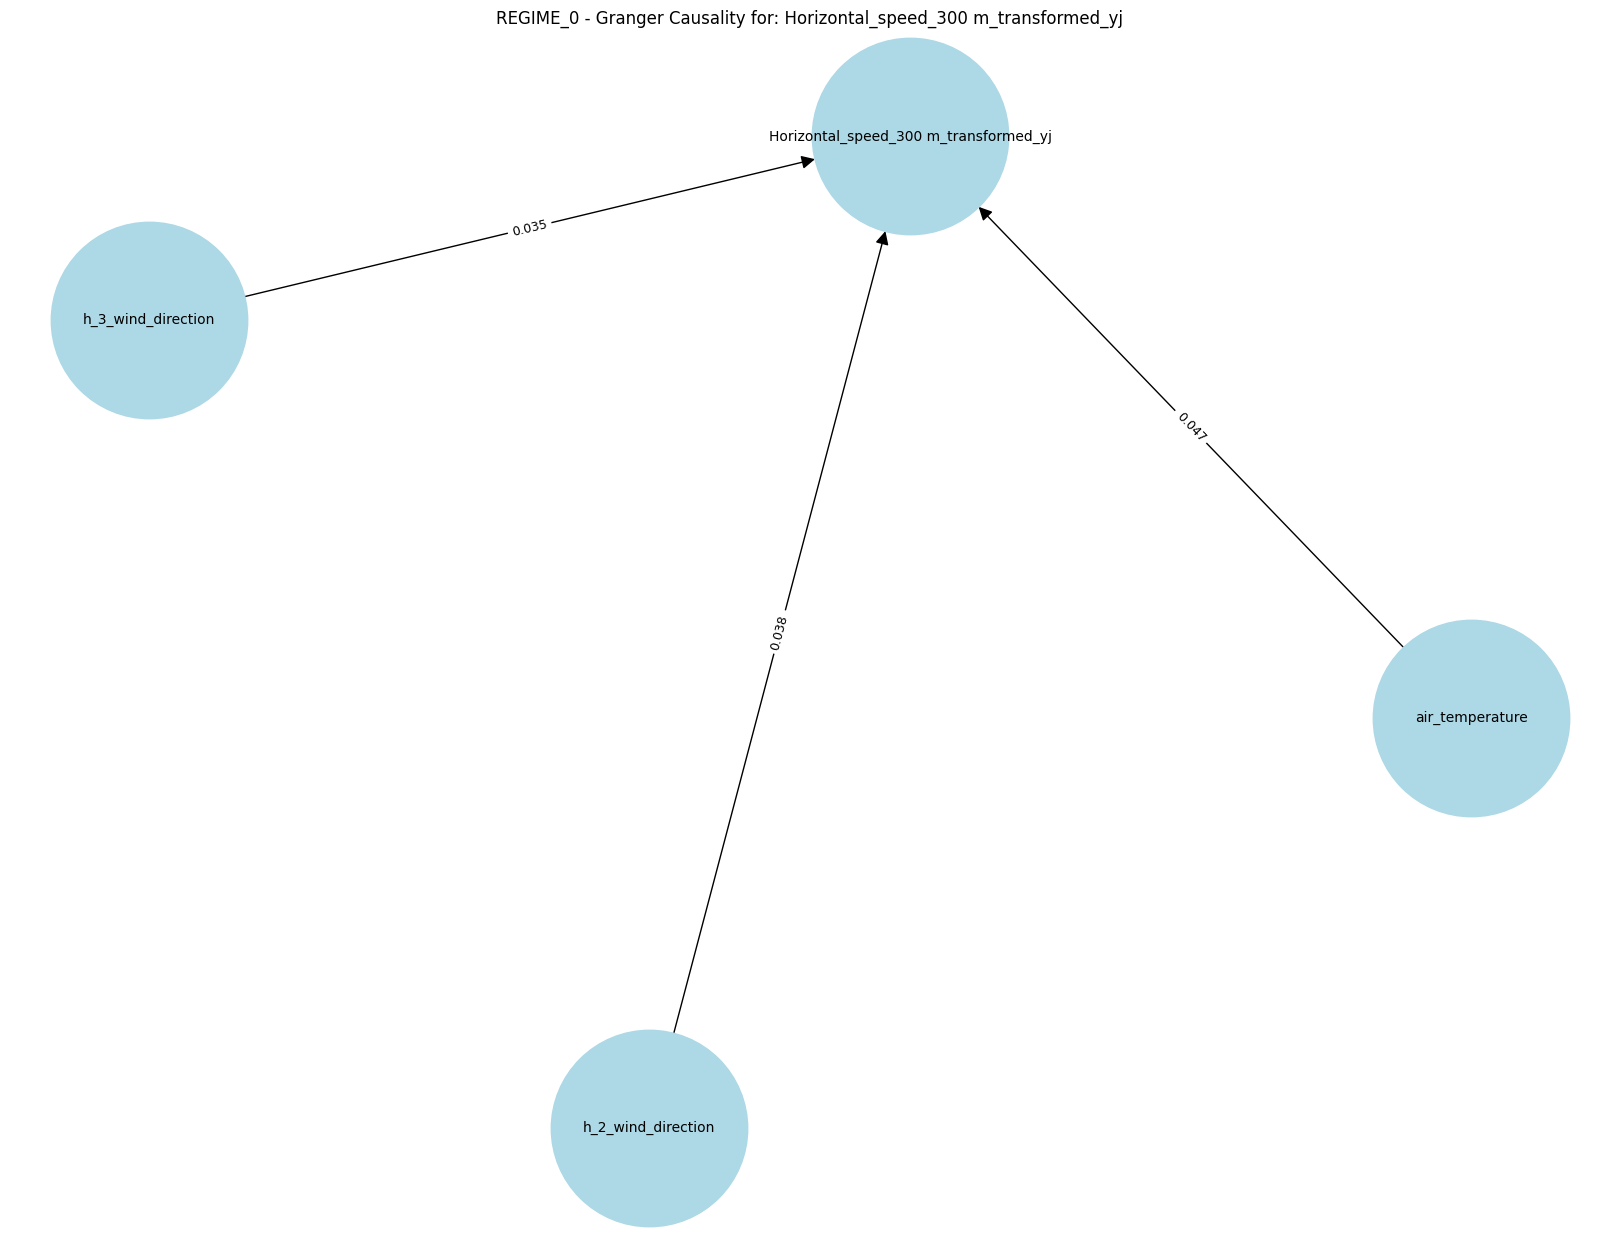

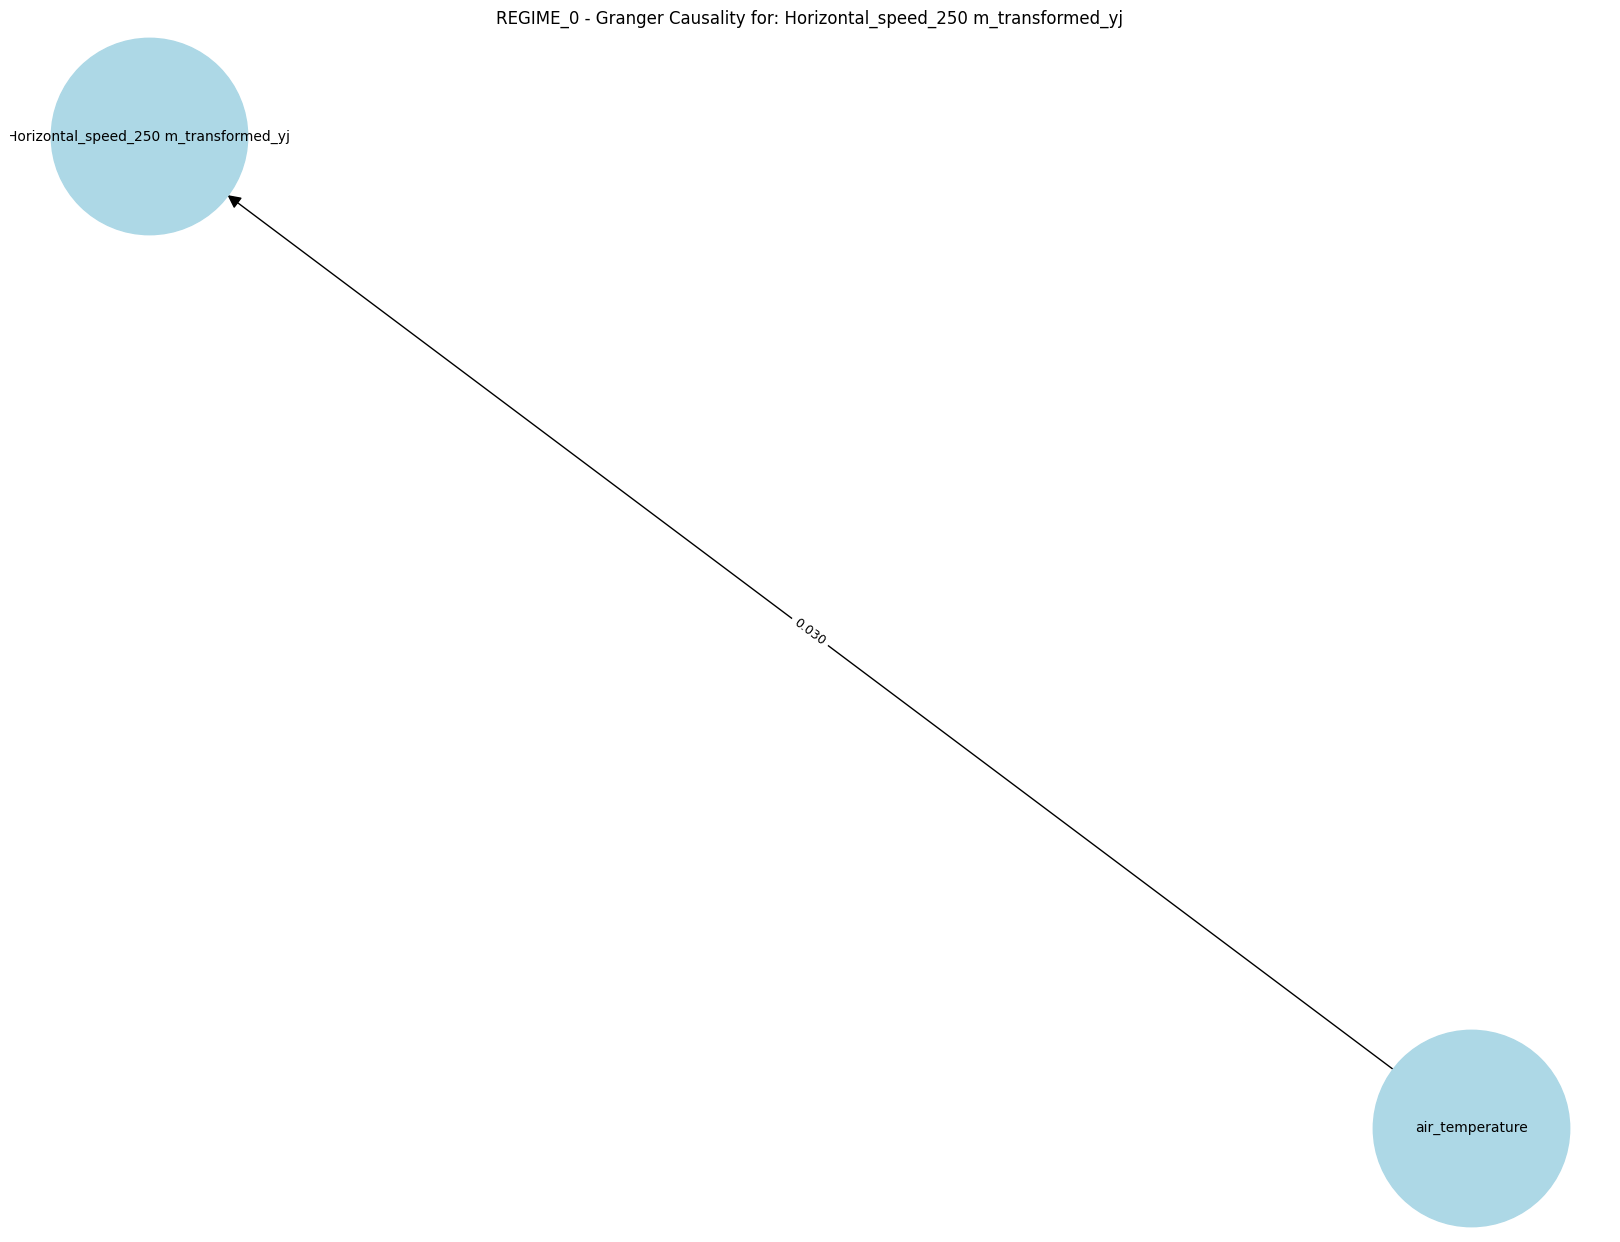

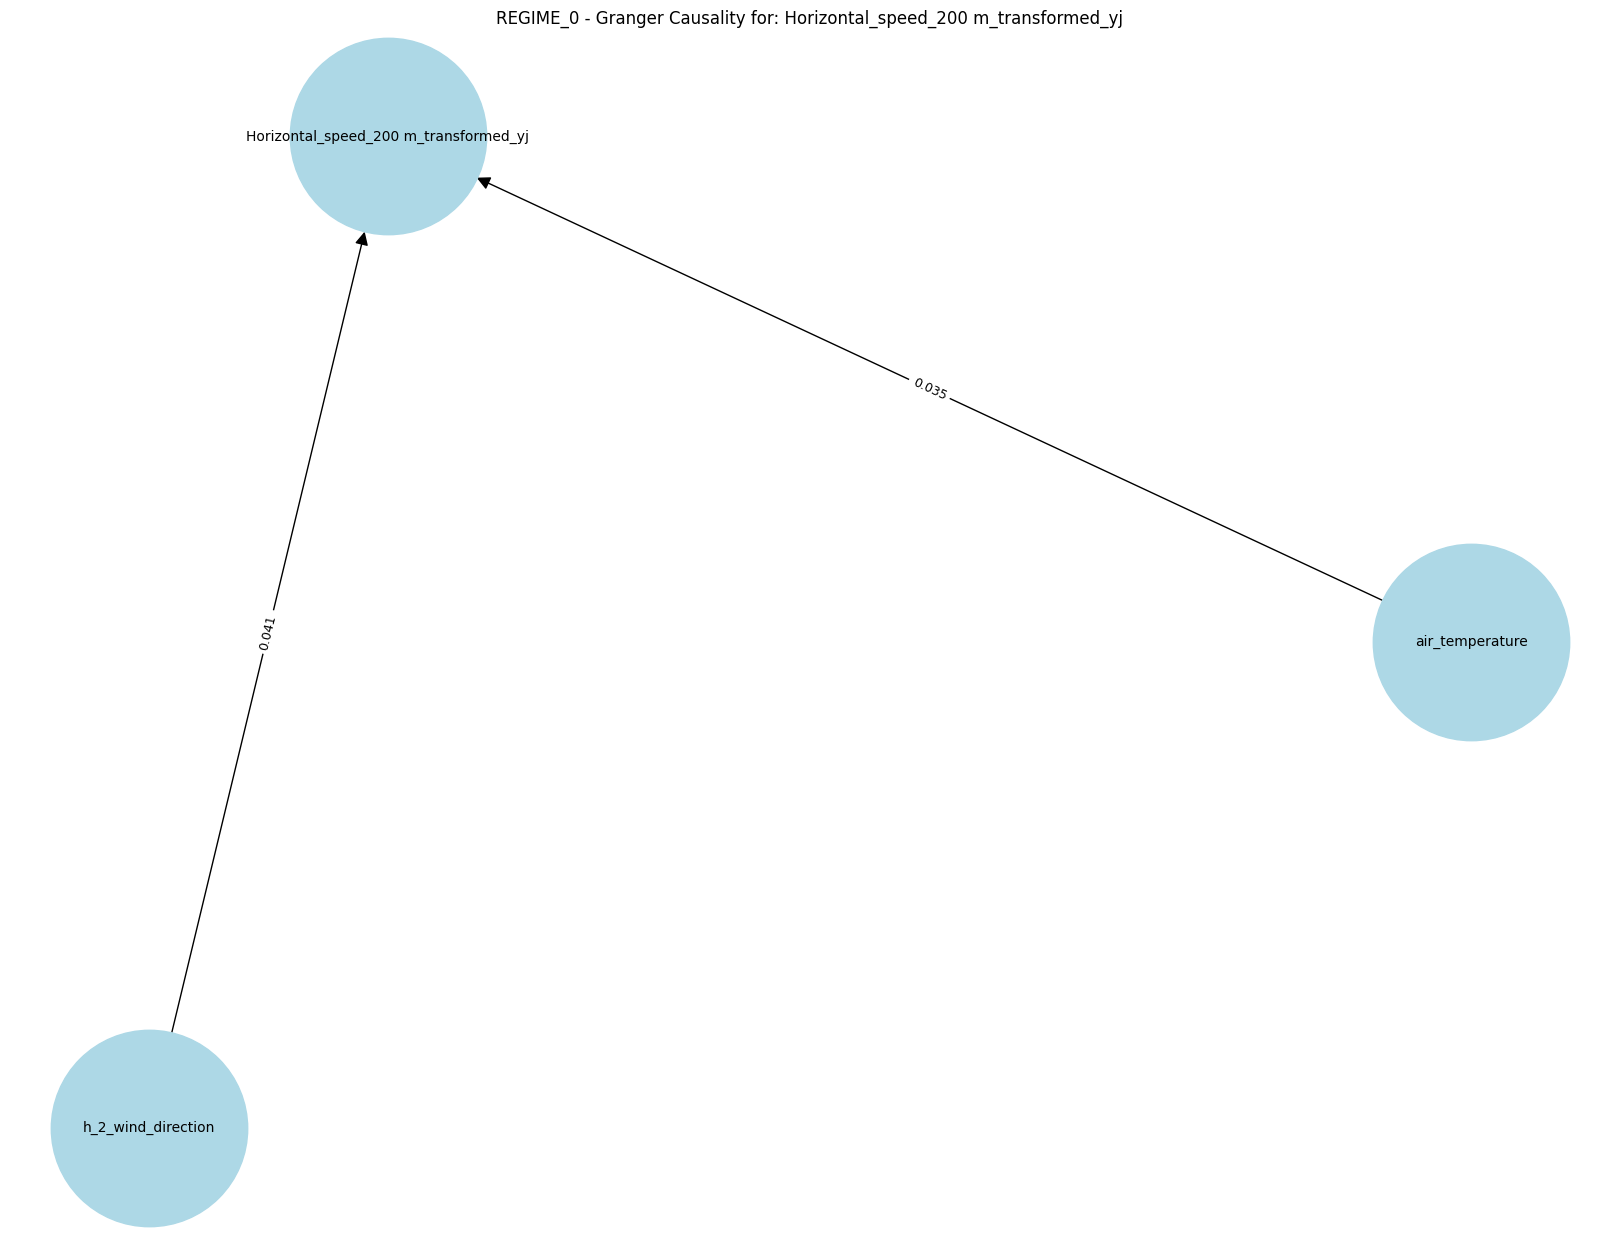

No significant influencers for Horizontal_speed_150 m_transformed_yj in regime_0
No significant influencers for Horizontal_speed_120 m_transformed_yj in regime_0
No significant influencers for Horizontal_speed_100 m_transformed_yj in regime_0


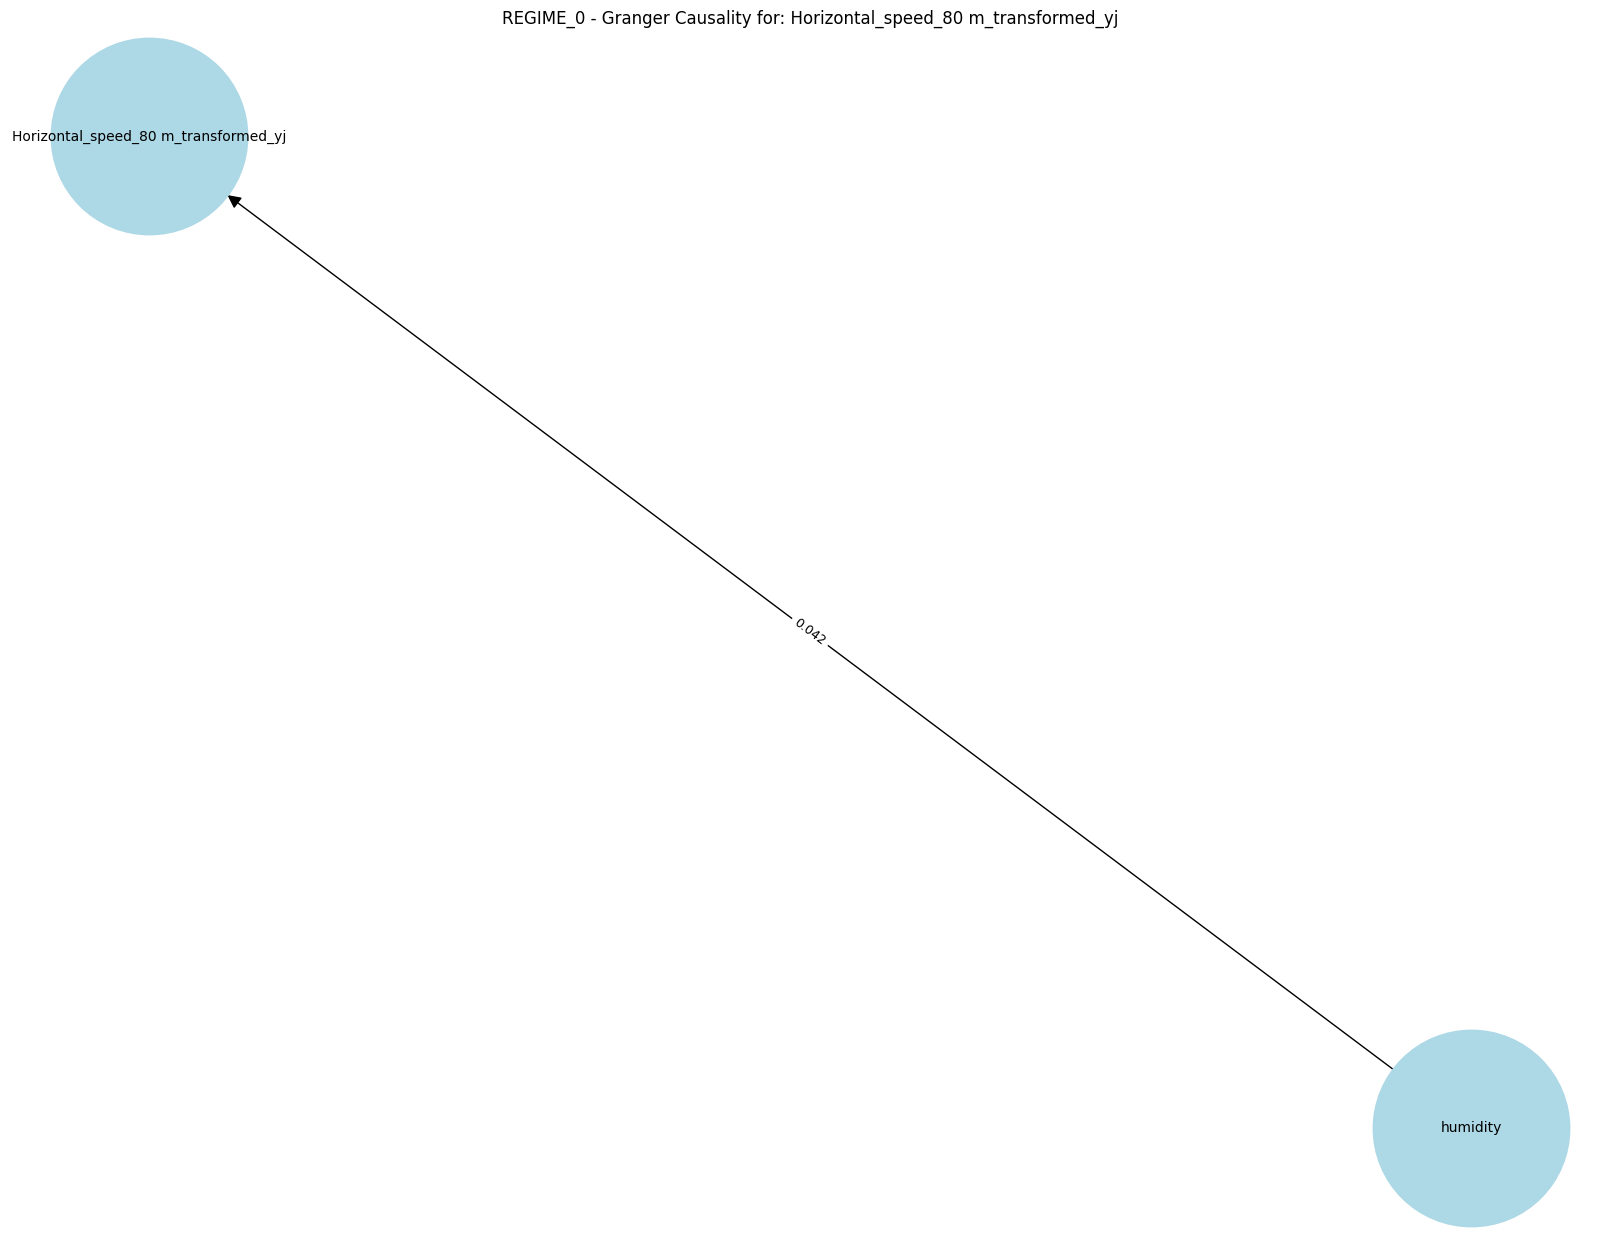

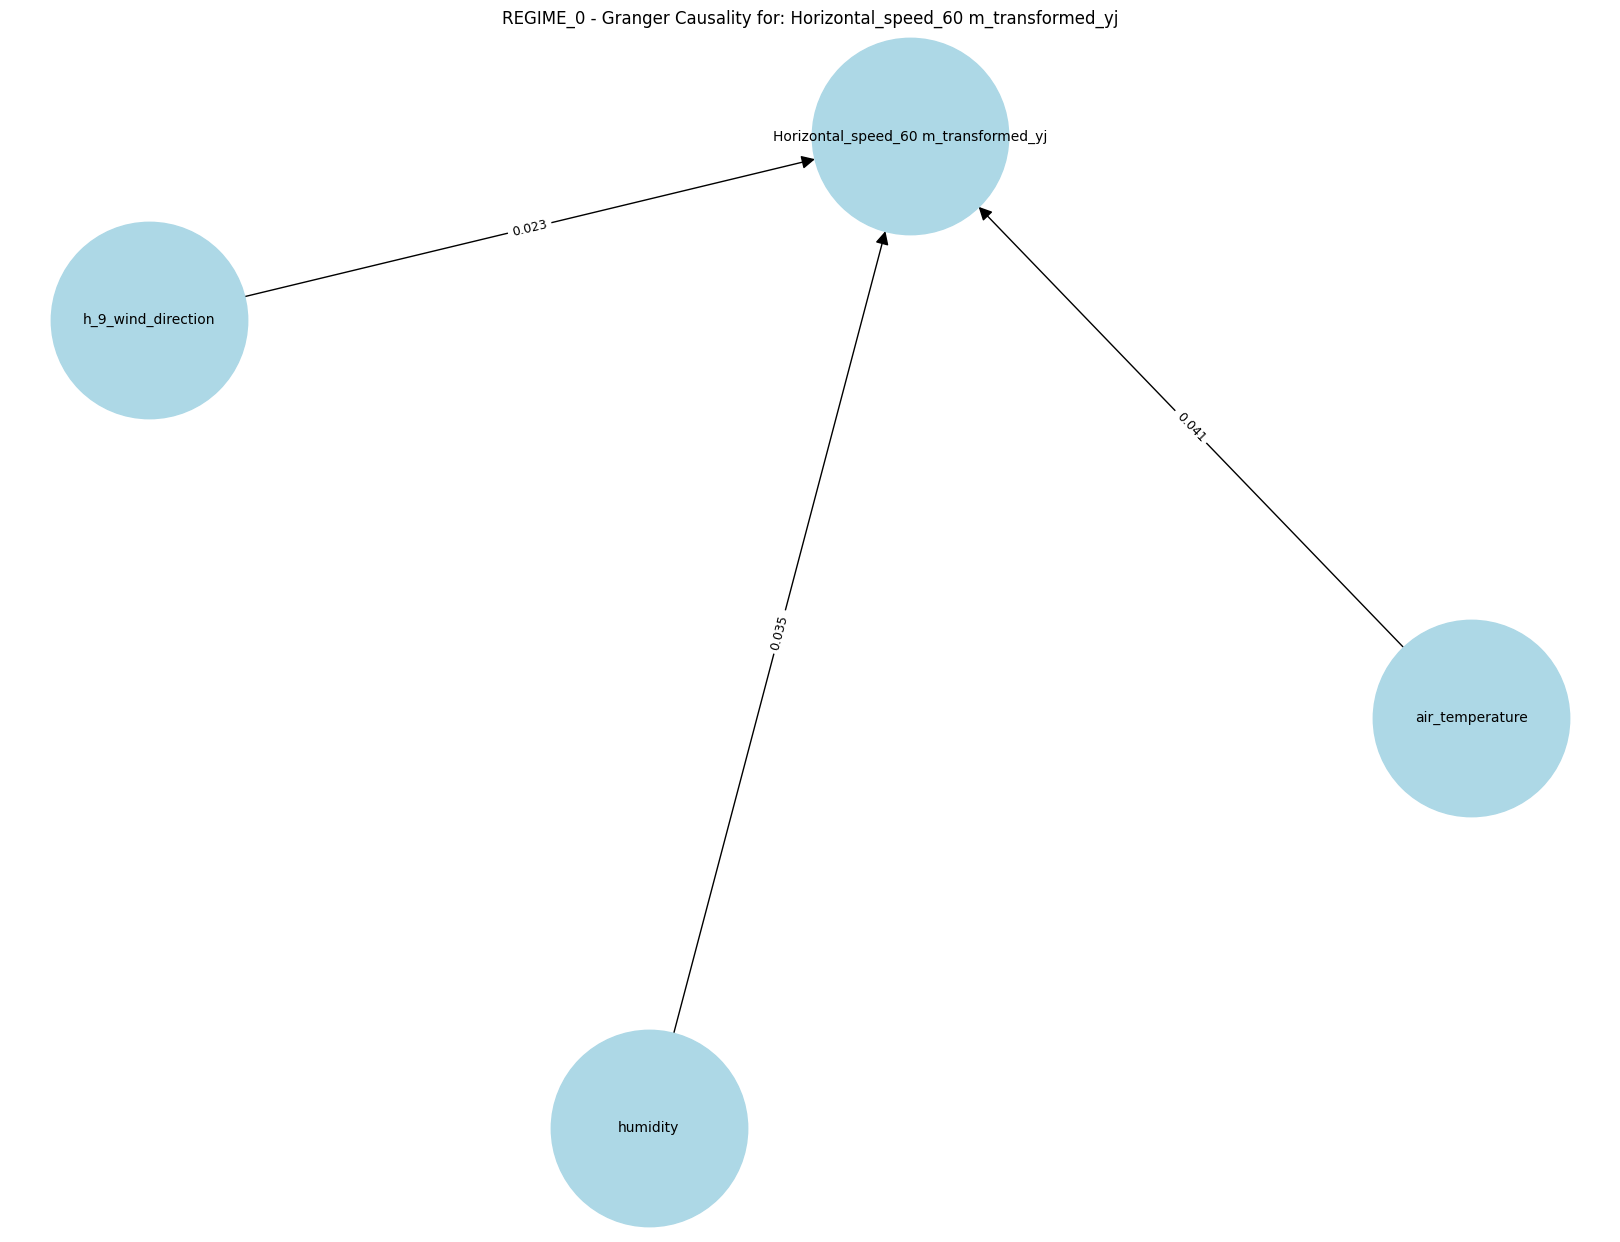

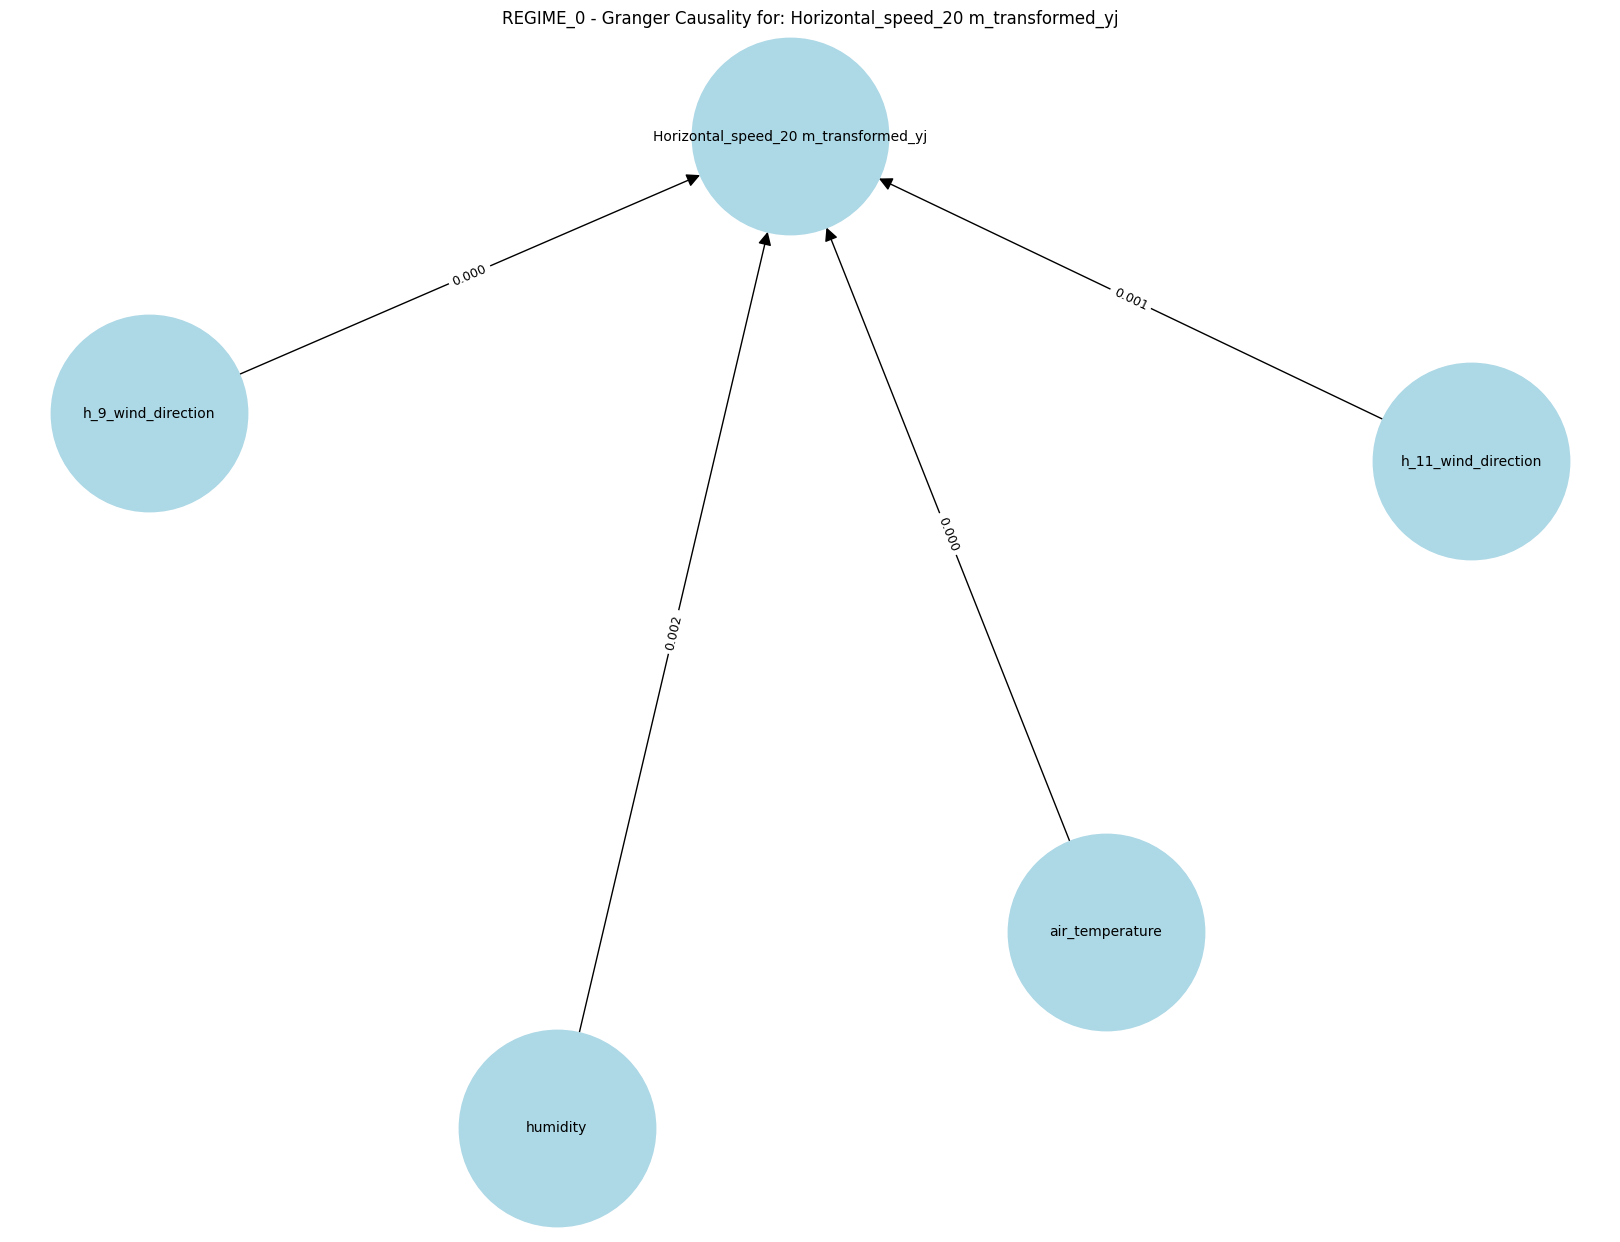

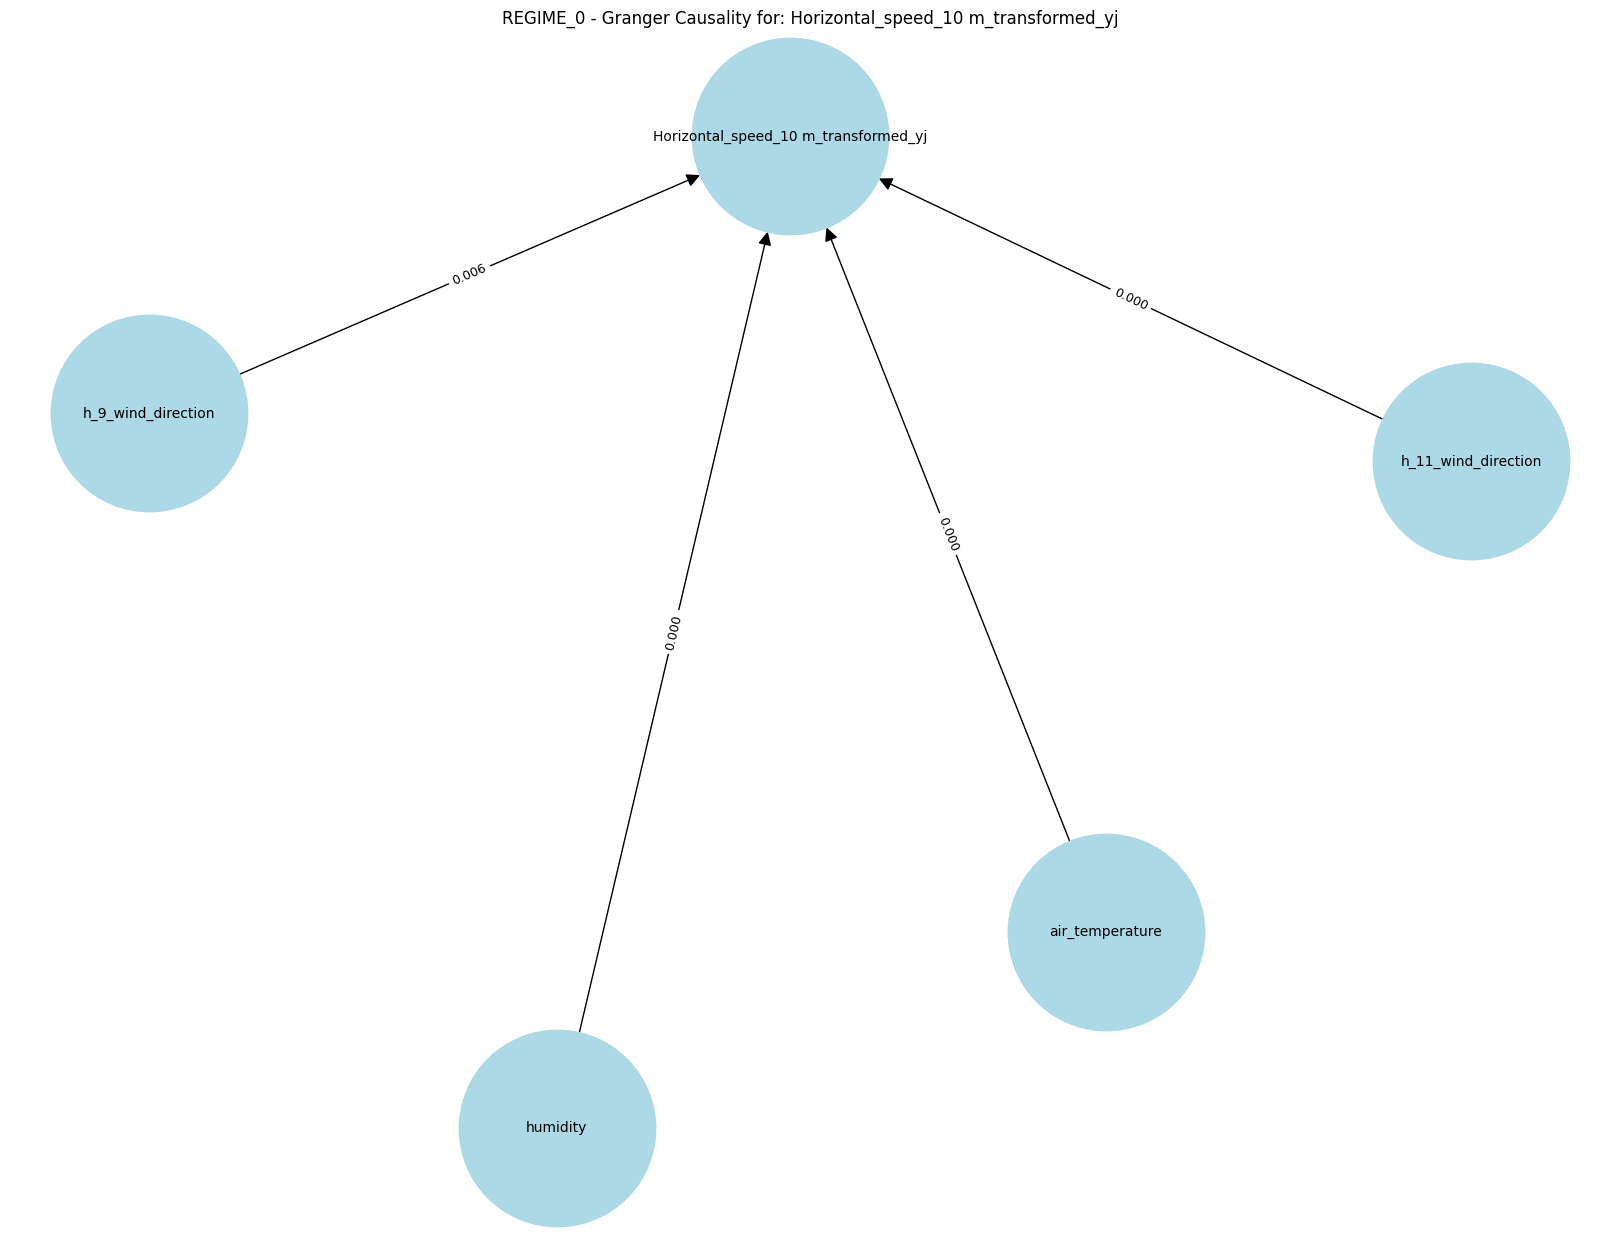

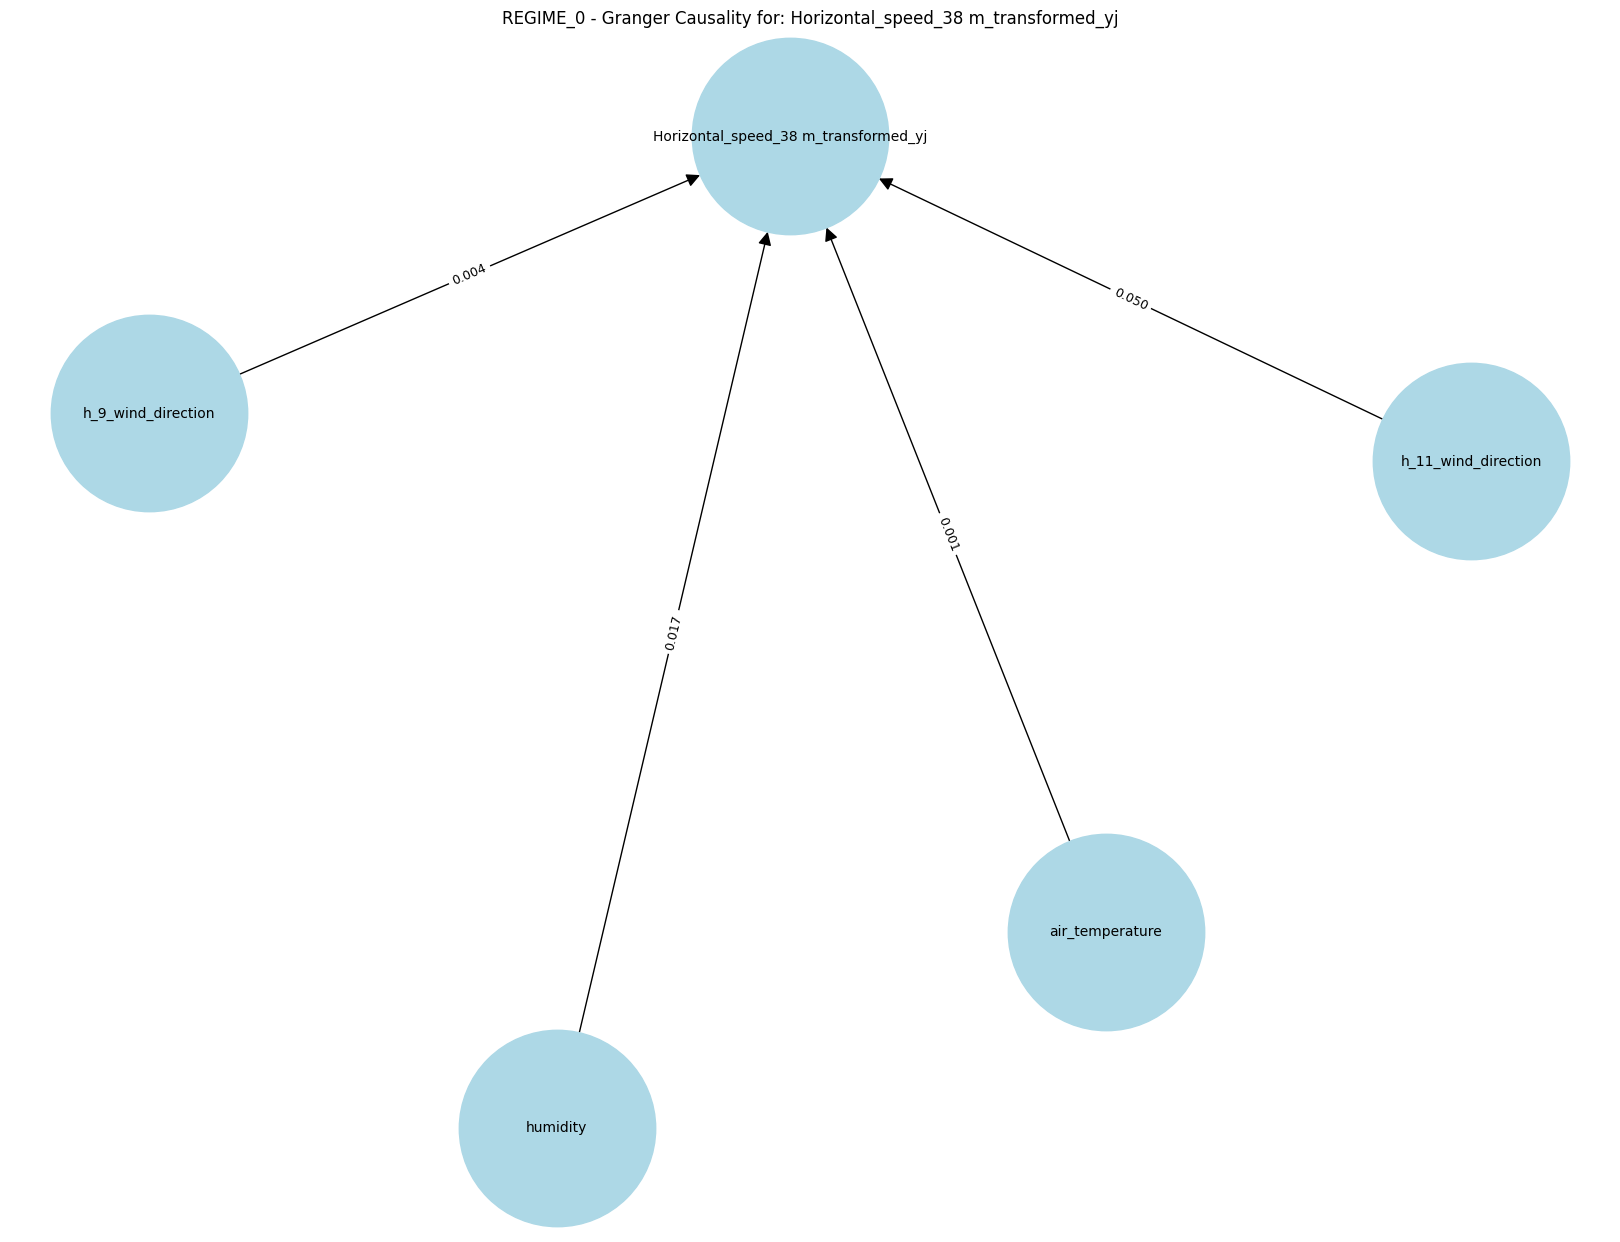

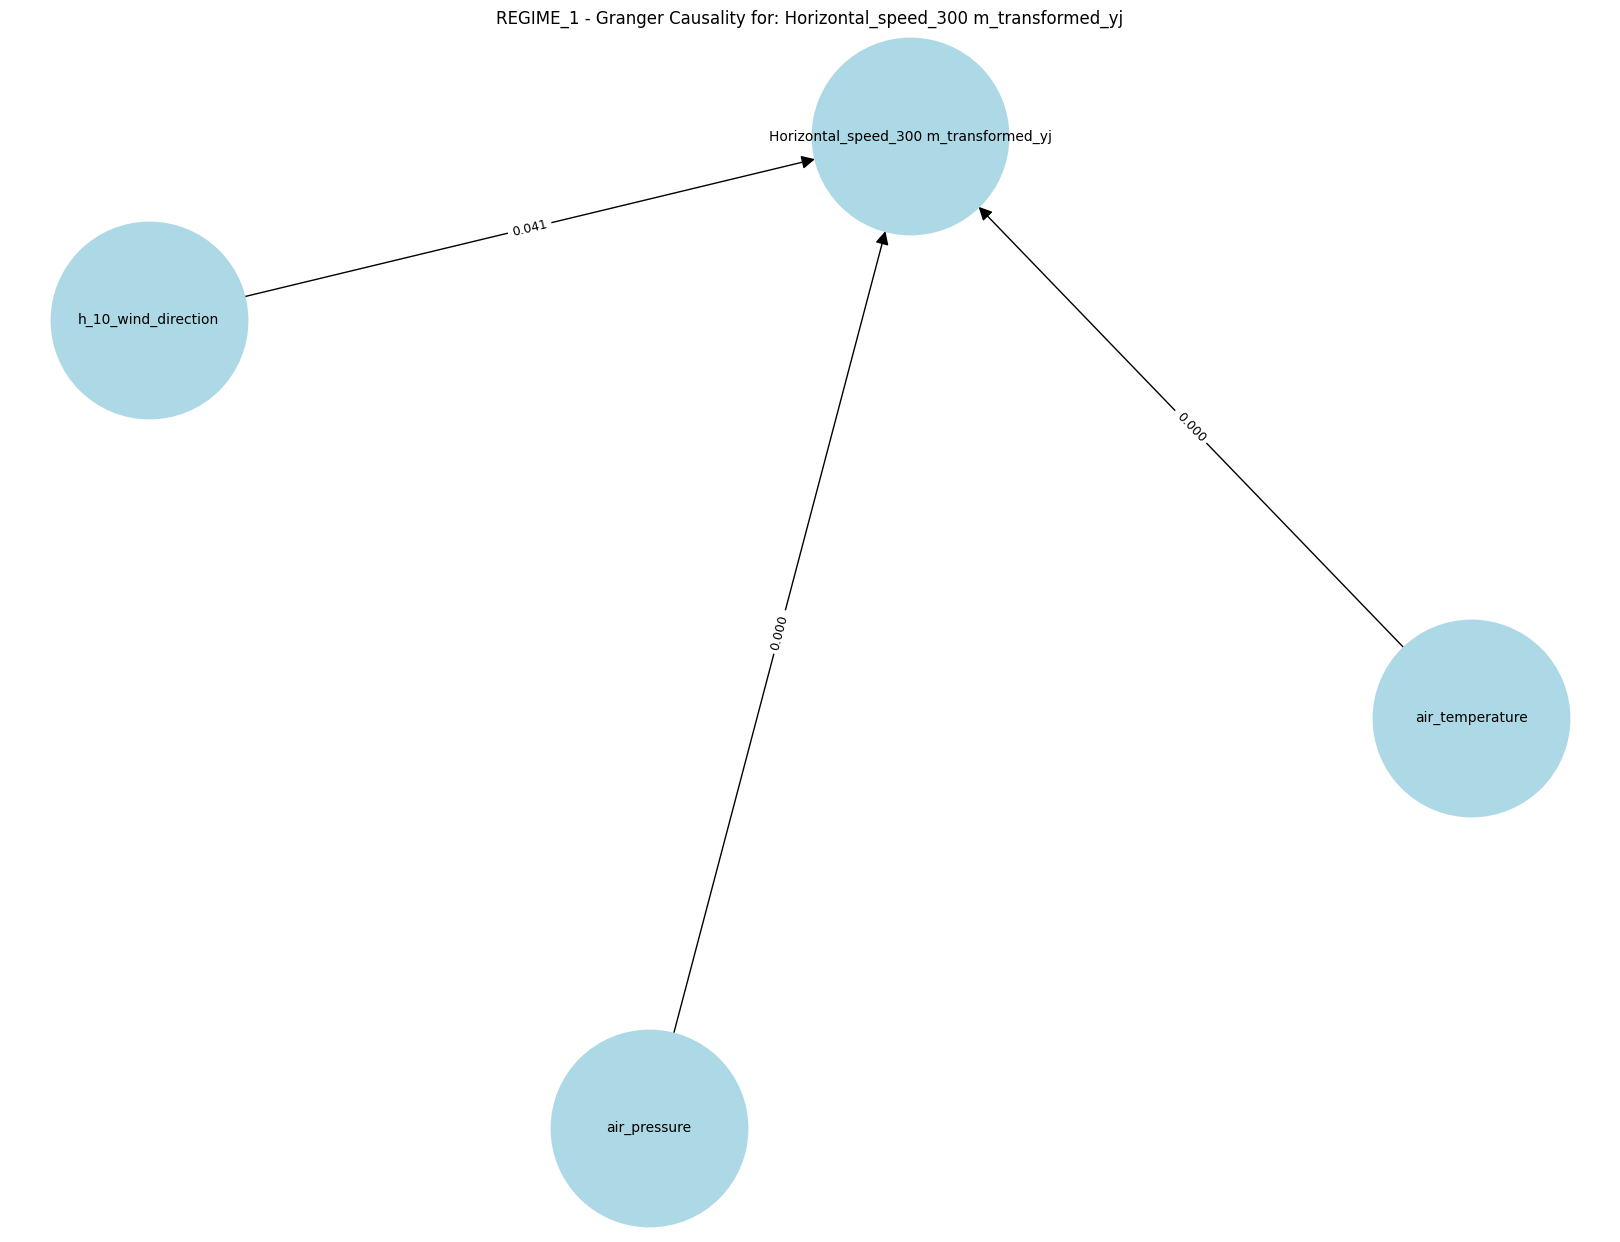

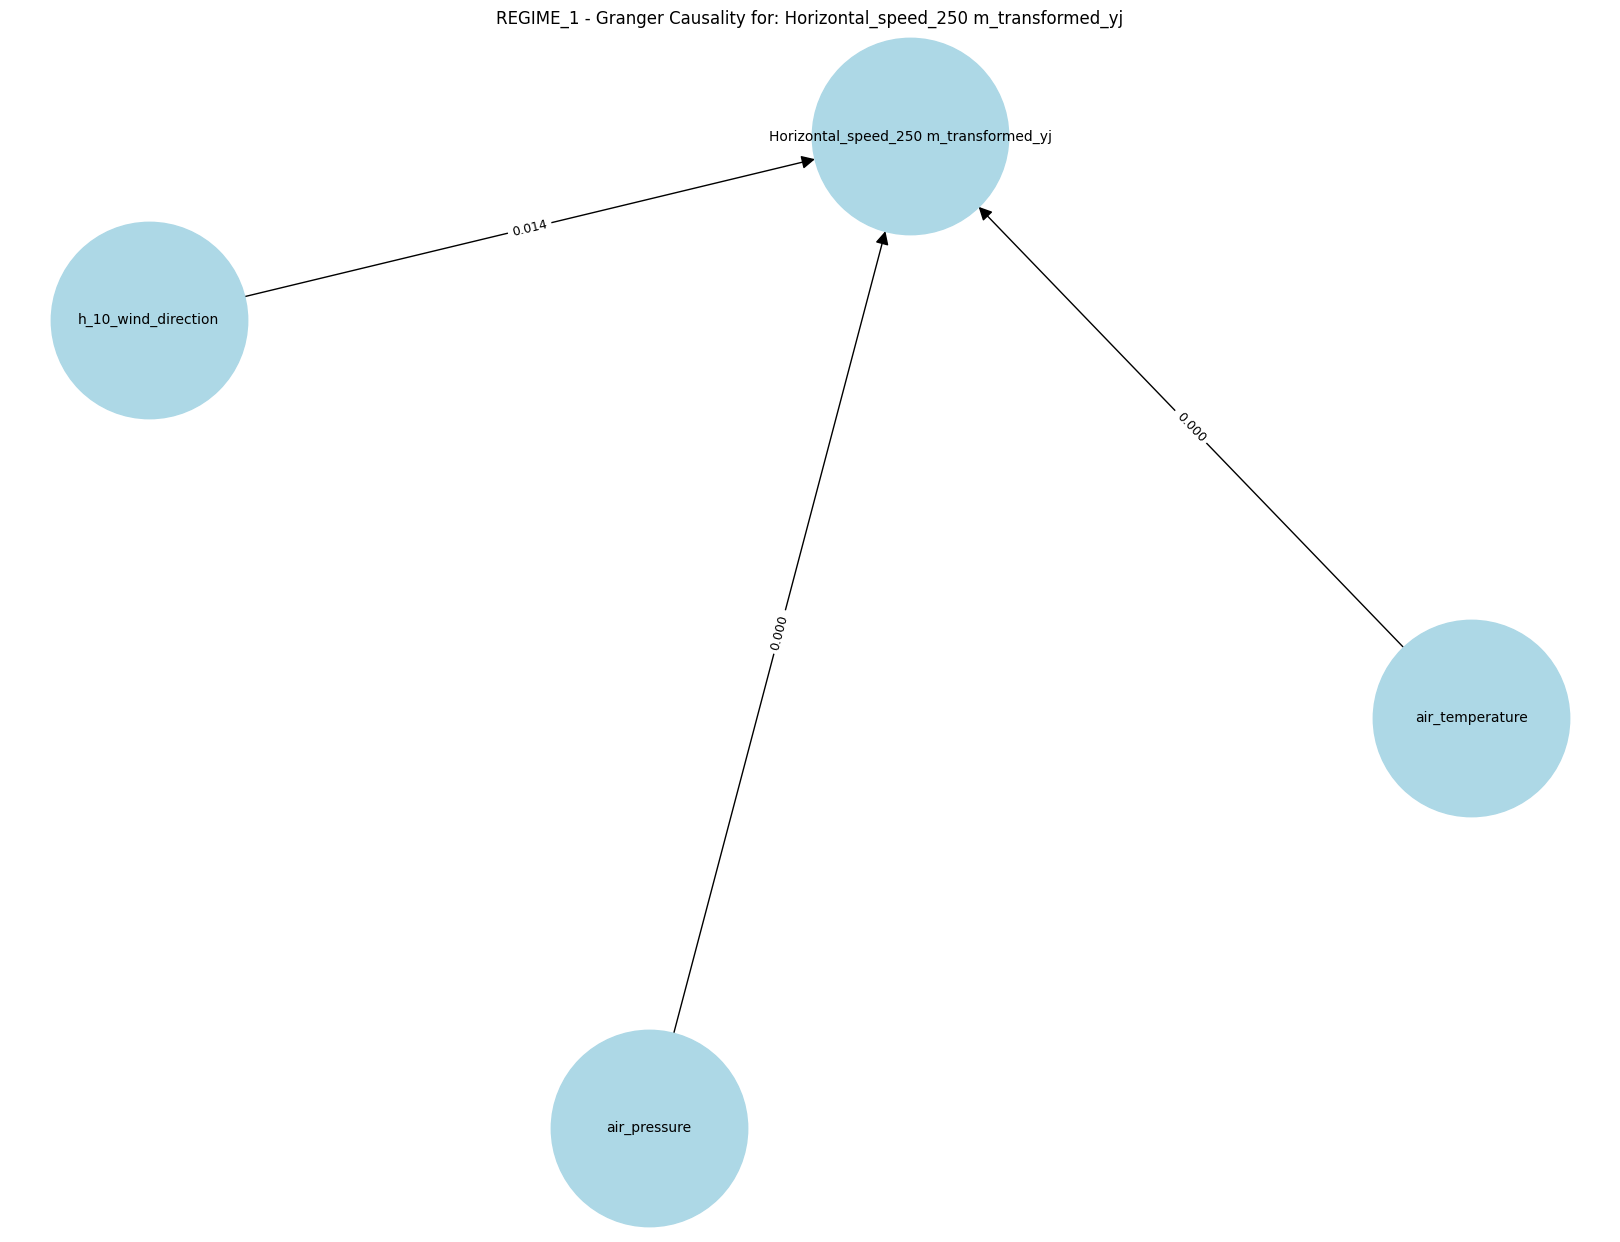

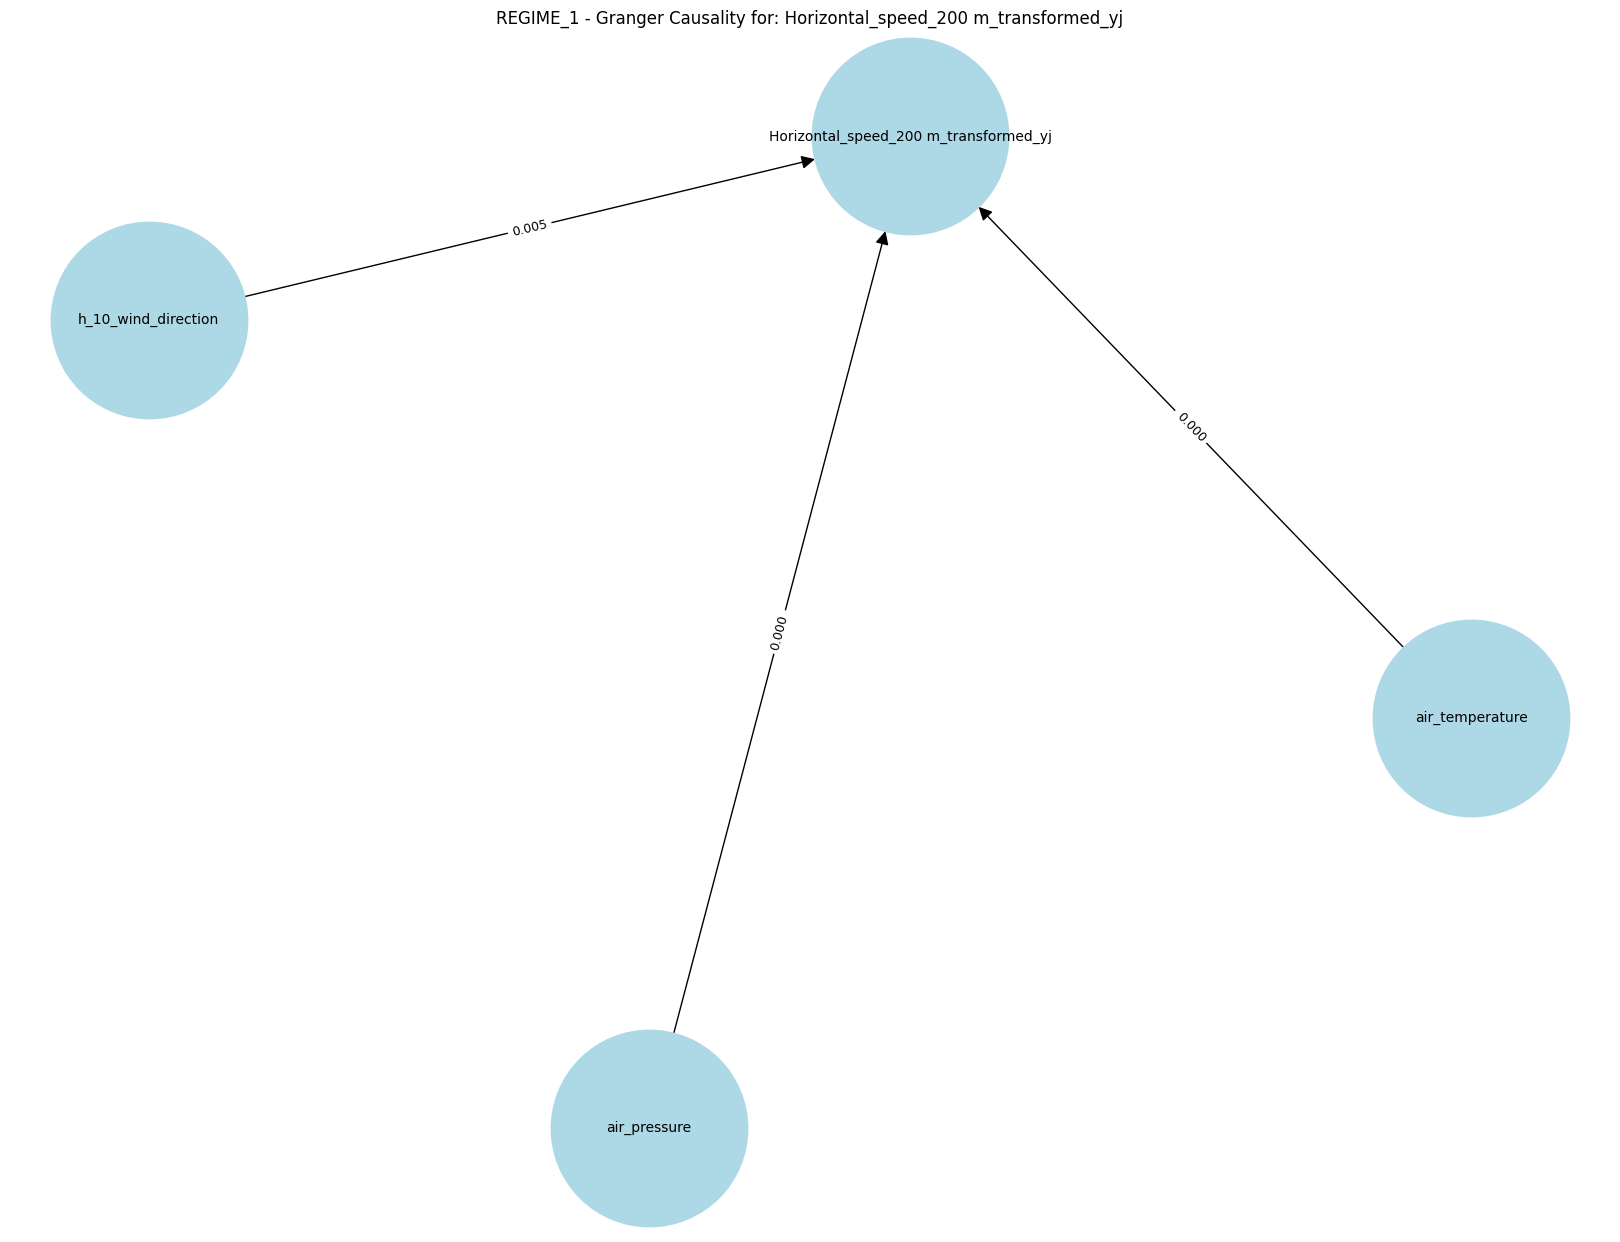

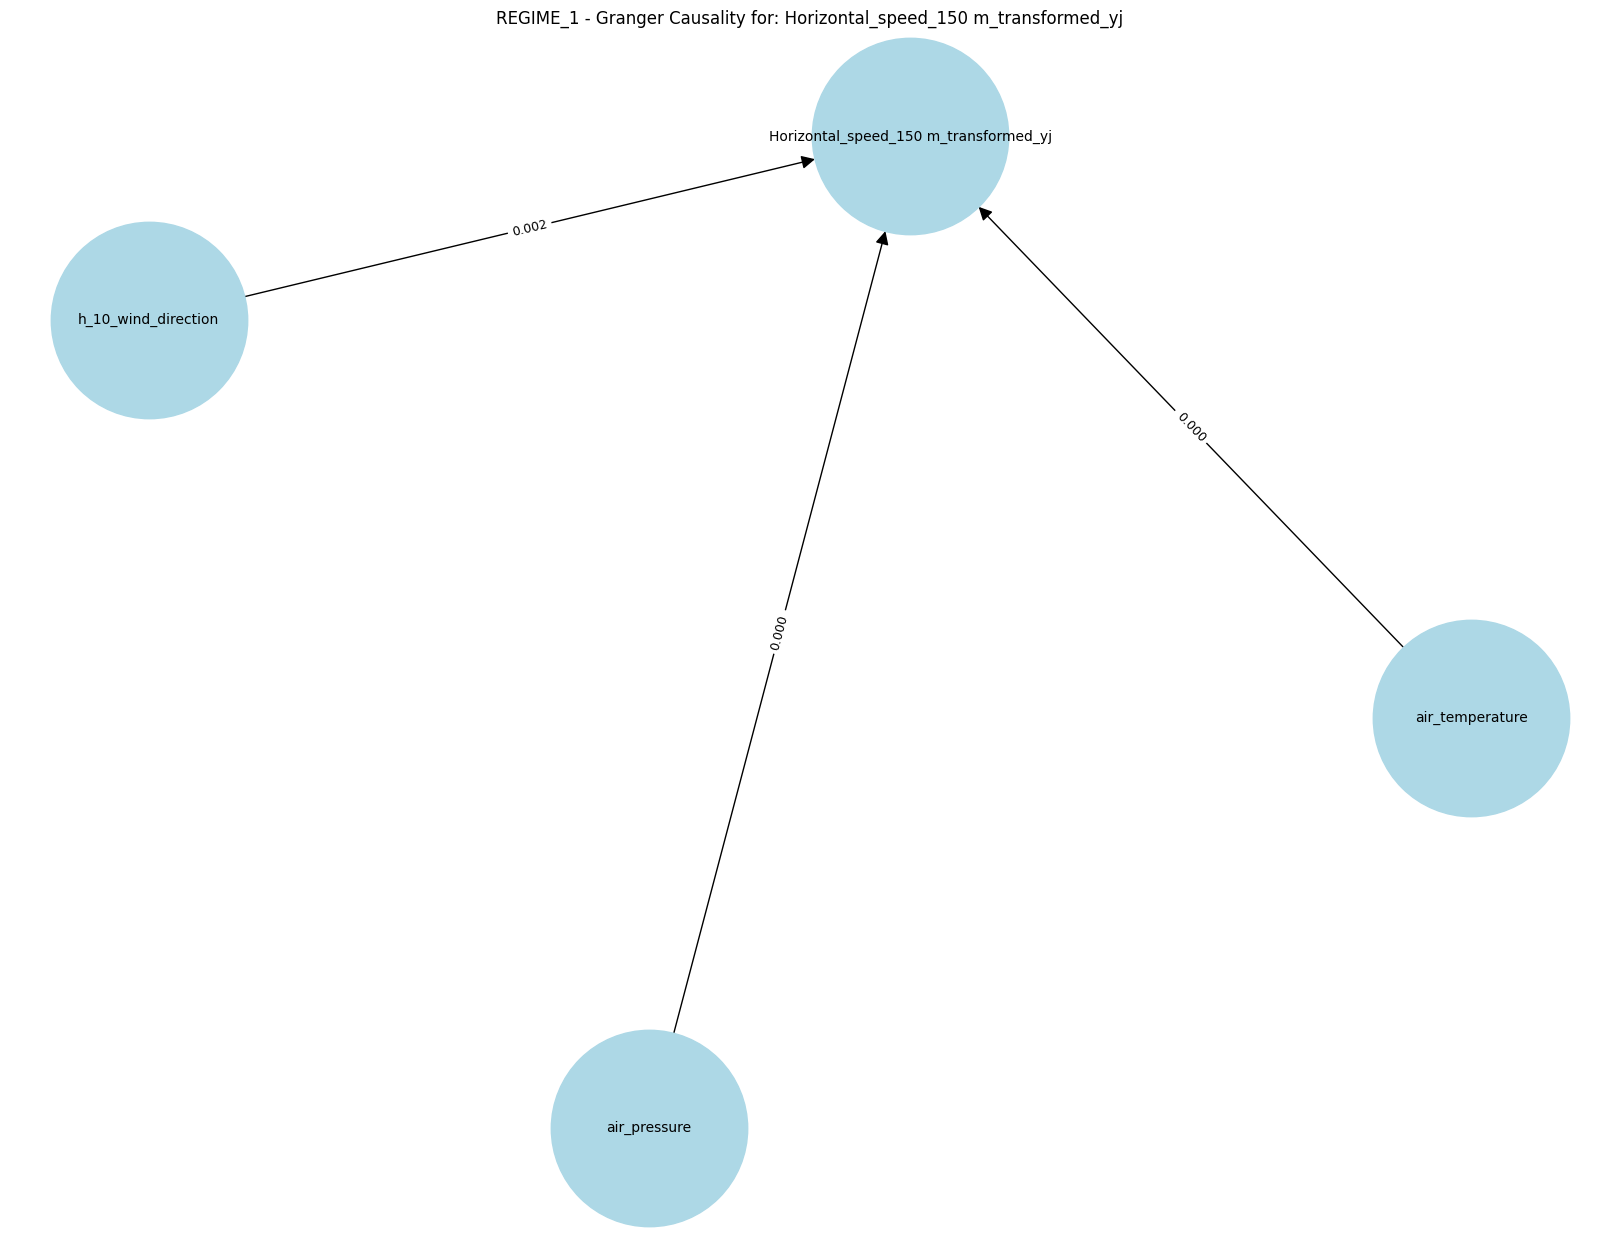

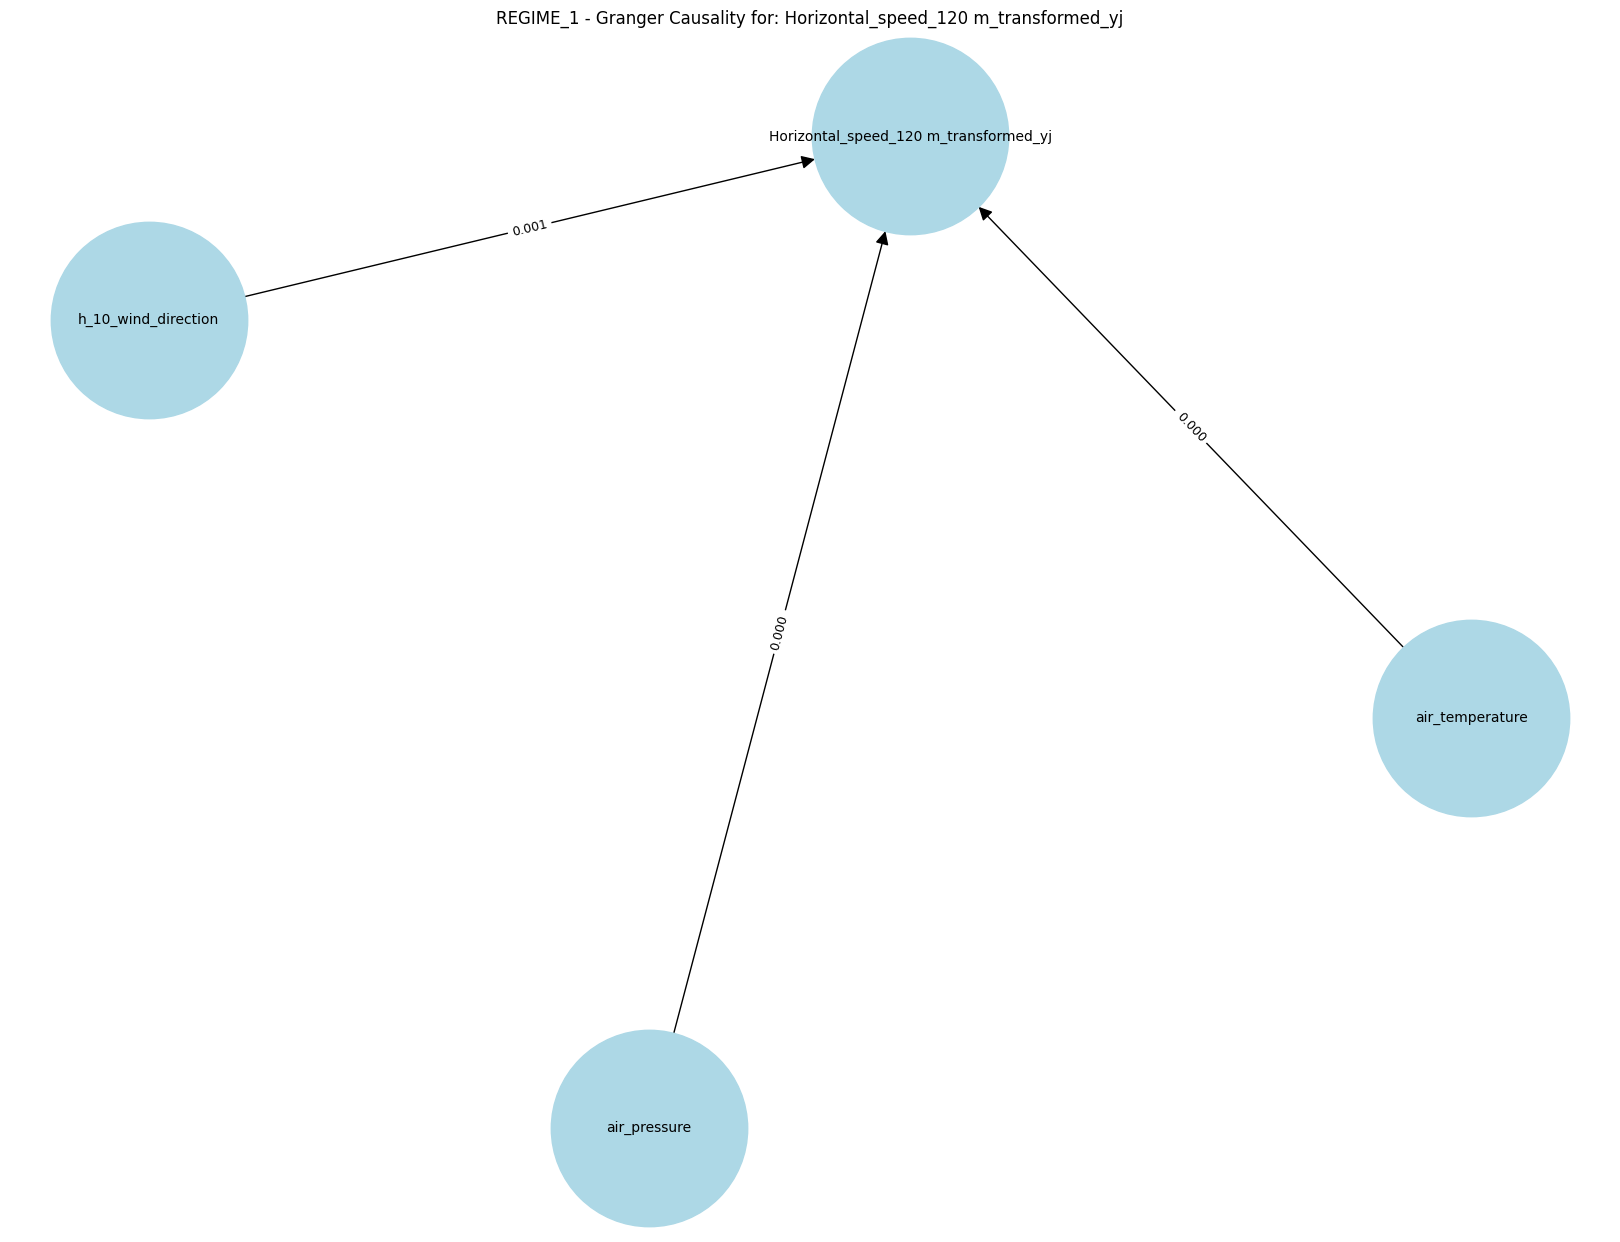

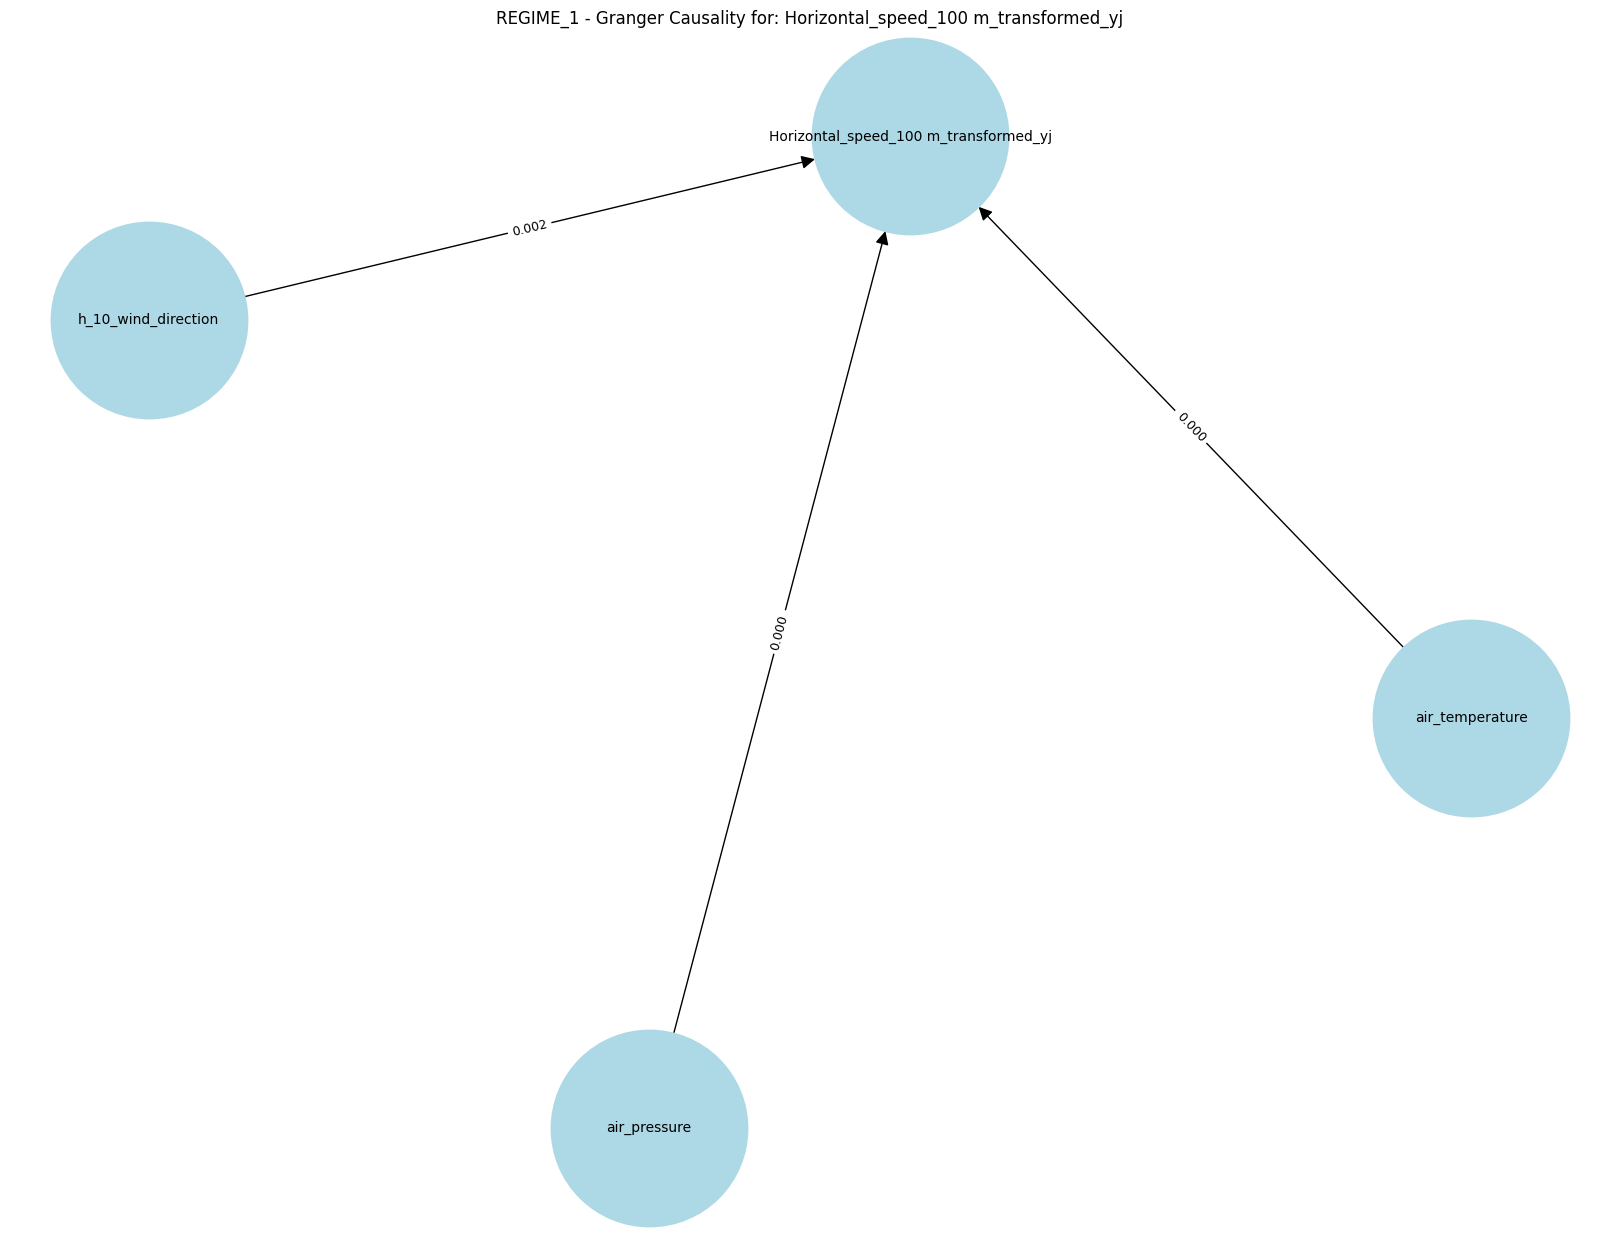

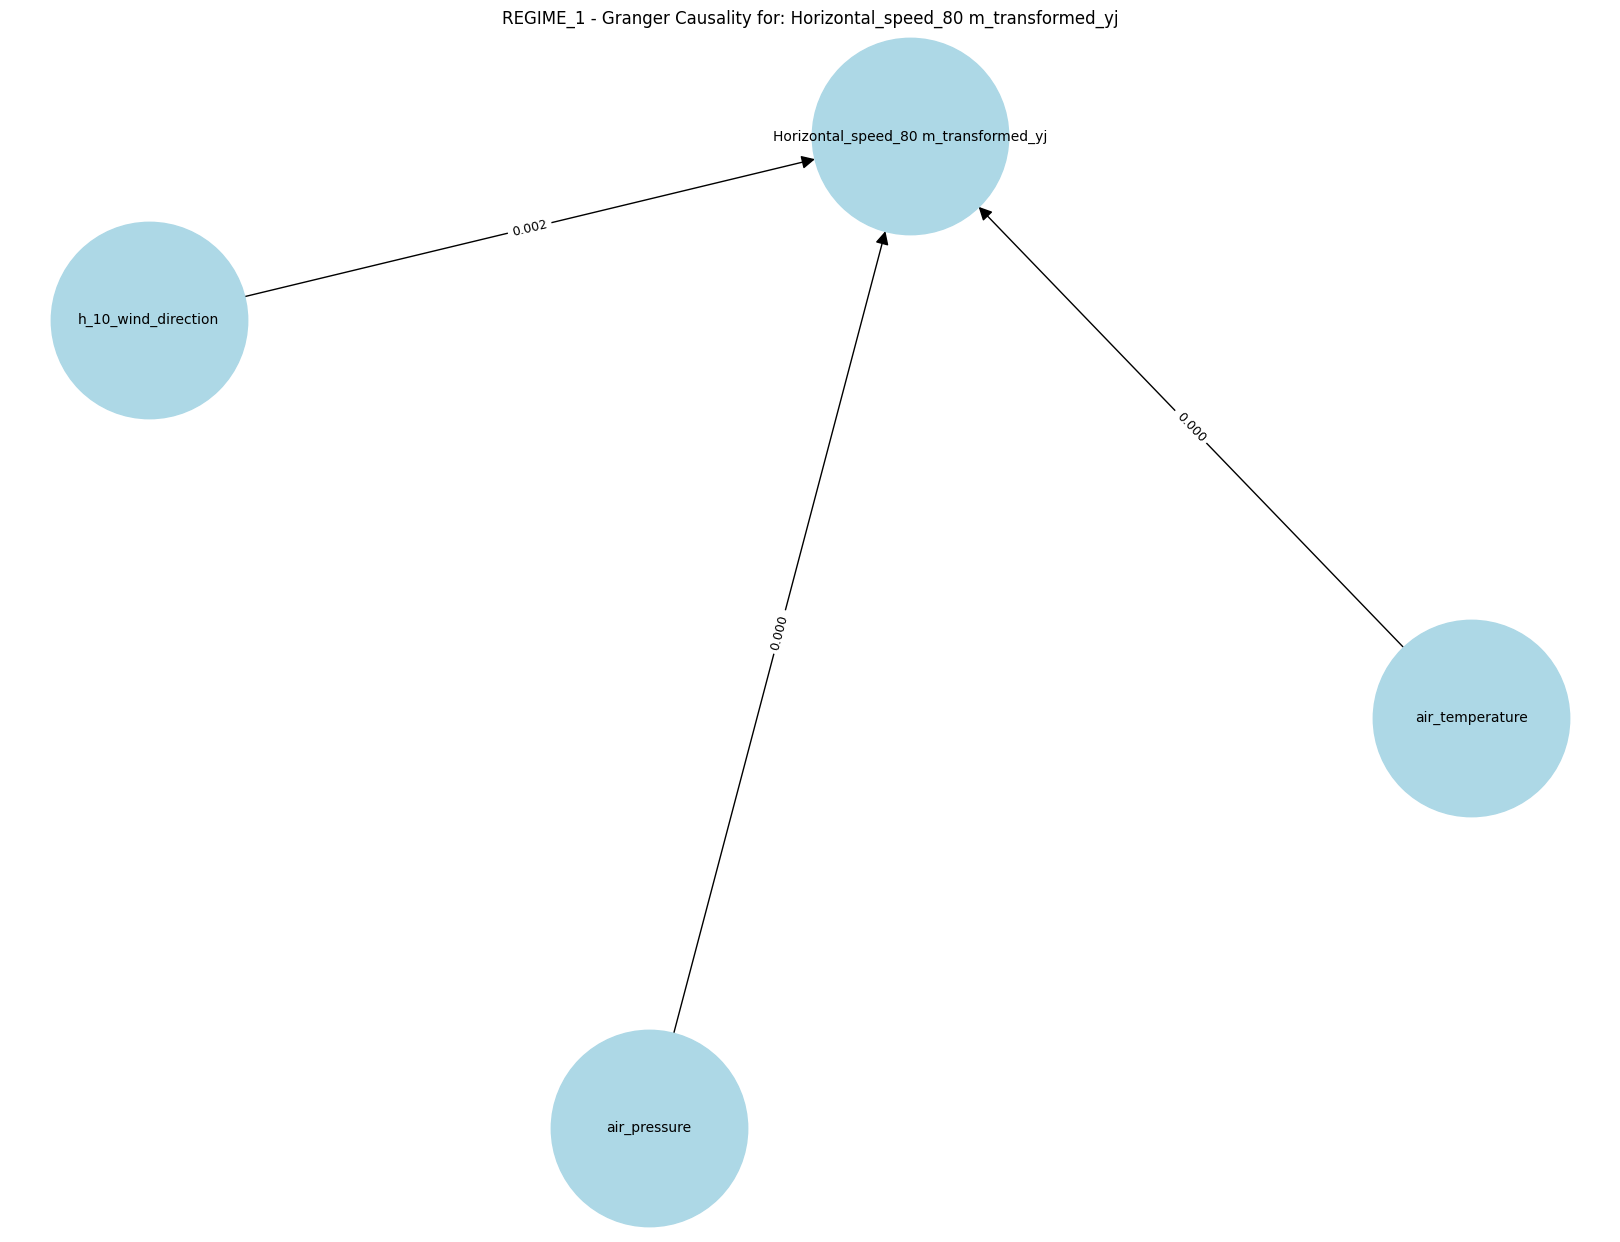

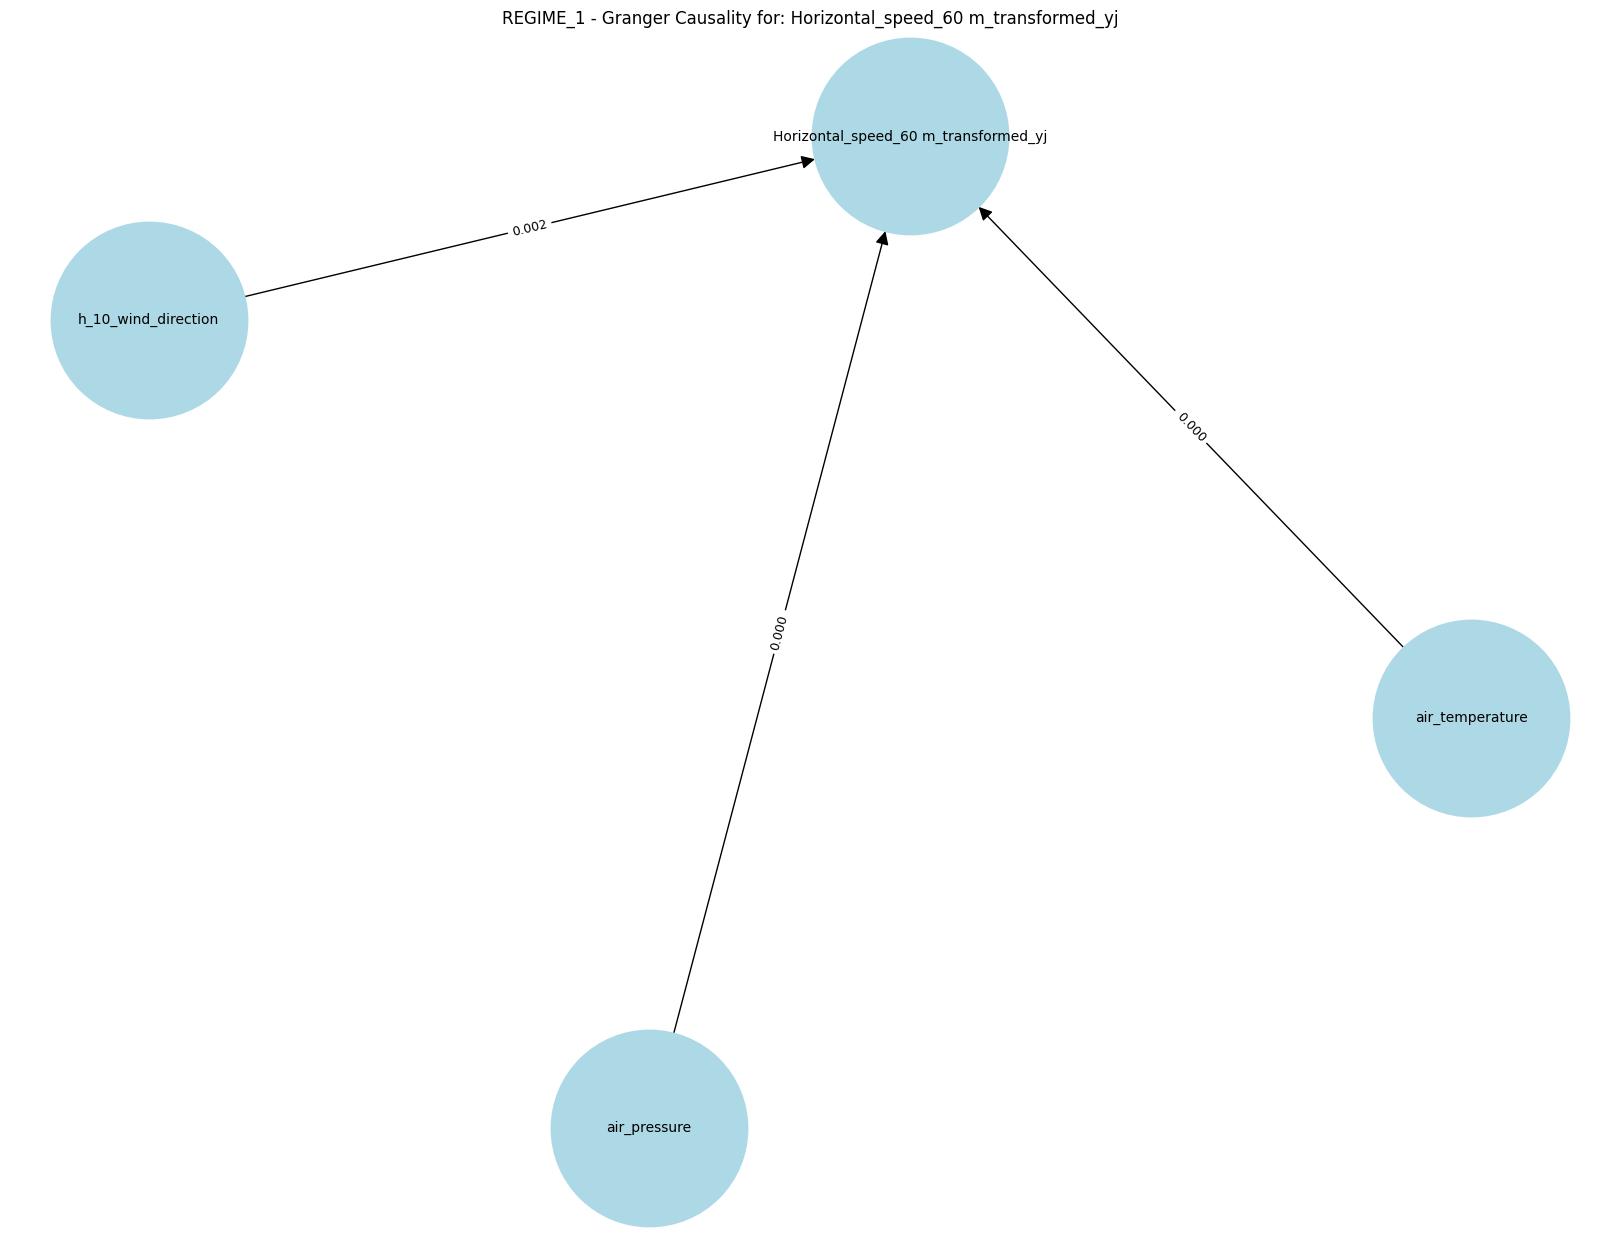

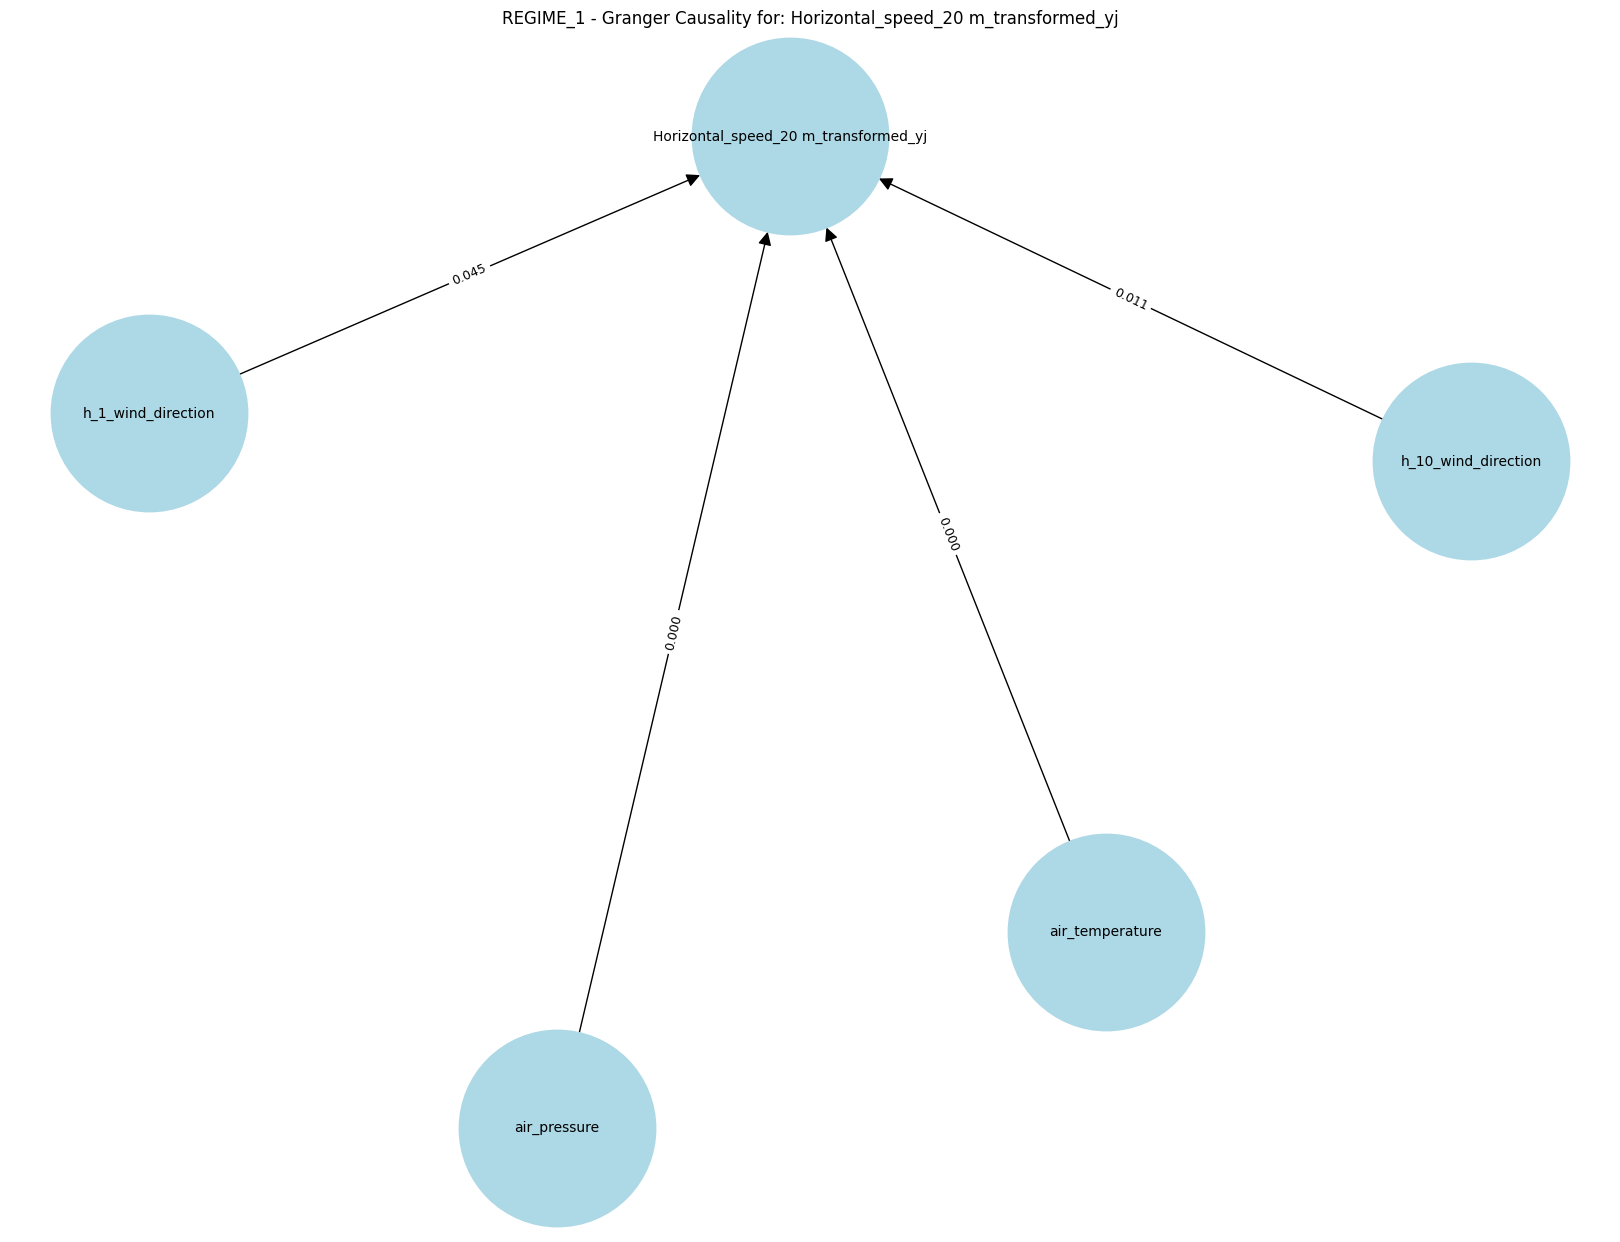

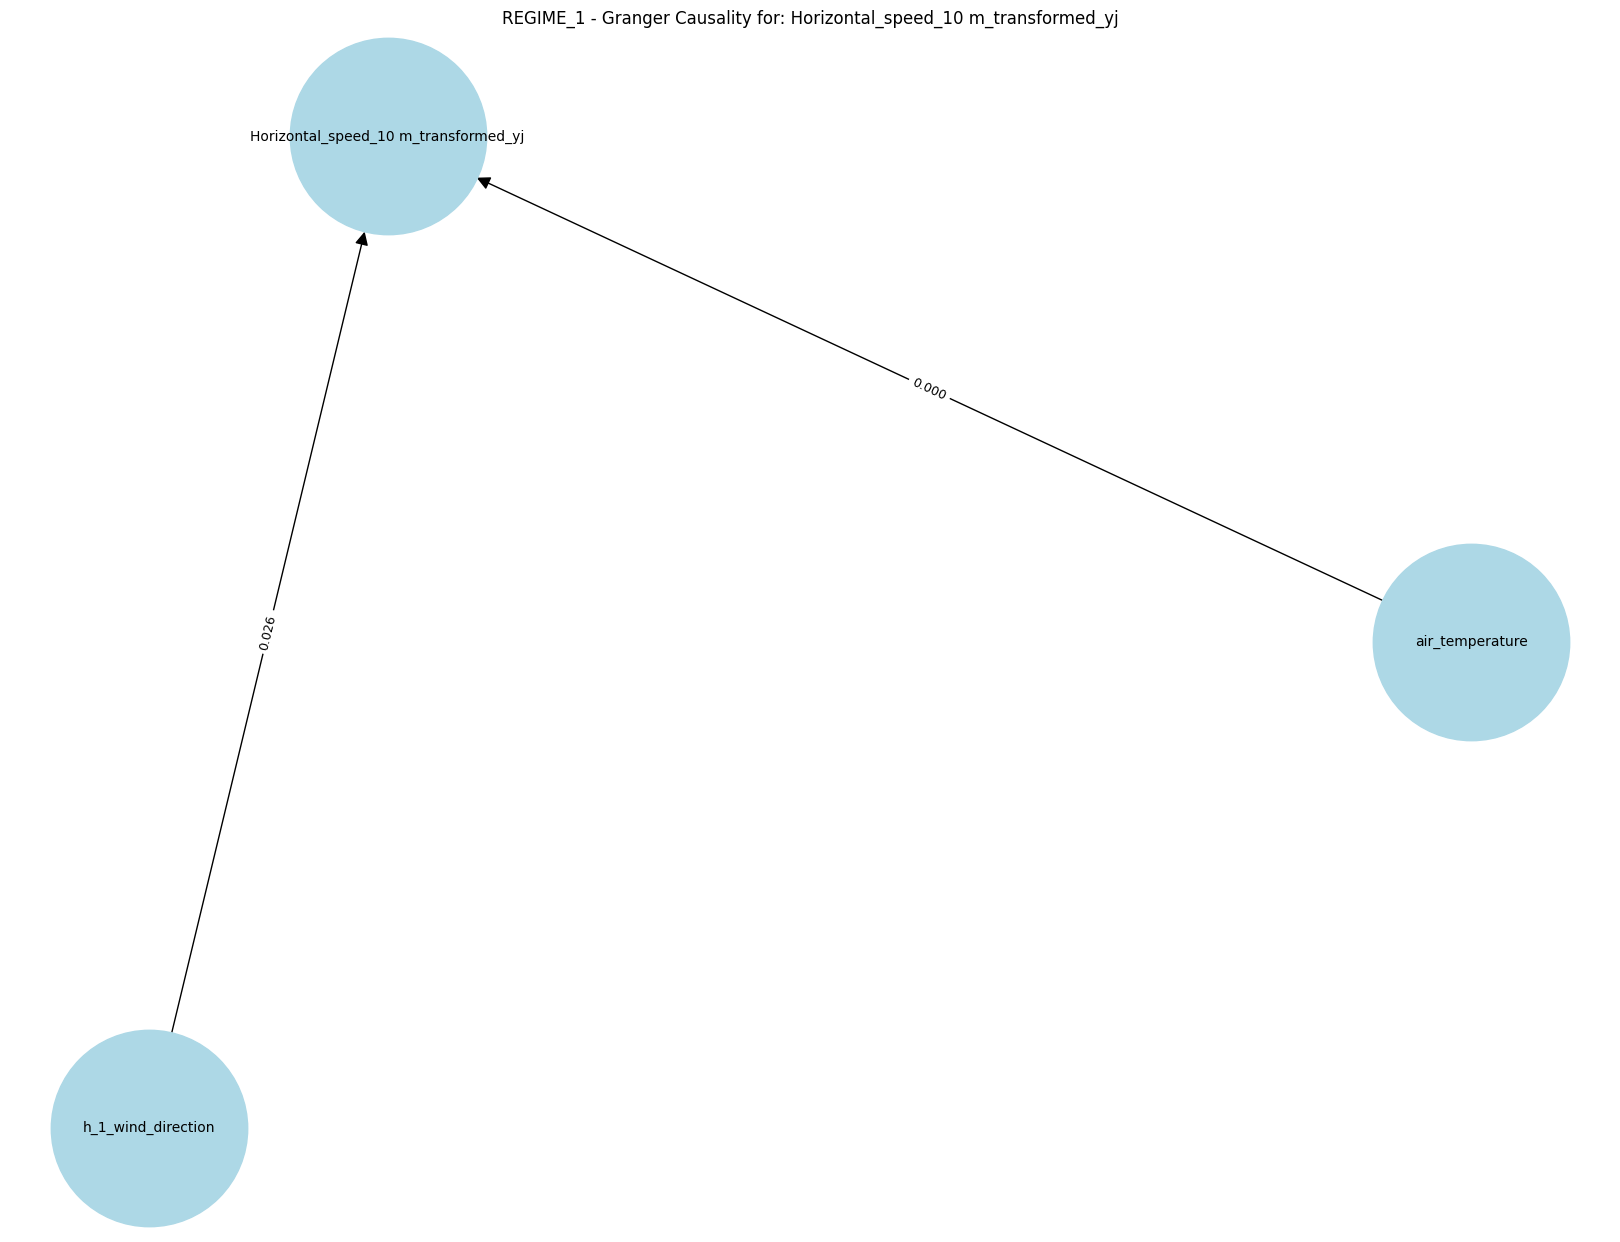

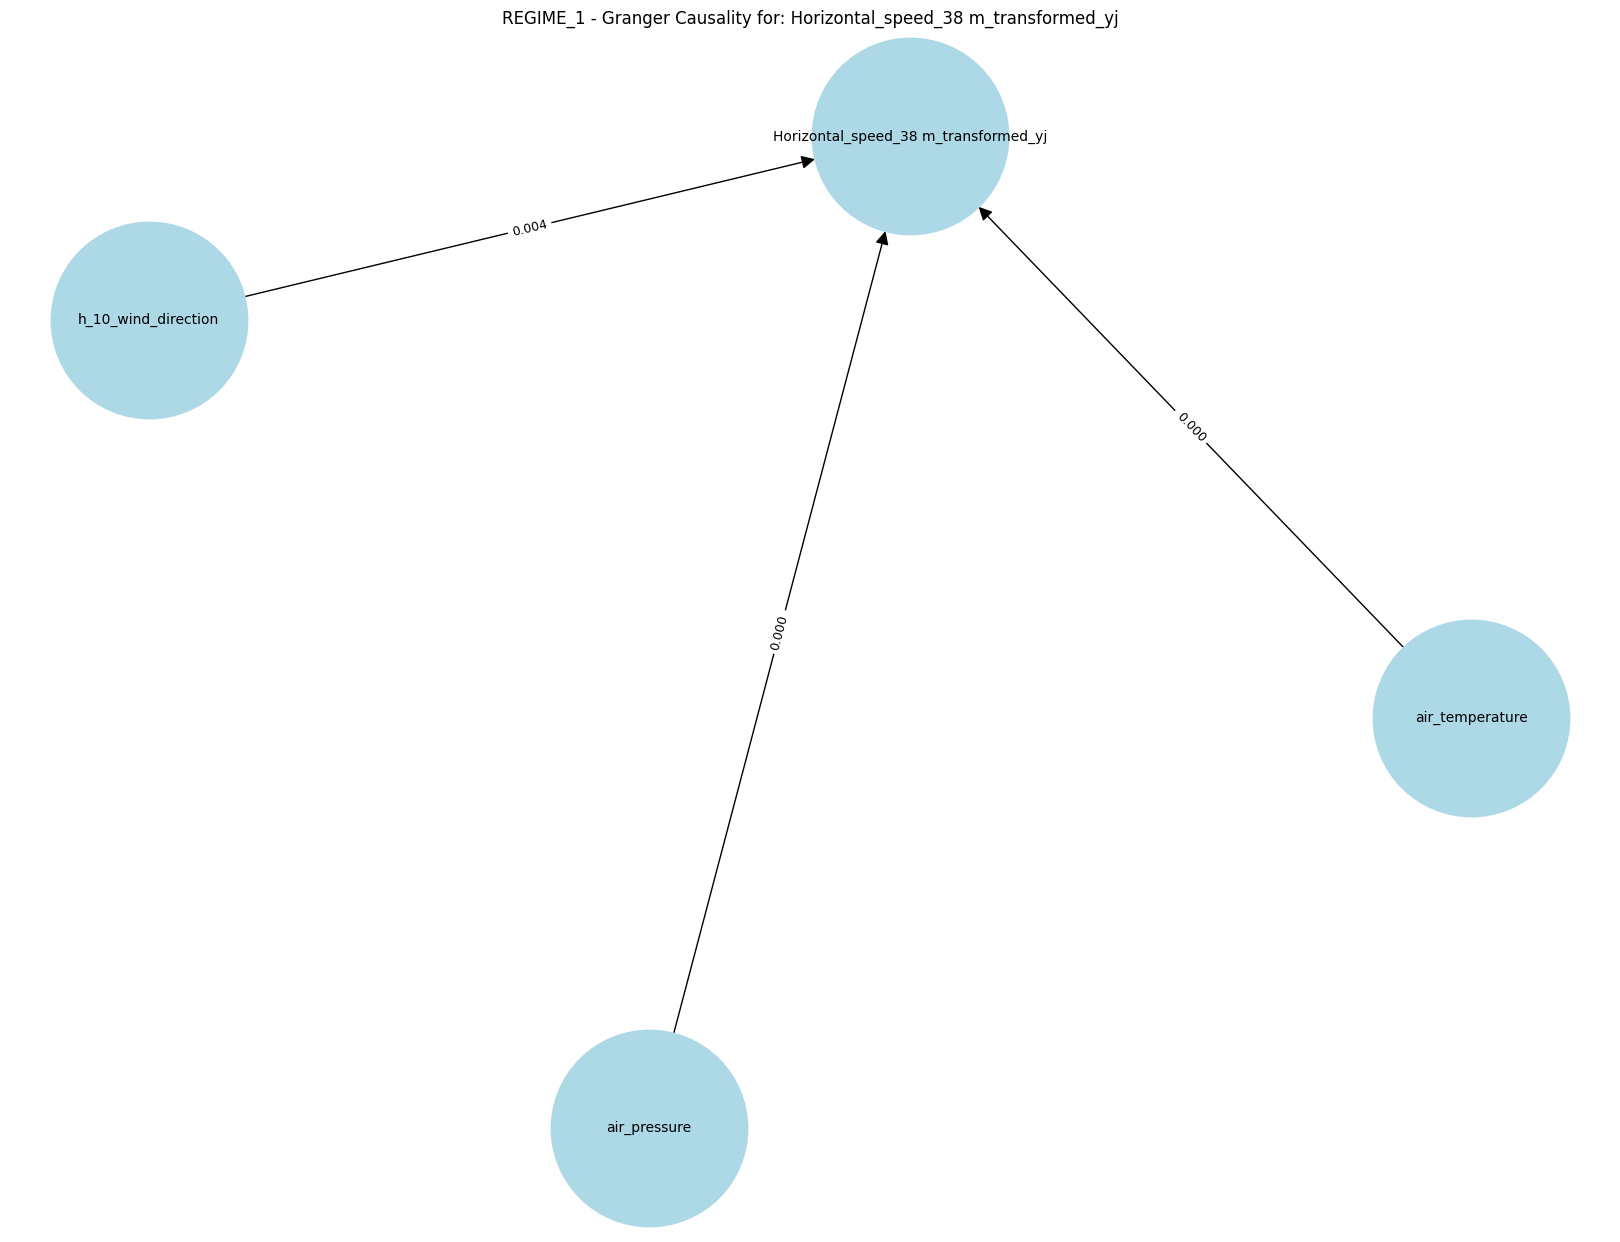

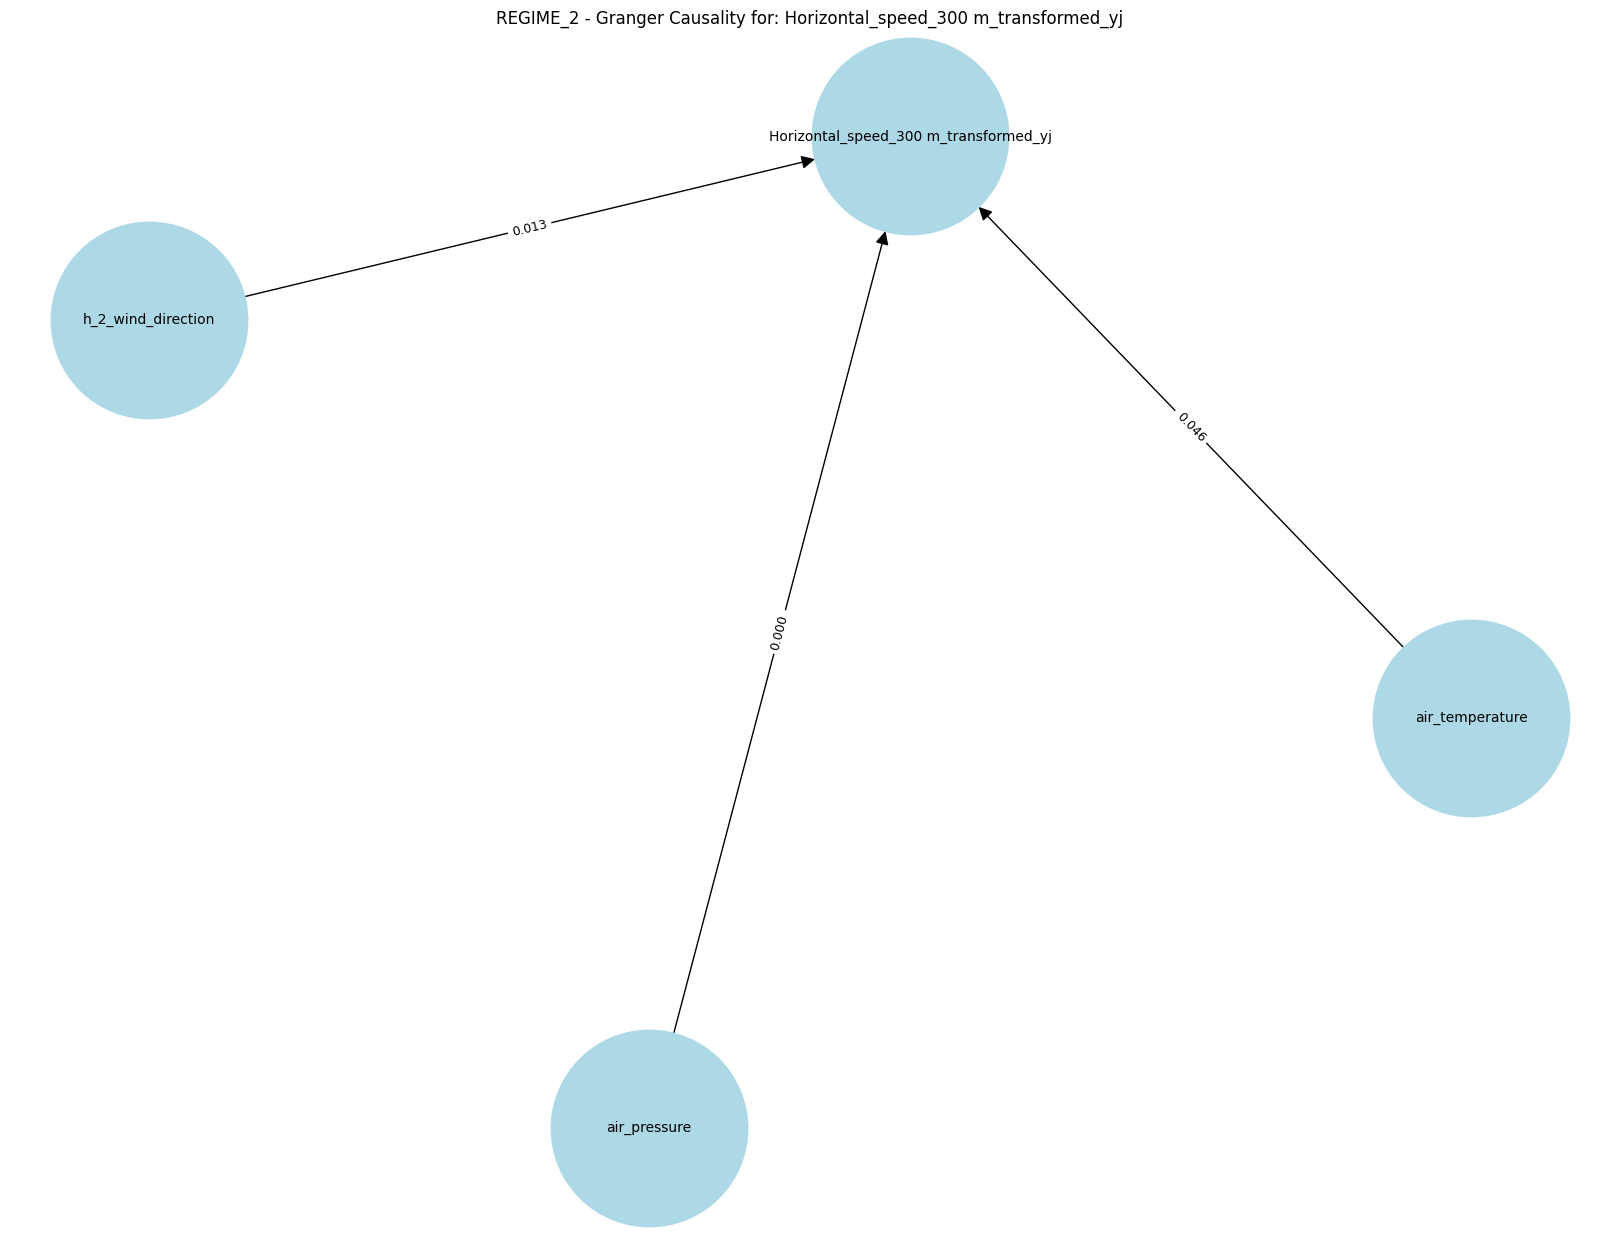

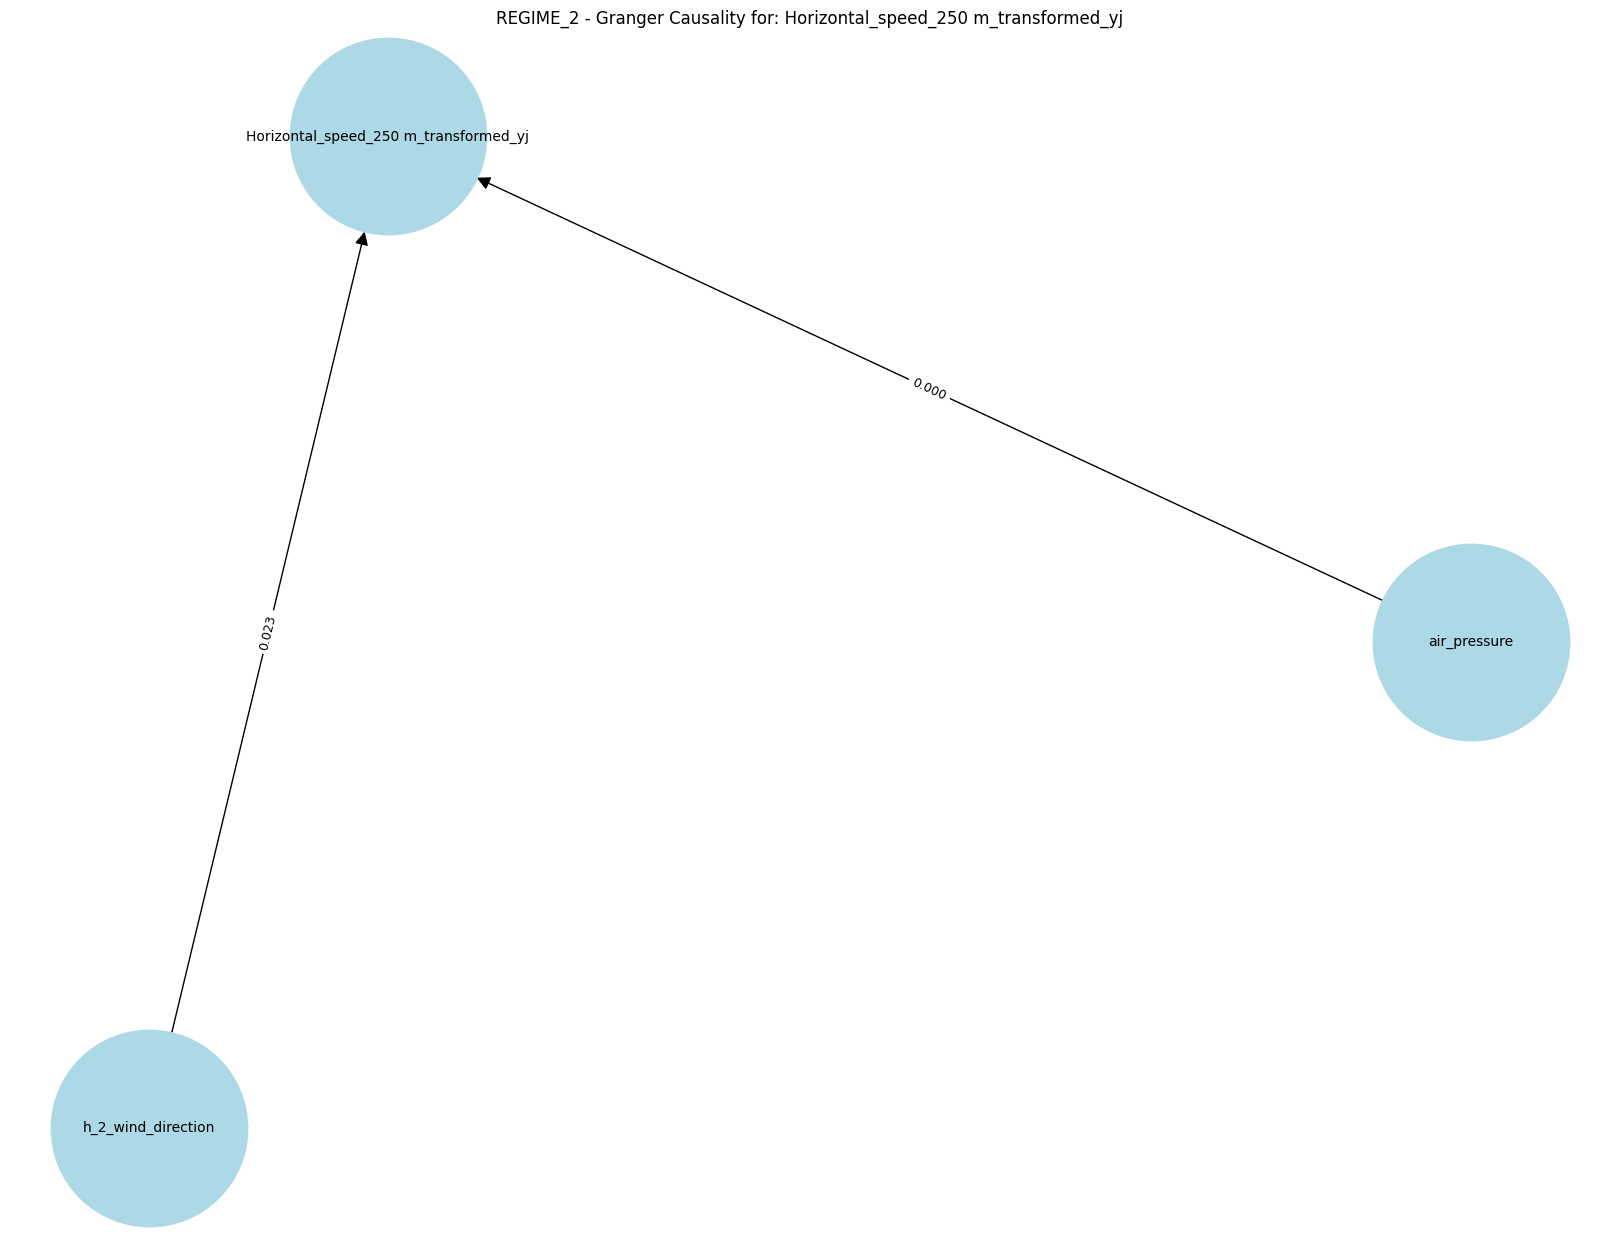

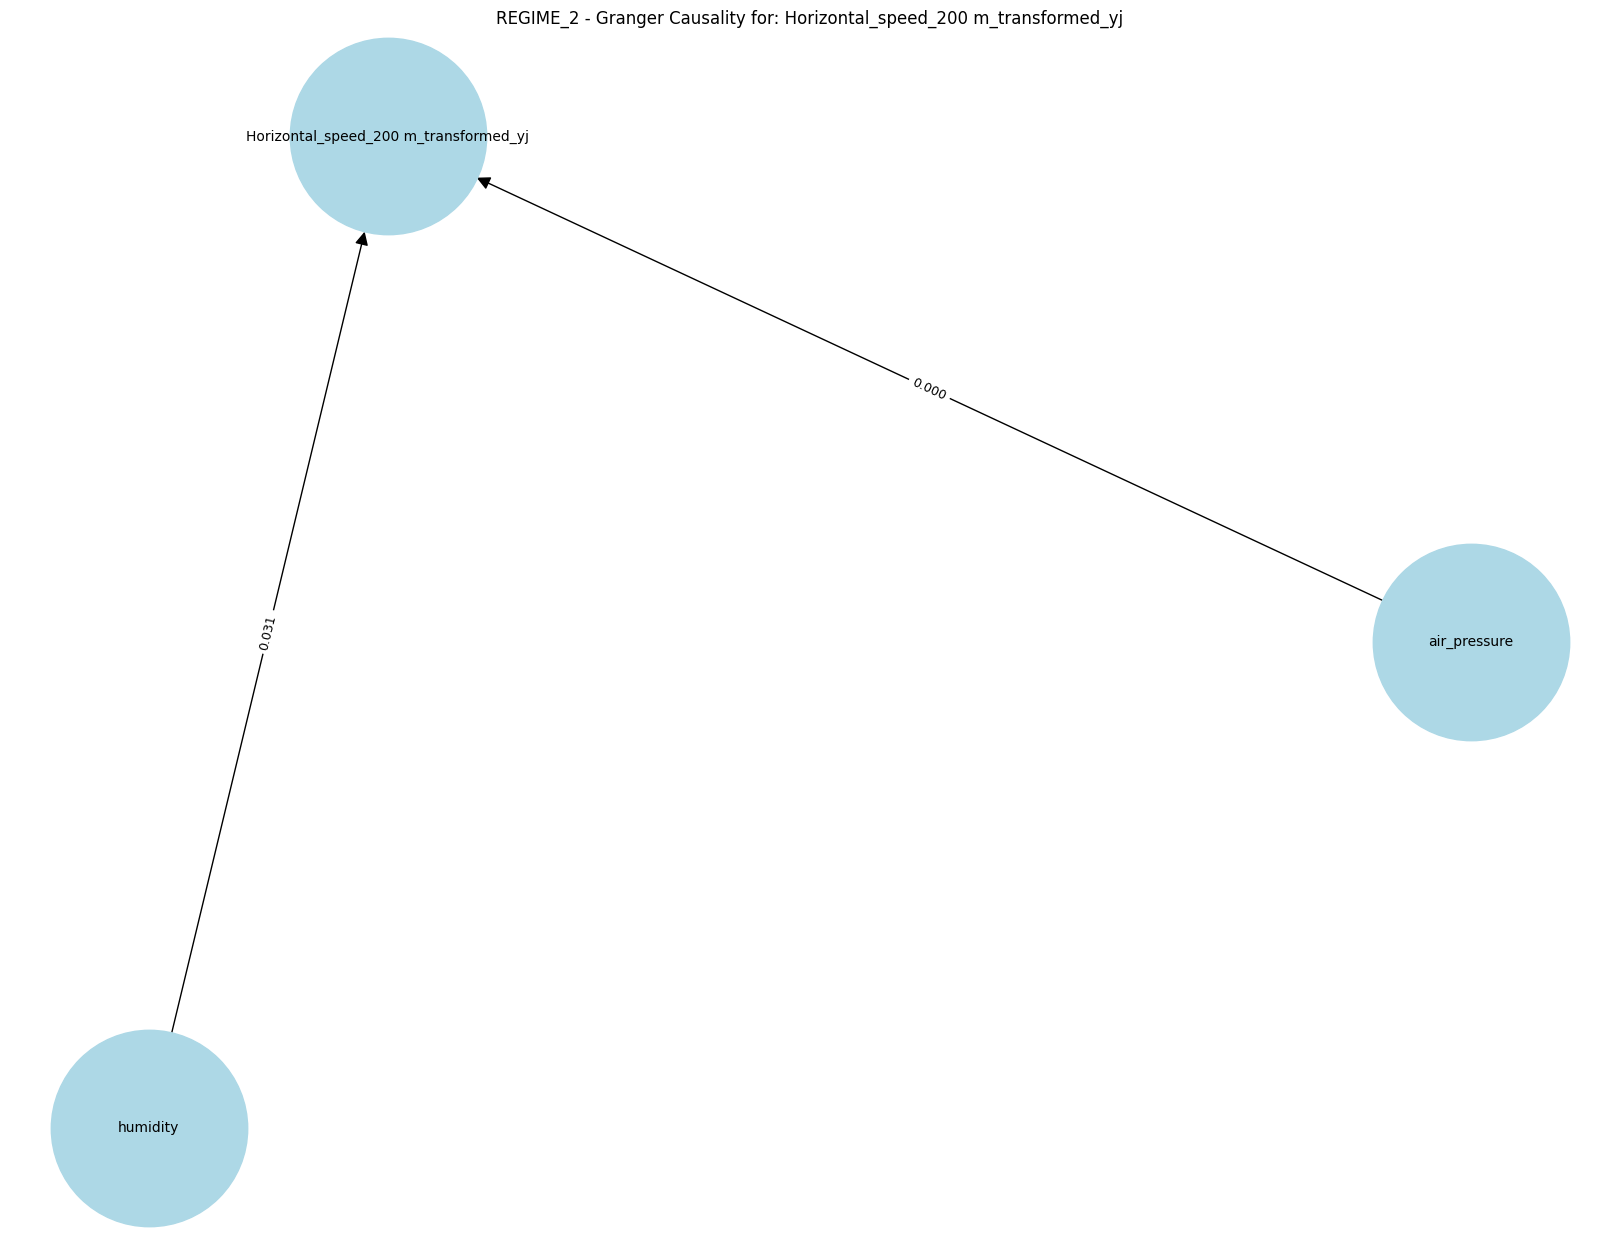

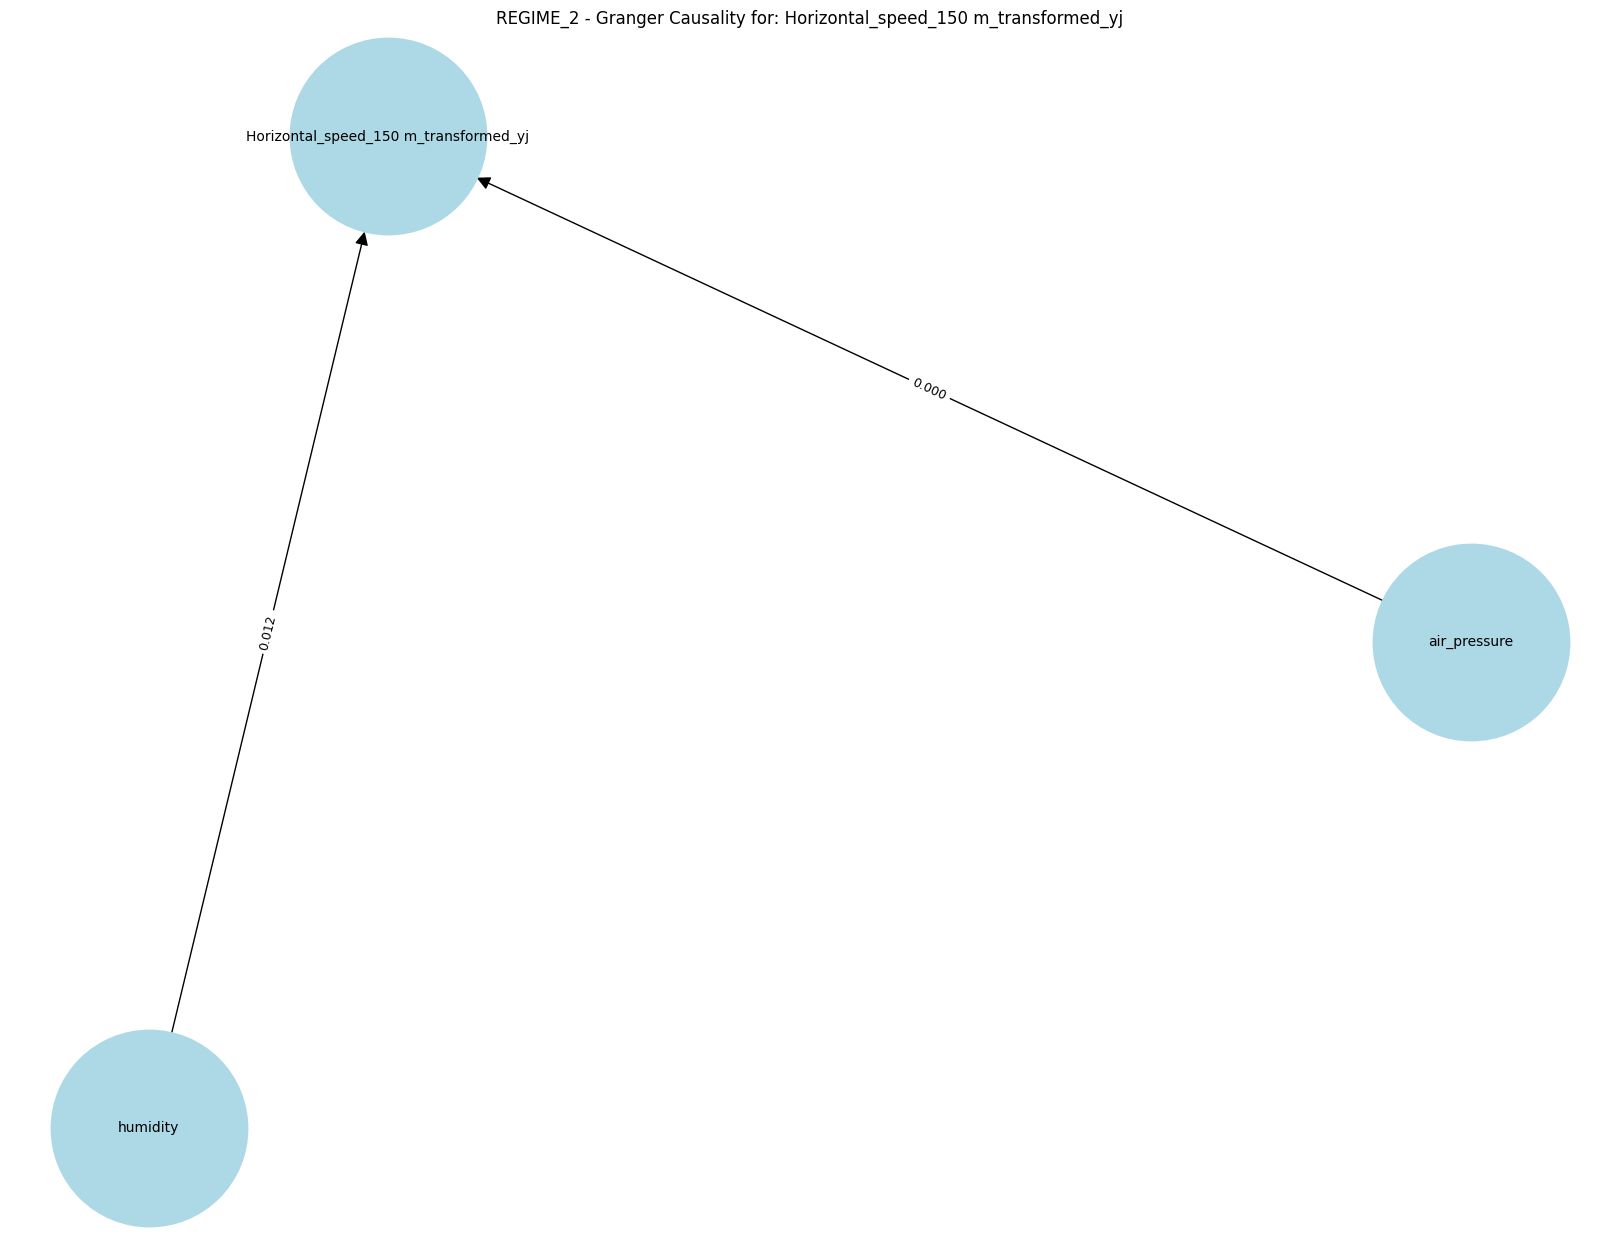

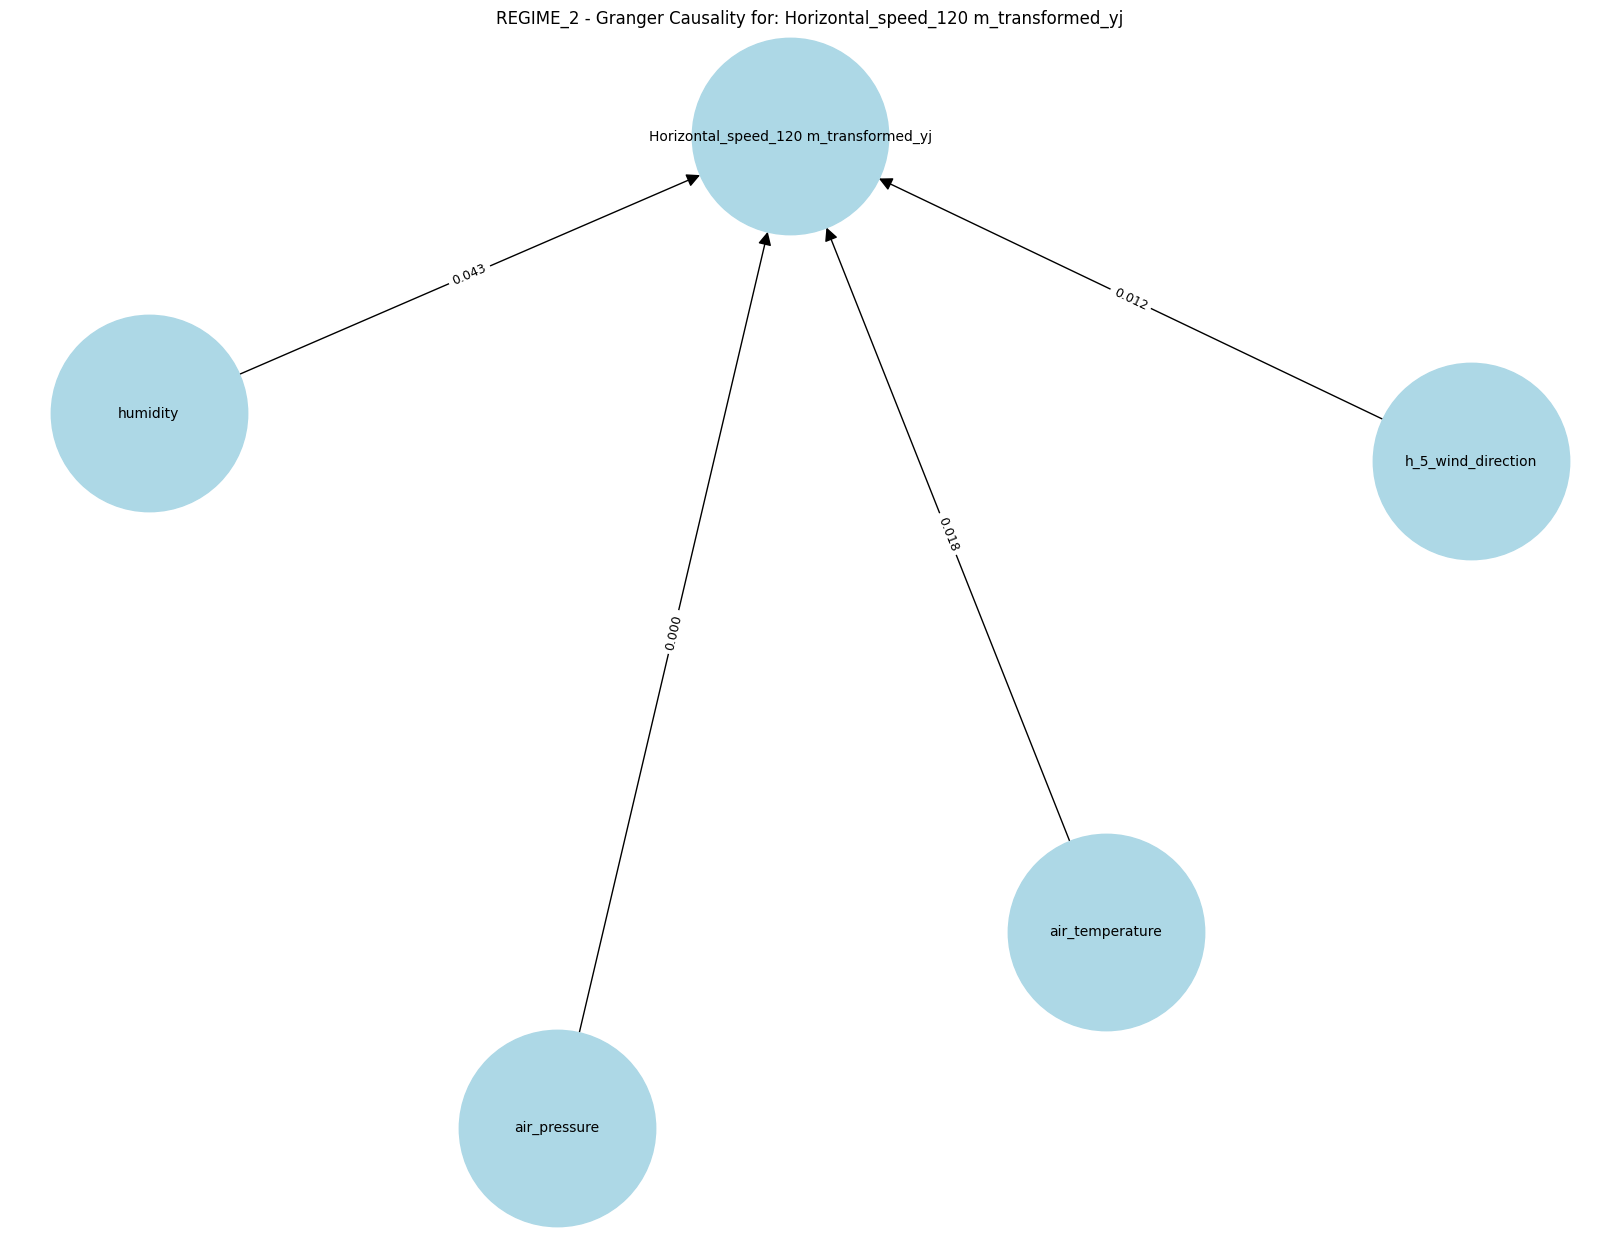

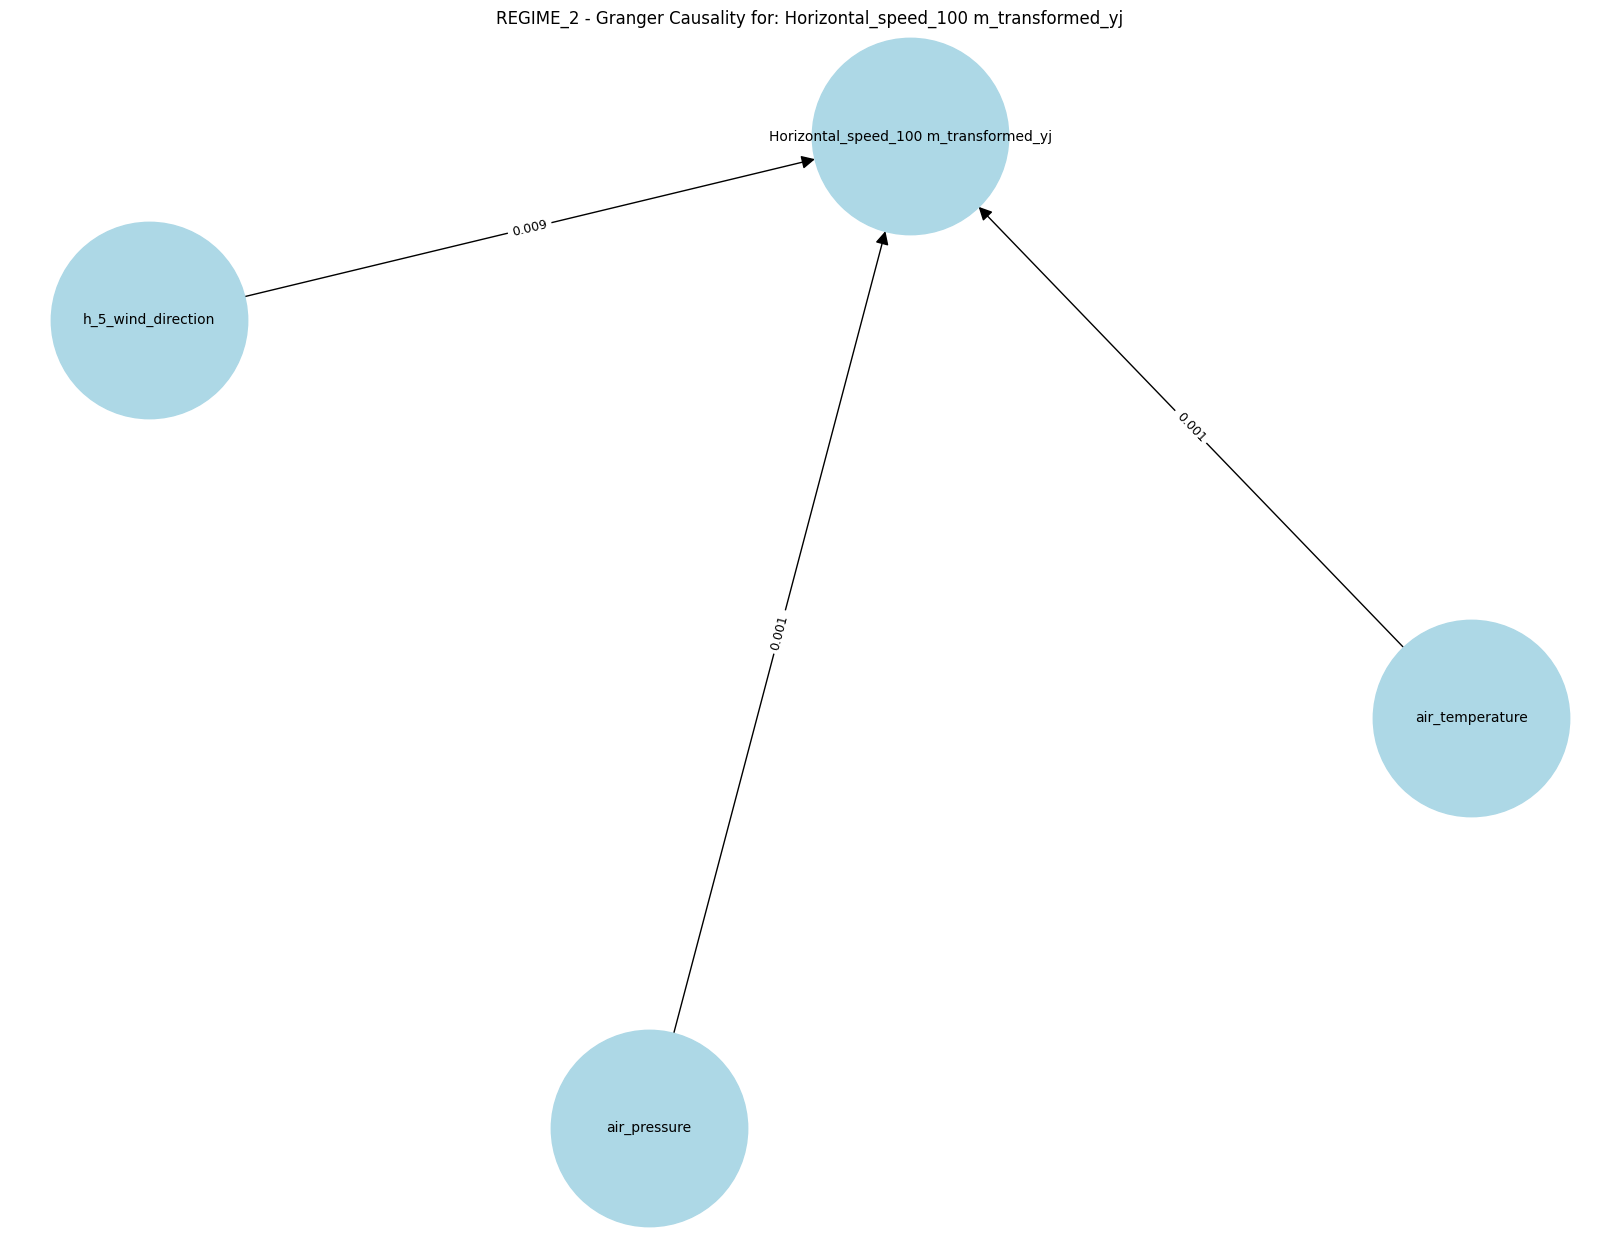

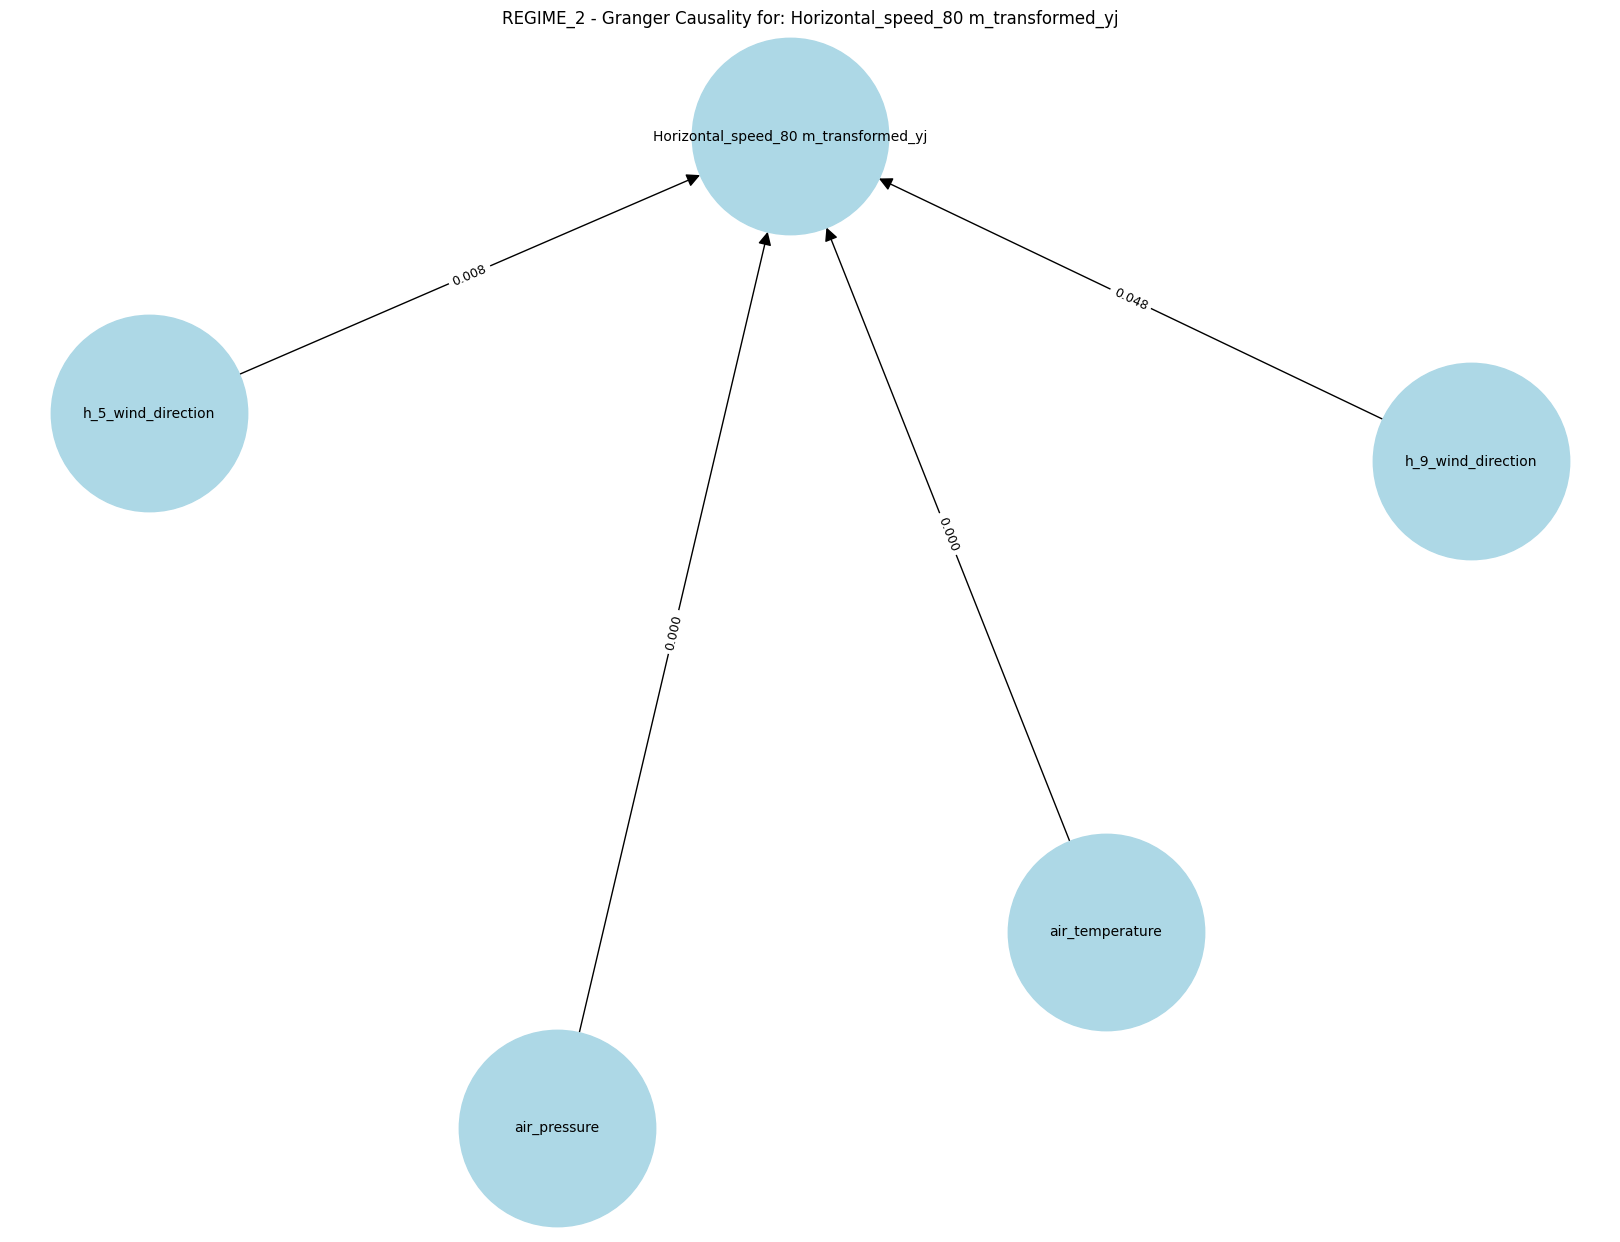

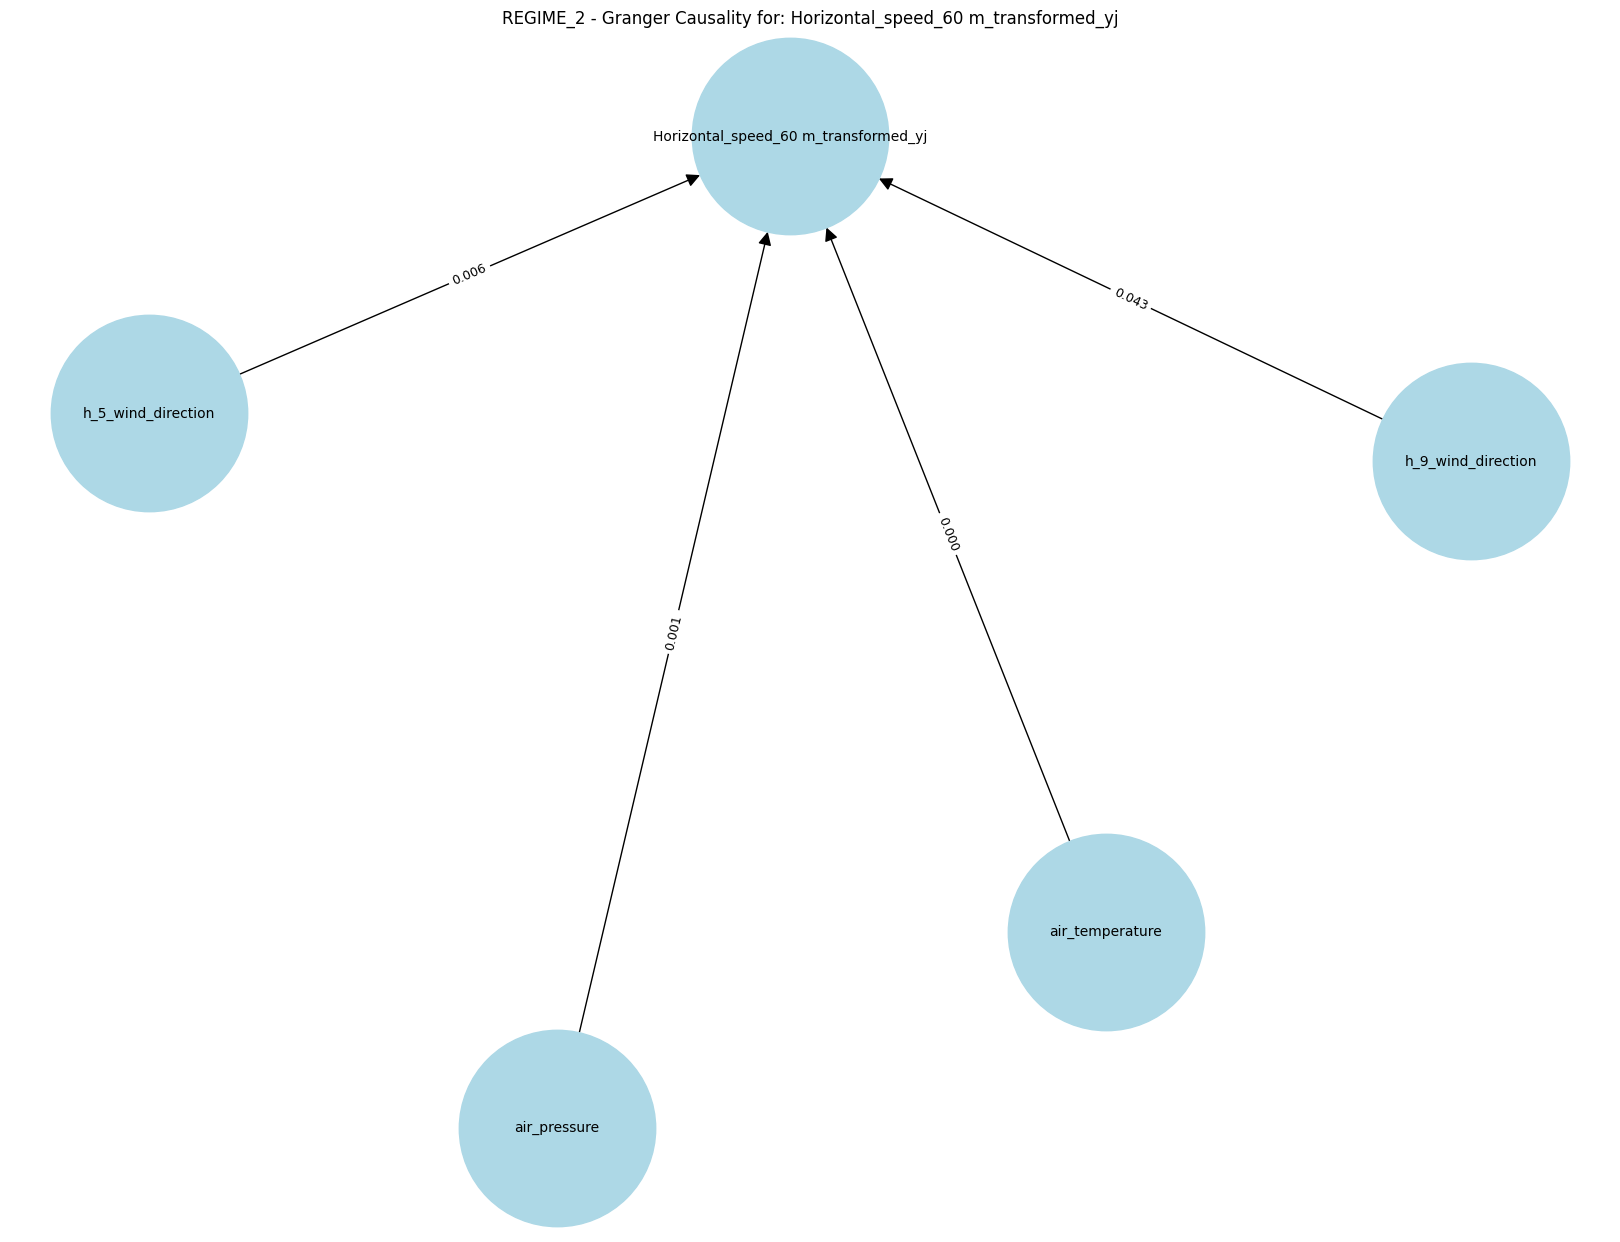

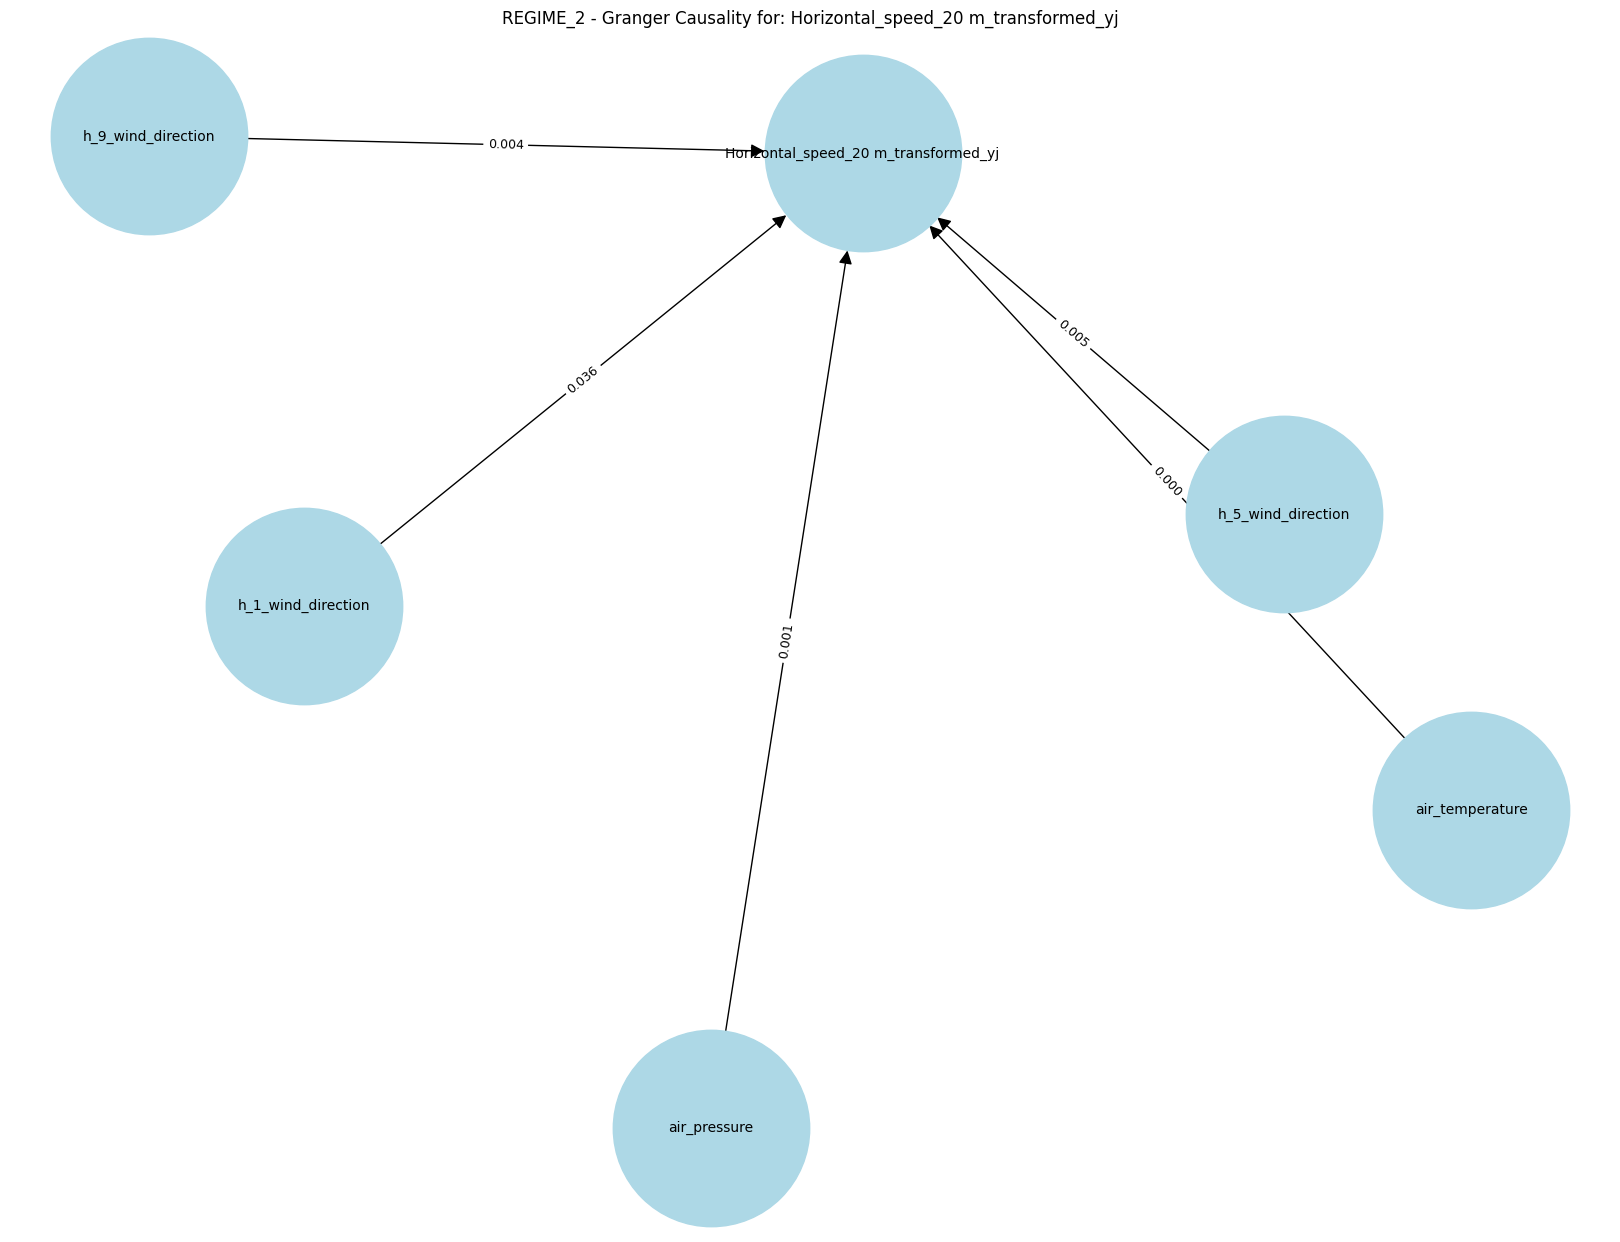

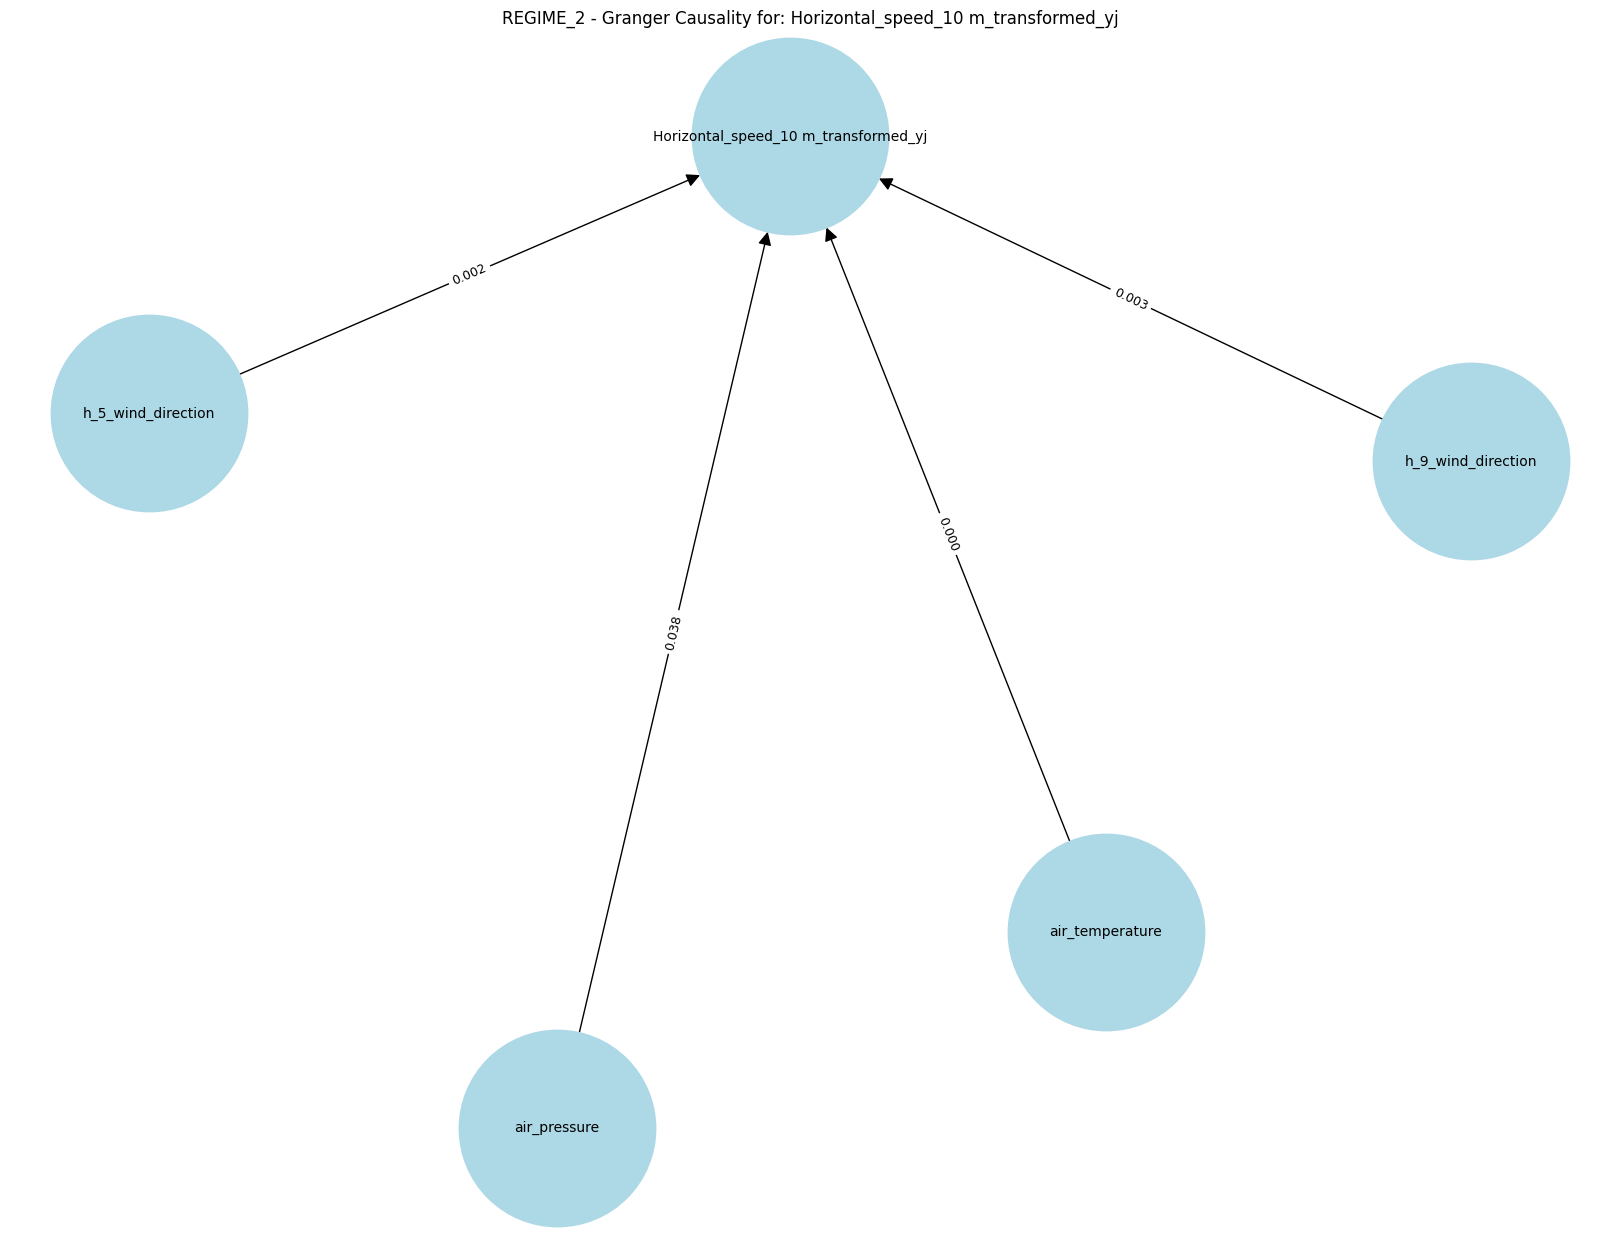

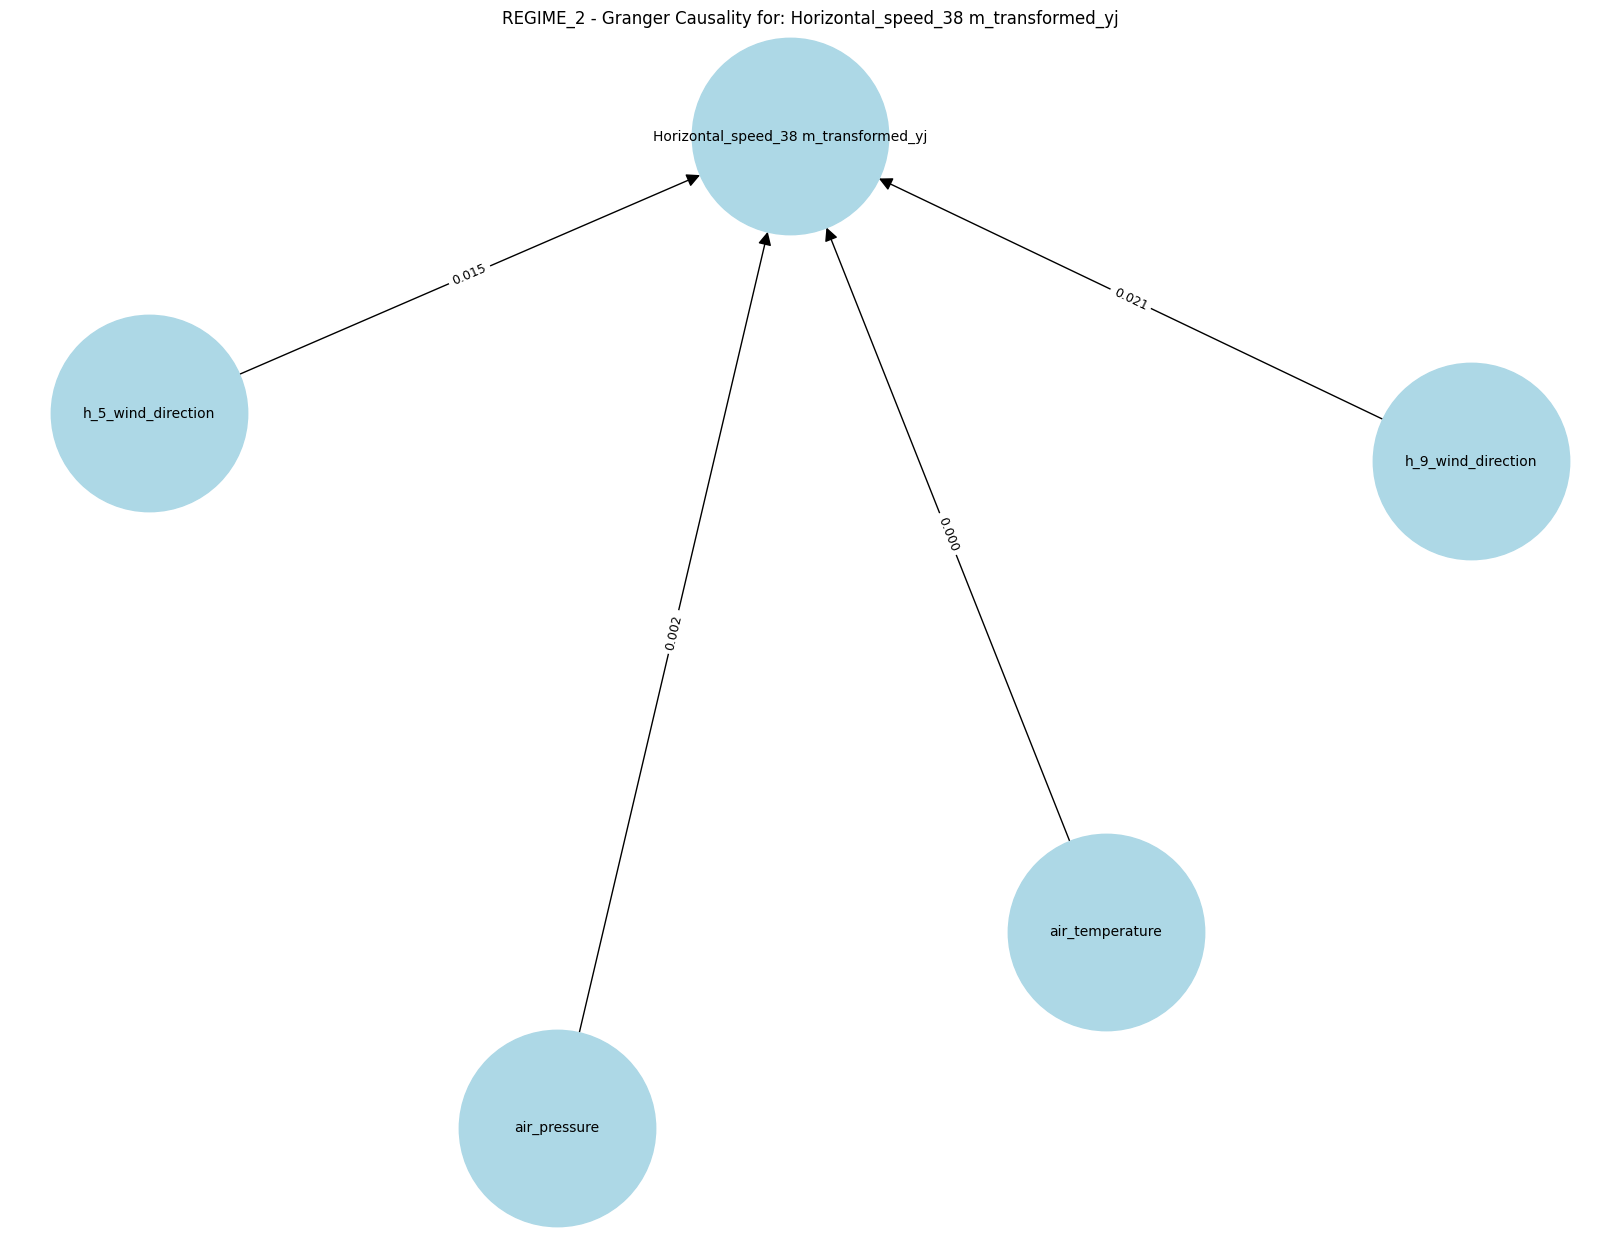

In [12]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_granger_graphs_per_target(granger_results, p_threshold=0.05):
    for regime, mat in granger_results.items():
        for target in mat.index:
            G = nx.DiGraph()
            influences = mat.loc[target].dropna()

            # Filter by significance threshold
            sig_influences = influences[influences < p_threshold]
            if sig_influences.empty:
                print(f"No significant influencers for {target} in {regime}")
                continue

            # Build graph
            G.add_node(target)
            for cause, pval in sig_influences.items():
                G.add_node(cause)
                G.add_edge(cause, target, label=f"{pval:.3f}")

            # Plot graph
            plt.figure(figsize=(16, 12))
            pos = nx.spring_layout(G, seed=42)

            nx.draw(G, pos, with_labels=True, node_color="lightblue",
                    node_size=20000, font_size=10, arrowsize=20)

            # Draw edge labels (p-values)
            edge_labels = nx.get_edge_attributes(G, 'label')
            nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels,
                                         font_size=9, label_pos=0.5)

            plt.title(f"{regime.upper()} - Granger Causality for: {target}", fontsize=12)
            plt.axis("off")
            plt.tight_layout()
            plt.show()

# Run the visualization
draw_granger_graphs_per_target(gc_regime_results, p_threshold=0.05)

# **Dynamic Basian Network**

In [ ]:
import pandas as pd
import numpy as np
from pgmpy.models import DynamicBayesianNetwork as DBN
from pgmpy.estimators import MaximumLikelihoodEstimator, HillClimbSearch
from pgmpy.estimators import K2
from sklearn.preprocessing import KBinsDiscretizer

# === Discretization helper ===
def discretize_data(df, strategy='quantile', n_bins=5):
    discretizer = KBinsDiscretizer(n_bins=n_bins, encode='ordinal', strategy=strategy)
    # Ensure the output is a DataFrame with original column names and correct index
    return pd.DataFrame(discretizer.fit_transform(df), columns=df.columns, index=df.index).astype(int)

# === Train DBNs per regime ===
def train_dbn_per_regime(df, regime_col='regime', discretization_strategy='quantile', n_bins=5):
    regimes = df[regime_col].unique()
    dbn_models = {}

    for reg in regimes:
        print(f"\nTraining DBN for Regime {reg}...")
        df_reg = df[df[regime_col] == reg].drop(columns=[regime_col]).copy()

        if df_reg.empty:
            print(f"Skipping Regime {reg}: No data available.")
            continue

        # Discretize the data using the chosen strategy
        # Apply discretization only to the data for the current regime
        df_disc = discretize_data(df_reg, strategy=discretization_strategy, n_bins=n_bins)

        # Time-slice into t and t+1
        # Ensure consistent indexing after discretization and slicing
        data_t = df_disc.iloc[:-1].copy()
        data_t1 = df_disc.iloc[1:].copy()

        # Align indices before concatenating
        common_index = data_t.index.intersection(data_t1.index)
        data_t = data_t.loc[common_index]
        data_t1 = data_t1.loc[common_index]


        data_t.columns = [f"{col}_t" for col in data_t.columns]
        data_t1.columns = [f"{col}_t+1" for col in data_t1.columns]
        df_timesliced = pd.concat([data_t, data_t1], axis=1)


        if df_timesliced.empty or len(df_timesliced) < 2:
            print(f"Skipping Regime {reg}: Not enough data after slicing ({len(df_timesliced)} data points).")
            continue

        # Learn structure using BIC for discrete data
        # Ensure the estimator uses the timesliced DataFrame
        hc = HillClimbSearch(df_timesliced)
        # Pass df_timesliced to BicScore as well
        best_model = hc.estimate(scoring_method=K2(df_timesliced))

        # Initialize DBN
        dbn_model = DBN()

        # Add nodes with time slices
        nodes_t0 = [(col, 0) for col in df_reg.columns]
        nodes_t1 = [(col, 1) for col in df_reg.columns]
        dbn_model.add_nodes_from(nodes_t0 + nodes_t1)


        # Map edges from timesliced model to DBN structure
        for u, v in best_model.edges():
            u_node_name = u.replace('_t', '').replace('_t+1', '')
            v_node_name = v.replace('_t', '').replace('_t+1', '')

            if u.endswith('_t') and v.endswith('_t+1'):
                # Inter-slice edge (t -> t+1)
                dbn_model.add_edge((u_node_name, 0), (v_node_name, 1))
            elif u.endswith('_t') and v.endswith('_t'):
                # Intra-slice edge (at time t)
                dbn_model.add_edge((u_node_name, 0), (v_node_name, 0))


        if not dbn_model.check_model():
            print(f"Warning: Invalid DBN structure for Regime {reg}. Skipping parameter learning.")
            dbn_models[f"regime_{reg}"] = None
            continue


        # Fit model with discretized data for the current regime
        # Prepare data for DBN fitting: list of dataframes for each time slice
        data_for_fit = [df_disc.iloc[:-1].copy(), df_disc.iloc[1:].copy()]

        try:
            dbn_model.fit(data_for_fit, estimator=MaximumLikelihoodEstimator)
            dbn_models[f"regime_{reg}"] = dbn_model
        except Exception as e:
             print(f"Failed to fit DBN for Regime {reg}: {e}")
             dbn_models[f"regime_{reg}"] = None


    return dbn_models

# === Execute training ===
# Ensure df_selected from previous cells is available and has a 'regime' column
if 'regime' not in df_selected.columns:
    print("Error: 'regime' column not found in df_selected. Please run the HMM cell first.")
else:
    dbn_models = train_dbn_per_regime(df_selected)

    # === Display learned structures ===
    for regime, model in dbn_models.items():
        print(f"\n{regime.upper()} STRUCTURE:")
        if model:
            print("Intra-slice (Time 0) Edges:")
            intra_edges = [(u, v) for u, v in model.edges() if u[1] == 0 and v[1] == 0]
            if intra_edges:
                for u, v in intra_edges:
                     print(f"{u[0]} -> {v[0]}")
            else:
                print("No intra-slice edges found.")

            print("\nInter-slice (Time 0 -> Time 1) Edges:")
            inter_edges = [(u, v) for u, v in model.edges() if u[1] == 0 and v[1] == 1]
            if inter_edges:
                 for u, v in inter_edges:
                    print(f"{u[0]}_t -> {v[0]}_t+1")
            else:
                print("No inter-slice edges found.")
        else:
            print("Model training failed or skipped for this regime.")


Training DBN for Regime 1...


  0%|          | 0/1000000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np
# Corrected import path for BayesianNetwork and NormalDistribution in pomegranate v1.0.0+
from pomegranate.bayesian_network import BayesianNetwork
from pomegranate.distributions import NormalDistribution # Corrected import
from sklearn.preprocessing import StandardScaler

def train_manual_dbn_pomegranate(df, regime_col='regime'):
    """
    Trains a Dynamic Bayesian Network (DBN) for each unique regime in the DataFrame
    using the updated pomegranate v1.0.0+ API.

    Args:
        df (pd.DataFrame): The input DataFrame containing time-series data and a regime column.
        regime_col (str, optional): The name of the column that defines the different regimes.
                                    Defaults to 'regime'.

    Returns:
        dict: A dictionary where keys are regime names (e.g., 'regime_X') and values are tuples
              containing the trained pomegranate.BayesianNetwork model and a list of column names
              used for training (which include '_t' and '_t+1' suffixes).
    """
    regimes = df[regime_col].unique()
    dbn_models = {}

    for reg in regimes:
        print(f"\nTraining DBN for Regime {reg}...")

        # Get data for the current regime and drop the regime column itself
        df_reg = df[df[regime_col] == reg].drop(columns=[regime_col]).copy()

        # Check if df_reg is empty after filtering
        if df_reg.empty:
            print(f"Skipping Regime {reg}: No data available.")
            continue

        # Check if there's enough data for time slicing (at least 2 rows)
        if len(df_reg) < 2:
            print(f"Skipping Regime {reg}: Not enough data for time slicing (need at least 2 rows).")
            continue

        # Scale the data for numerical stability during model training
        scaler = StandardScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df_reg), columns=df_reg.columns)

        # Create time slices: data at time t and data at time t+1
        # iloc[:-1] gets all rows except the last one (for time t)
        data_t = df_scaled.iloc[:-1].copy().reset_index(drop=True)
        # iloc[1:] gets all rows except the first one (for time t+1)
        data_t1 = df_scaled.iloc[1:].copy().reset_index(drop=True)

        # Rename columns to distinguish between time t and time t+1 variables
        data_t.columns = [f"{col}_t" for col in data_t.columns]
        data_t1.columns = [f"{col}_t+1" for col in data_t1.columns]

        # Concatenate the time-sliced DataFrames horizontally
        # This creates a single DataFrame where each row represents (state_t, state_t+1)
        df_dbn = pd.concat([data_t, data_t1], axis=1)

        # --- START: Updated for pomegranate v1.0.0+ API ---
        # Define distributions for each variable.
        # pomegranate v1.0.0+ expects a list of distributions directly in the constructor
        # or to be added. Since our data is continuous (scaled), NormalDistribution is used.
        distributions = [NormalDistribution() for _ in range(df_dbn.shape[1])]

        # Initialize BayesianNetwork with the distributions.
        # The structure (edges) will be learned automatically by the .fit method
        # if not explicitly provided during initialization.
        model = BayesianNetwork(distributions=distributions, name=f"Regime_{reg}")

        # Fit the model to the prepared data.
        # This will learn both the structure and parameters of the distributions.
        model.fit(df_dbn.values)
        # --- END: Updated for pomegranate v1.0.0+ API ---

        # Store the trained model and the column names (which indicate the variables used)
        dbn_models[f"regime_{reg}"] = (model, df_dbn.columns)

    return dbn_models

# Example Usage (assuming df_selected is your DataFrame and 'regime' is your regime column)
# To test, you can create a dummy df_selected:
# data = {
#     'feature1': np.random.rand(20),
#     'feature2': np.random.rand(20),
#     'regime': ['A']*10 + ['B']*10
# }
# df_selected = pd.DataFrame(data)
dbn_models = train_manual_dbn_pomegranate(df_selected)

# View summaries of the learned DBN structures
for regime, (model, cols) in dbn_models.items():
     print(f"\n{regime.upper()} STRUCTURE:")
     # model.structure provides the learned dependencies where structure[i] is a list
     # of indices of nodes that are children of node i.
     # We iterate through each node (parent) and its children to print the connections.
     for parent_idx, children_indices in enumerate(model.structure):
         for child_idx in children_indices:
             # \u2192 is the right arrow symbol for better readability in output
             print(f"{cols[parent_idx]} \u2192 {cols[child_idx]}")

ImportError: cannot import name 'NormalDistribution' from 'pomegranate.distributions' (/usr/local/lib/python3.11/dist-packages/pomegranate/distributions/__init__.py)